\pagenumbering{gobble}

\ 
\ 
\ 
\ 
\ 
\ 
\ 
\ 
\ 


This serves as an overview script of my workflow for data generated with a plate reader which hopefully enables me to partially automate that process.

But I also want to reuse code that I wrote and compensate for the lack of documentation in the python script (to keep me sane :D). 

*13.10.2022*

## Imports and general settings

In [96]:
# imports
import pandas as pd
import numpy as np # for calculating standard deviation and mean
import scipy.stats as sp # for calculating standard error
import matplotlib.pyplot as plt
import matplotlib
from pylatex import Figure, NoEscape, Subsubsection
from pylatex.utils import italic
import os
from sklearn import metrics
from scipy.optimize.minpack import curve_fit
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#matplotlib.style.use('seaborn-poster')
matplotlib.rcParams.update({'errorbar.capsize': 2})
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'font.family': 'serif'})
matplotlib.rcParams['figure.dpi'] = 180
matplotlib.rcParams['savefig.dpi'] = 180
matplotlib.rcParams['lines.linewidth'] = 2 

pd.set_option('display.latex.repr', True)
pd.set_option('display.latex.longtable', True)
plt.style.use(['science','grid', 'muted'])
matplotlib.rcParams['lines.linewidth'] = 2.5

# set colorstandards to fit to labnotebook
colorstandards = {'14':'tab:cyan', '15':'g', '16':'darksalmon', '17': 'goldenrod'}

Optional: We can define matplotlib to use pgf which makes importing into .tex better. Plots will not be shown but saved to a file. Defining the filepath only makes sense with that option.

In [97]:
#matplotlib.use("pgf")
#matplotlib.rcParams.update({"pgf.texsystem": "pdflatex", 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

## Utilities to preprocess the data

Data coming from the plate reade will have the time denoted in a funny format which we need to convert. We remove the funny format and return a dataframe with a usable time column.

In [98]:
def add_time(df):
    m = [isinstance(i, datetime) for i in df['Time']]
    df['timedelta'] = pd.to_timedelta(df['Time'].astype(str), errors='coerce')
    df.loc[m, 'timedelta'] = df.loc[m, 'Time'].apply(lambda t: pd.Timestamp(str(t)) - pd.Timestamp('1899-12-31'))
    df['Time'] = (df['timedelta'] - df['timedelta'][0])
    df['Time'] = df['Time'].dt.total_seconds() / 60
    df['Time'] += 15
    return df.drop('timedelta', axis=1)

We have a full dataframe where we want to average the technical replicates. It might be sensible to look at how the single columns look first in an overview plot and check whether one well might have done something weird and remove that. This is not possible with the following function.

`bio_rep` refers to a plate where we only looked at one strain with 3 biological replicates.

In [99]:
def extract_columns(df, conditions, bio_rep=False, bio_rep_name=''):
    """transforms excel table to df where the technical triplicates are averaged

    Args:
        df (pandas-df): excel from plate reader loaded
        conditions (dict): plate_layout loaded with convert_layout()
    """

    triplicates = df.iloc[:,2:].groupby(np.arange(len(df.iloc[:,2:].columns))//3, axis=1).mean()

    blank = triplicates[triplicates.columns[3::4]]
    blank.columns = np.arange(8)

    left = triplicates[triplicates.columns[::4]]
    left.columns = np.arange(8)
    left = left - blank
    left = left.rename(columns=conditions)
    left = df.iloc[:,:1].join(left, how='outer')
    left = add_time(left)

    middle = triplicates[triplicates.columns[1::4]]
    middle.columns = np.arange(8)
    middle = middle - blank
    middle = middle.rename(columns=conditions)
    middle = df.iloc[:,:1].join(middle, how='outer')
    middle = add_time(middle)

    right = triplicates[triplicates.columns[2::4]]
    right.columns = np.arange(8)
    right = right - blank
    right = right.rename(columns=conditions)
    right = df.iloc[:,:1].join(right, how='outer')
    right = add_time(right)
    
    def double_std(array):
        return np.std(array) * 2
    
    if bio_rep:
        df_concat = pd.concat((left, middle, right))
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        df_errors = by_row_index.agg([np.mean, double_std, sp.sem])
        return_dict = {conditions['A']:left,
                   conditions['B']:middle,
                   conditions['C']:right,
                   bio_rep_name: df_means}
    
    else:
        return_dict = {conditions['A']:left,
                   conditions['B']:middle,
                   conditions['C']:right}
        df_errors = None
    
    return  return_dict, df_errors

We define a csv where we denote the plate layout to save us some time later. This file is called `plate_layout.csv`. The following function will help us convert this csv to a dictionary which the holds all information on the plate layout.

In [100]:
def convert_layout(plate_layout_file = 'plate_layout.csv'):
    """converts csv layout file to work with other functions

    Args:
        plate_layout_file (str): Path to csv with layout. Defaults to 'plate_layout.csv'.

    Returns:
        dict: date as keys and layout as value (entry of the row)
    """
    layout = pd.read_csv(plate_layout_file)
    layout_dict = {}

    for entry in layout.to_dict('records'):
        new_dict = {}
        for k, v in entry.items():
            try: 
                k = int(k)
                new_dict[k] = v
            except(ValueError):
                new_dict[k] = v
        layout_dict[new_dict['date']] = new_dict
    
    return layout_dict

If you use the naming schema yymmdd<some more info>.xlsx the following function can be used aswell. 

In [101]:
def get_info(excel_file):
    date = excel_file[:6]
    nice_date = date[4:] + '.' + date[2:4] + '.20' + date[:2]
    plate_layout = convert_layout()[int(date)]
    nrows = 0 
    if plate_layout['duration'] == 24.0:
        nrows = 96 #96 for 24
    if plate_layout['duration'] == 48.0:
        nrows = 193 #193 for 48h
    bio_rep_name = ''
    if plate_layout['biological replicates']:
        bio_rep_name = str(int(plate_layout['strain']))
    return nrows, plate_layout, bio_rep_name, nice_date

## Focus: One strain in multiple media

### Averaging technical replicates and plotting

This way we will only need to give the path to the folder where we store the excel files coming from the plate reader (`path_to_excel`) and the excel file of interest (`excel_file`).

In [102]:
# inputs
path_to_excel = 'plate_reader_results/'

###
# you only need to modify this and denote layout in plate_layout.csv
excel_file = '220615_Cstr.xlsx' 

Now we are all set to plot the first dataset. If we look at biological replicates, they will be numbered. The plot titled only with the strain shows the averaged curves.

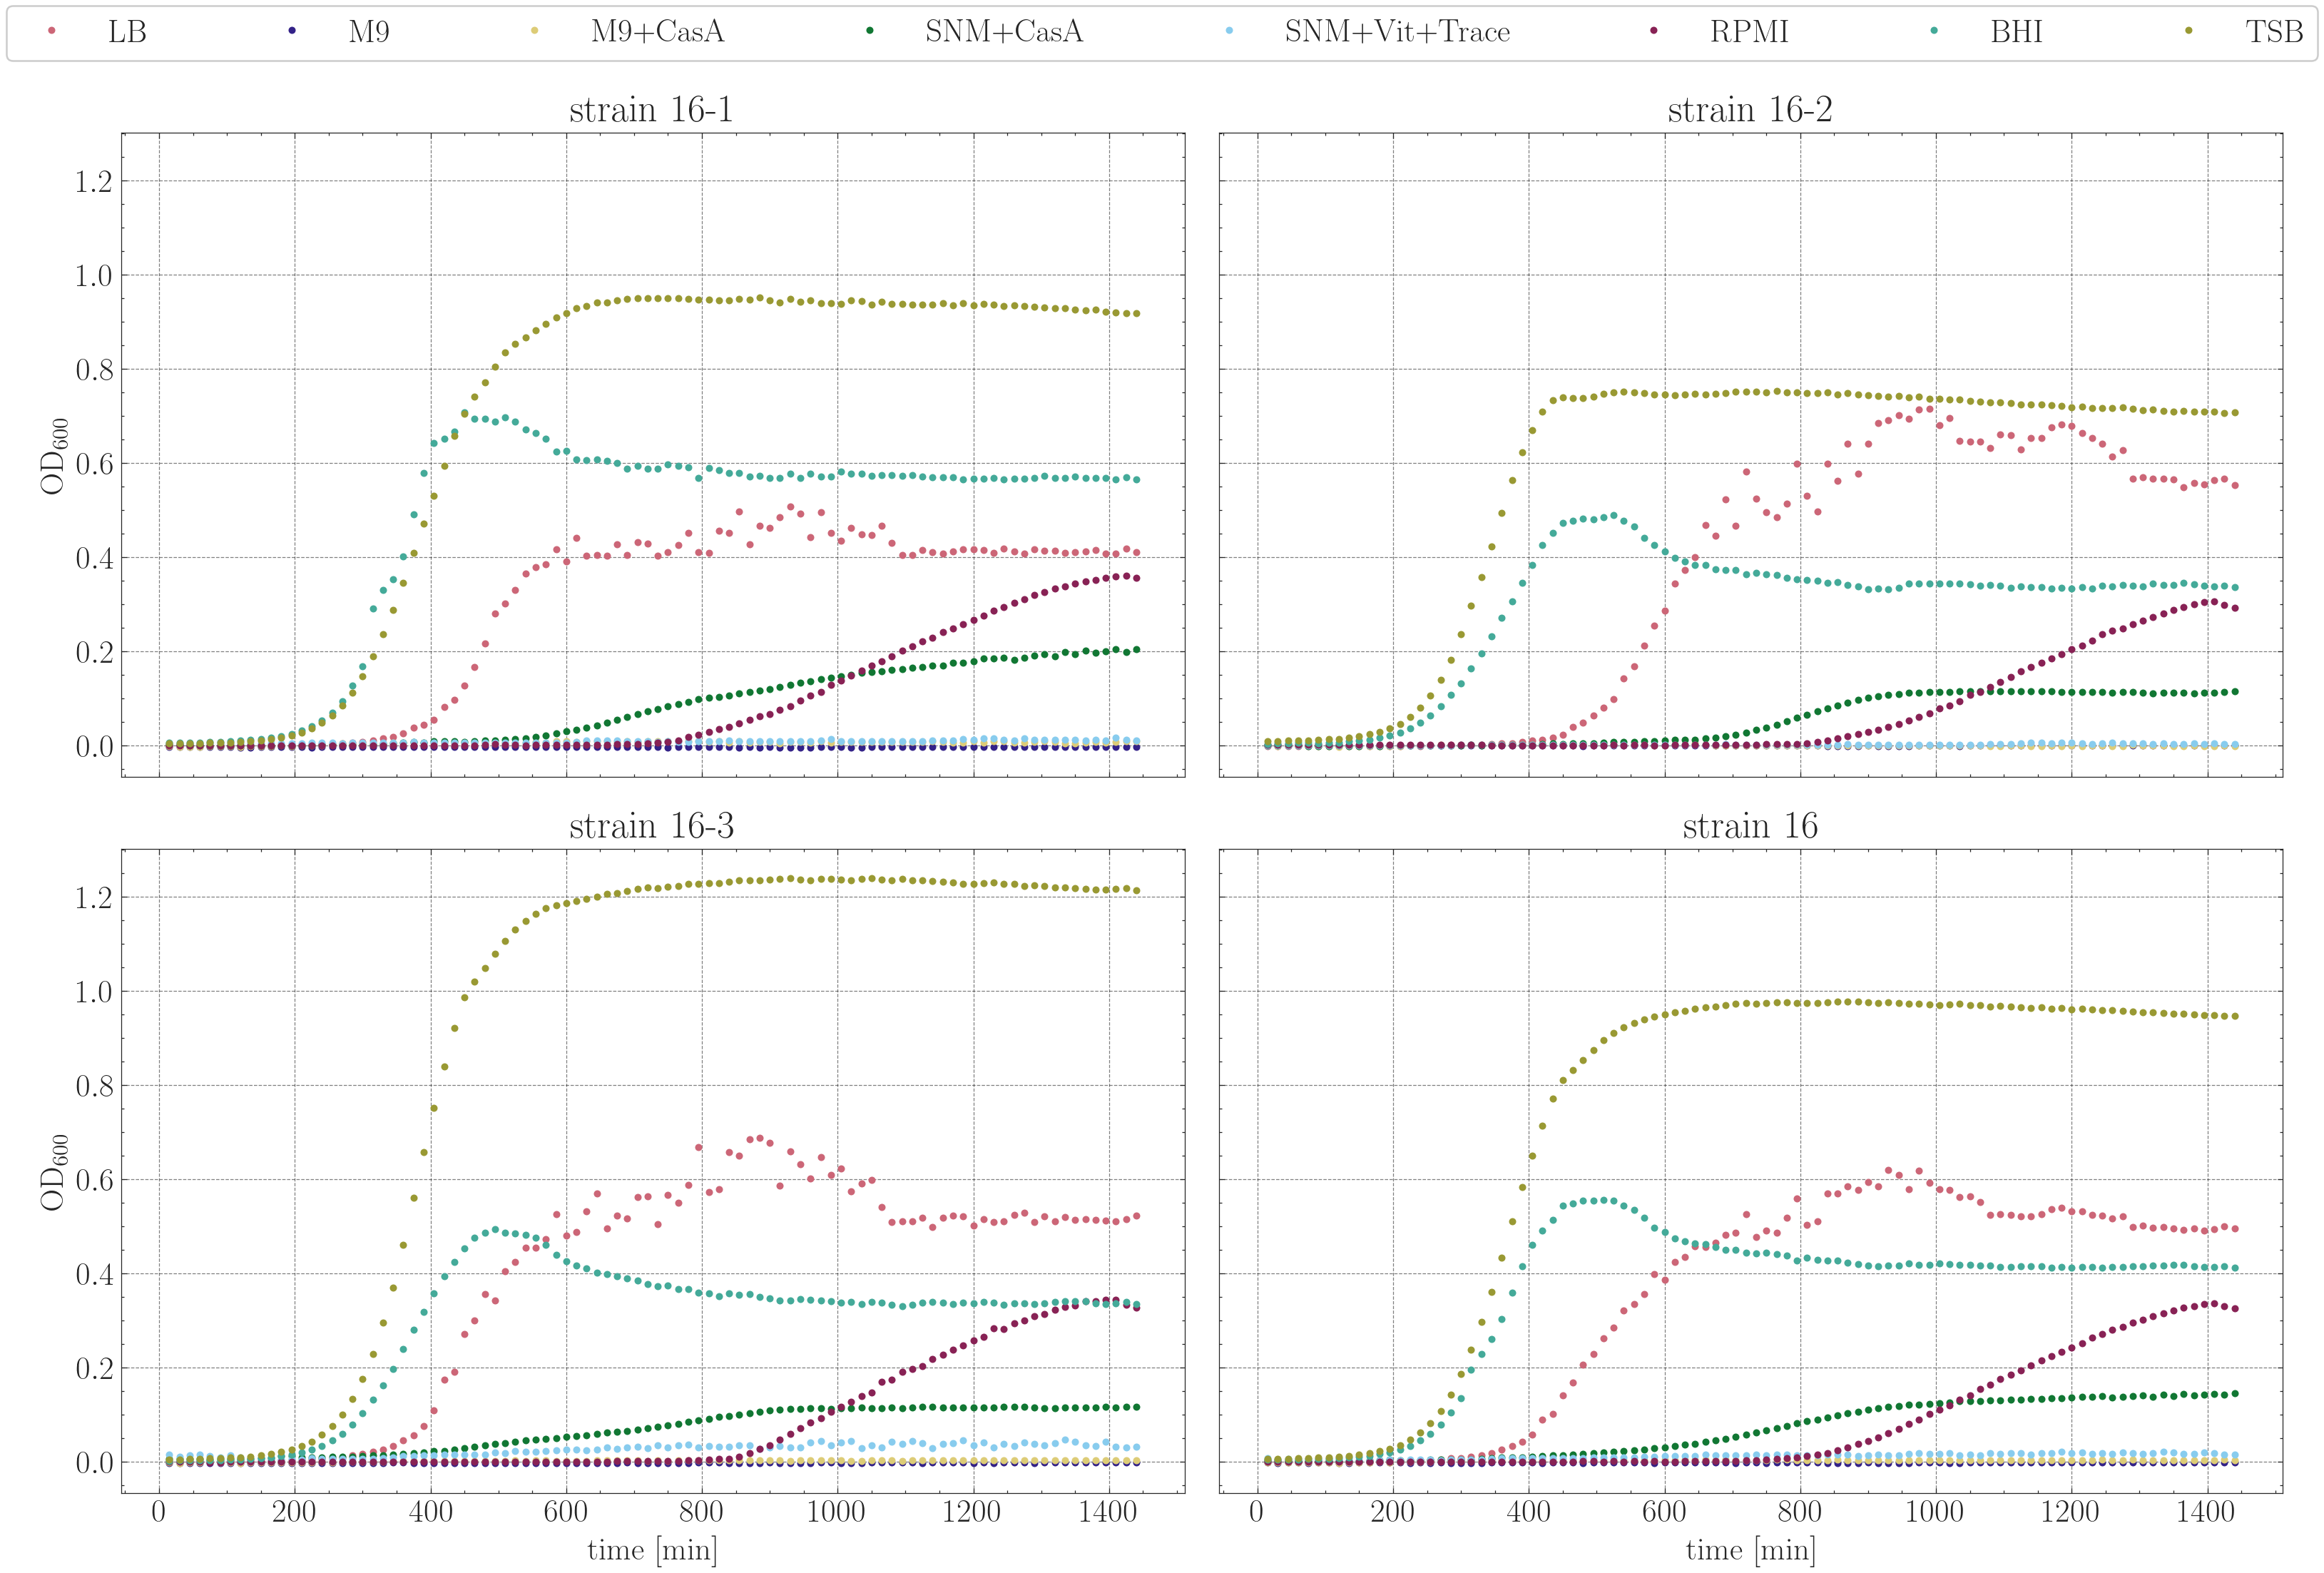

In [103]:
nrows, plate_layout, bio_rep_name, nice_date = get_info(excel_file)
df = pd.read_excel(path_to_excel+excel_file, usecols="B:CU", skiprows=57, nrows=nrows)
growth, errors = extract_columns(df, plate_layout, plate_layout['biological replicates'], bio_rep_name)

plot_number = 0
fig, axs = plt.subplots(2,2, figsize=(18, 12), facecolor='w', edgecolor='k', sharex=True, sharey=True)
axs = axs.ravel()
for strain, dataframe in growth.items():
        dataframe.plot(grid=True, 
                x="Time",
                style = '.',
                xlabel='time [min]',
                ylabel='OD$_{600}$',
                title='strain ' + strain,
                ax=axs[plot_number],
                legend=False
                )
        handles, labels = axs[plot_number].get_legend_handles_labels()
        plot_number += 1

plt.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(0., 1, 1., .102), loc='lower left', ncol=8, mode="expand", borderaxespad=0.)
        

### Fitting the growth curves to extract the growth rate

We need to define the function that we will use to fit our data using curve_fit.

In [104]:
def logistic_mod(t, K, N0, r): #asadi2020
    return K/(1+((K-N0)/N0)*np.exp(-r*t))

We can build a function which will fit all curves denoted in our dataframe.

In [105]:
def extract_growthrate(df, fit_func, rename=['a', 'b', 'growth rate'], p0=np.asarray([0.2,0.005,0.05])):

    df_growth = pd.DataFrame()
    aucs = []
    popts = {}
    pcovs = {}
    for (columnName, columnData) in df.drop('Time', axis=1).iteritems():
        auc = metrics.auc(df['Time'], columnData.values)
        aucs.append(auc)
        try:
            popts[columnName], pcovs[columnName] = curve_fit(fit_func, df['Time'], df[columnName], p0)#, bounds=[[0,-1.0,-1.0],[1.0,1.0,1.0]])
        except (RuntimeError):
            print('RuntimeError for ' + columnName + ' set popts to 1')
            a=np.empty(len(p0))
            a.fill(1)
            popts[columnName] = a
    
    fit_parameters = pd.DataFrame.from_dict(popts,
                                                orient='index',
                                                columns=rename)
    df_growth['growth rate'] = fit_parameters['growth rate']
    try:
        df_growth['doubling time'] = np.log(2)/fit_parameters['growth rate']
    except (ZeroDivisionError):
        print('No doubling time could be calculated for ' + columnName)
        df_growth['doubling time'] = 0
    df_growth['AUC'] = aucs
    
    return df_growth, fit_parameters

We can define a plot function which will show the fits and the original data.

In [106]:
def plot_fitted_curves(df, fit_func, fit_parameters, title, df_display):
    fig = plt.figure(figsize=(30,10)) #30,10
    ax1 = fig.add_subplot(121)
    
    t = np.linspace(df['Time'].min(), df['Time'].max())#, 193)

    ax = df.plot(grid=True, 
                    x="Time",
                    style = '.',
                    xlabel='time [min]',
                    ylabel='OD$_{600}$',
                    ax=ax1,
                    markersize=15
                    )

    for idx, column in enumerate(df.set_index('Time').columns):
        try:
            plt.plot(t,fit_func(t, *fit_parameters.loc[column]),
                color='C{}'.format(idx))
        except (ZeroDivisionError):
            pass
    plt.title(title)
    
    ax2 = fig.add_subplot(122)
    font_size = 20
    bbox = [0, 0, 1, 1]
    ax2.axis('off') 
    ax2.table(cellText=df_display.round(2).values, rowLabels=df_display.index, 
              bbox=bbox, 
              colLabels=df_display.columns,
              )
    plt.tight_layout() 
    return fig

Using the functions defined above we can now fit the data and plot the results of the fit as well as display the extracted growth characteristics as a table.

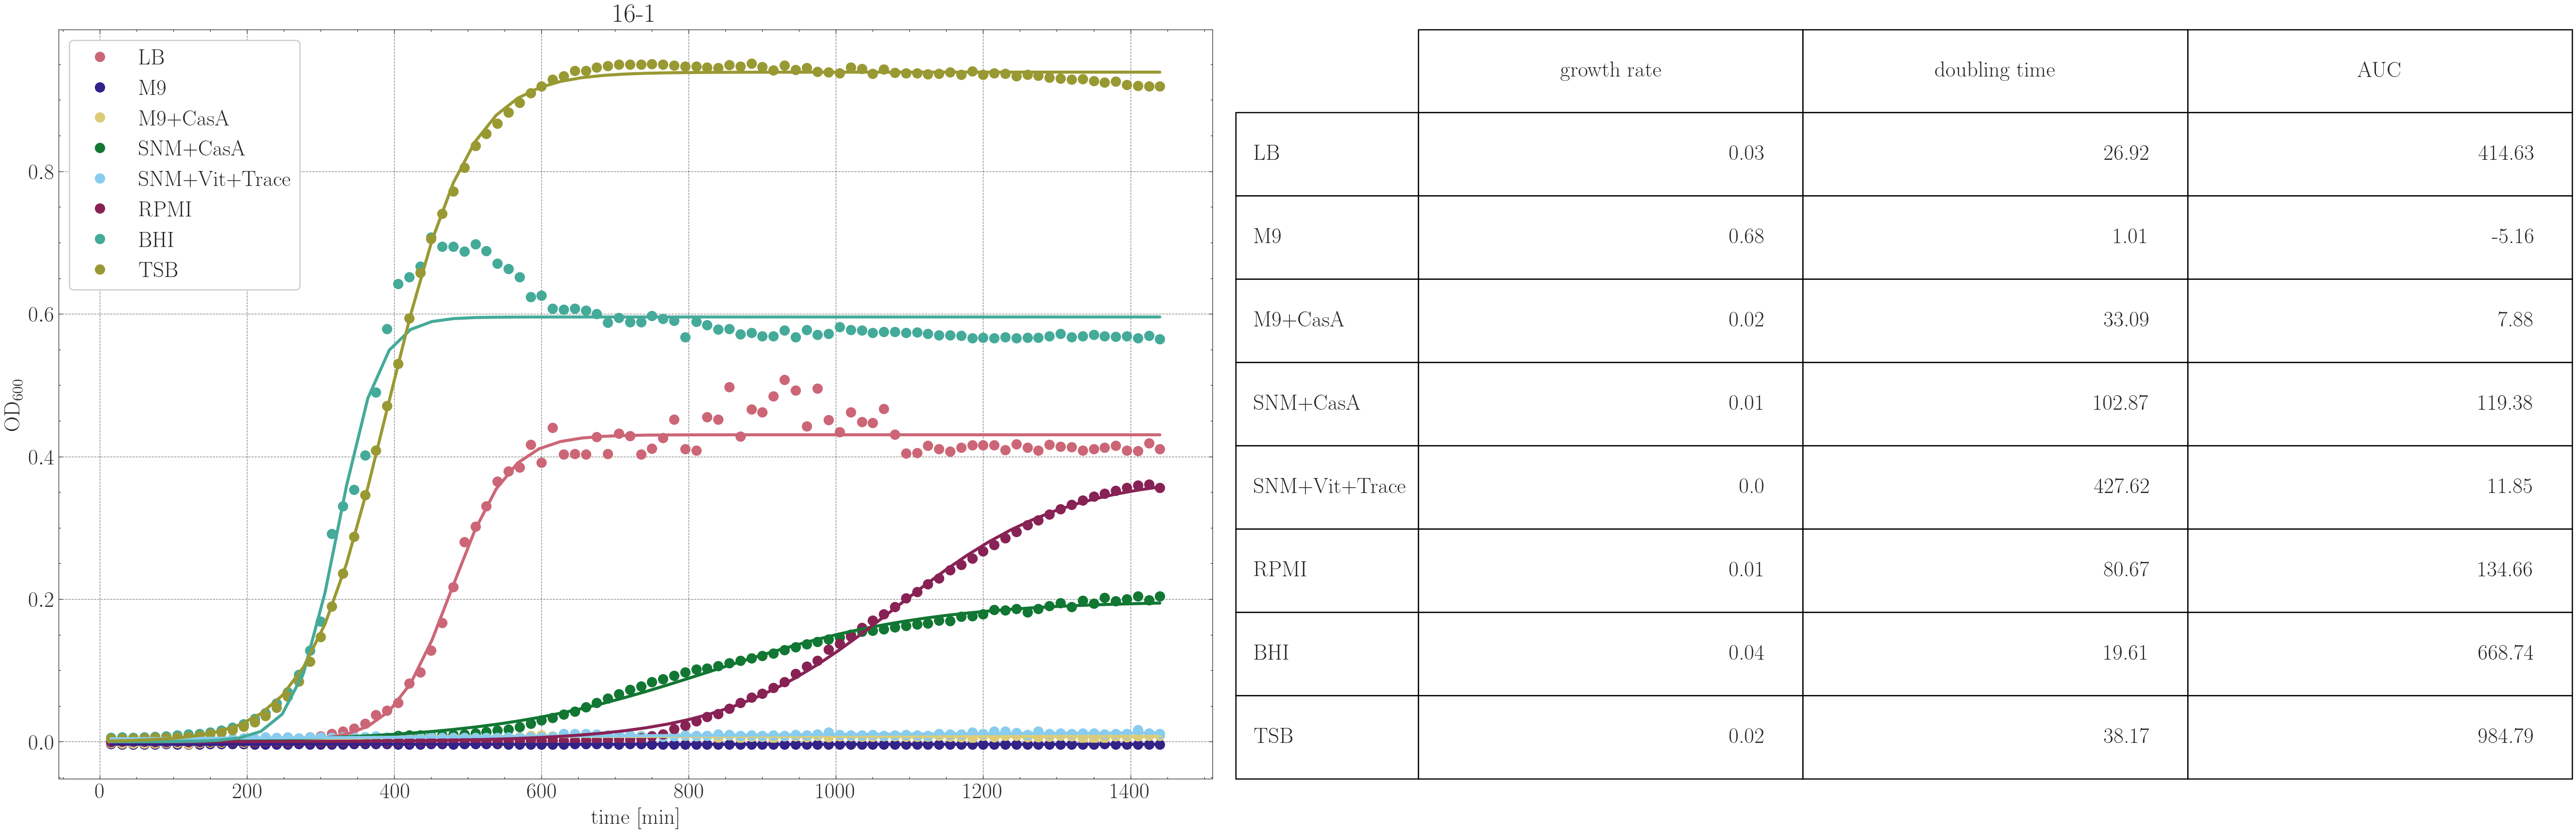

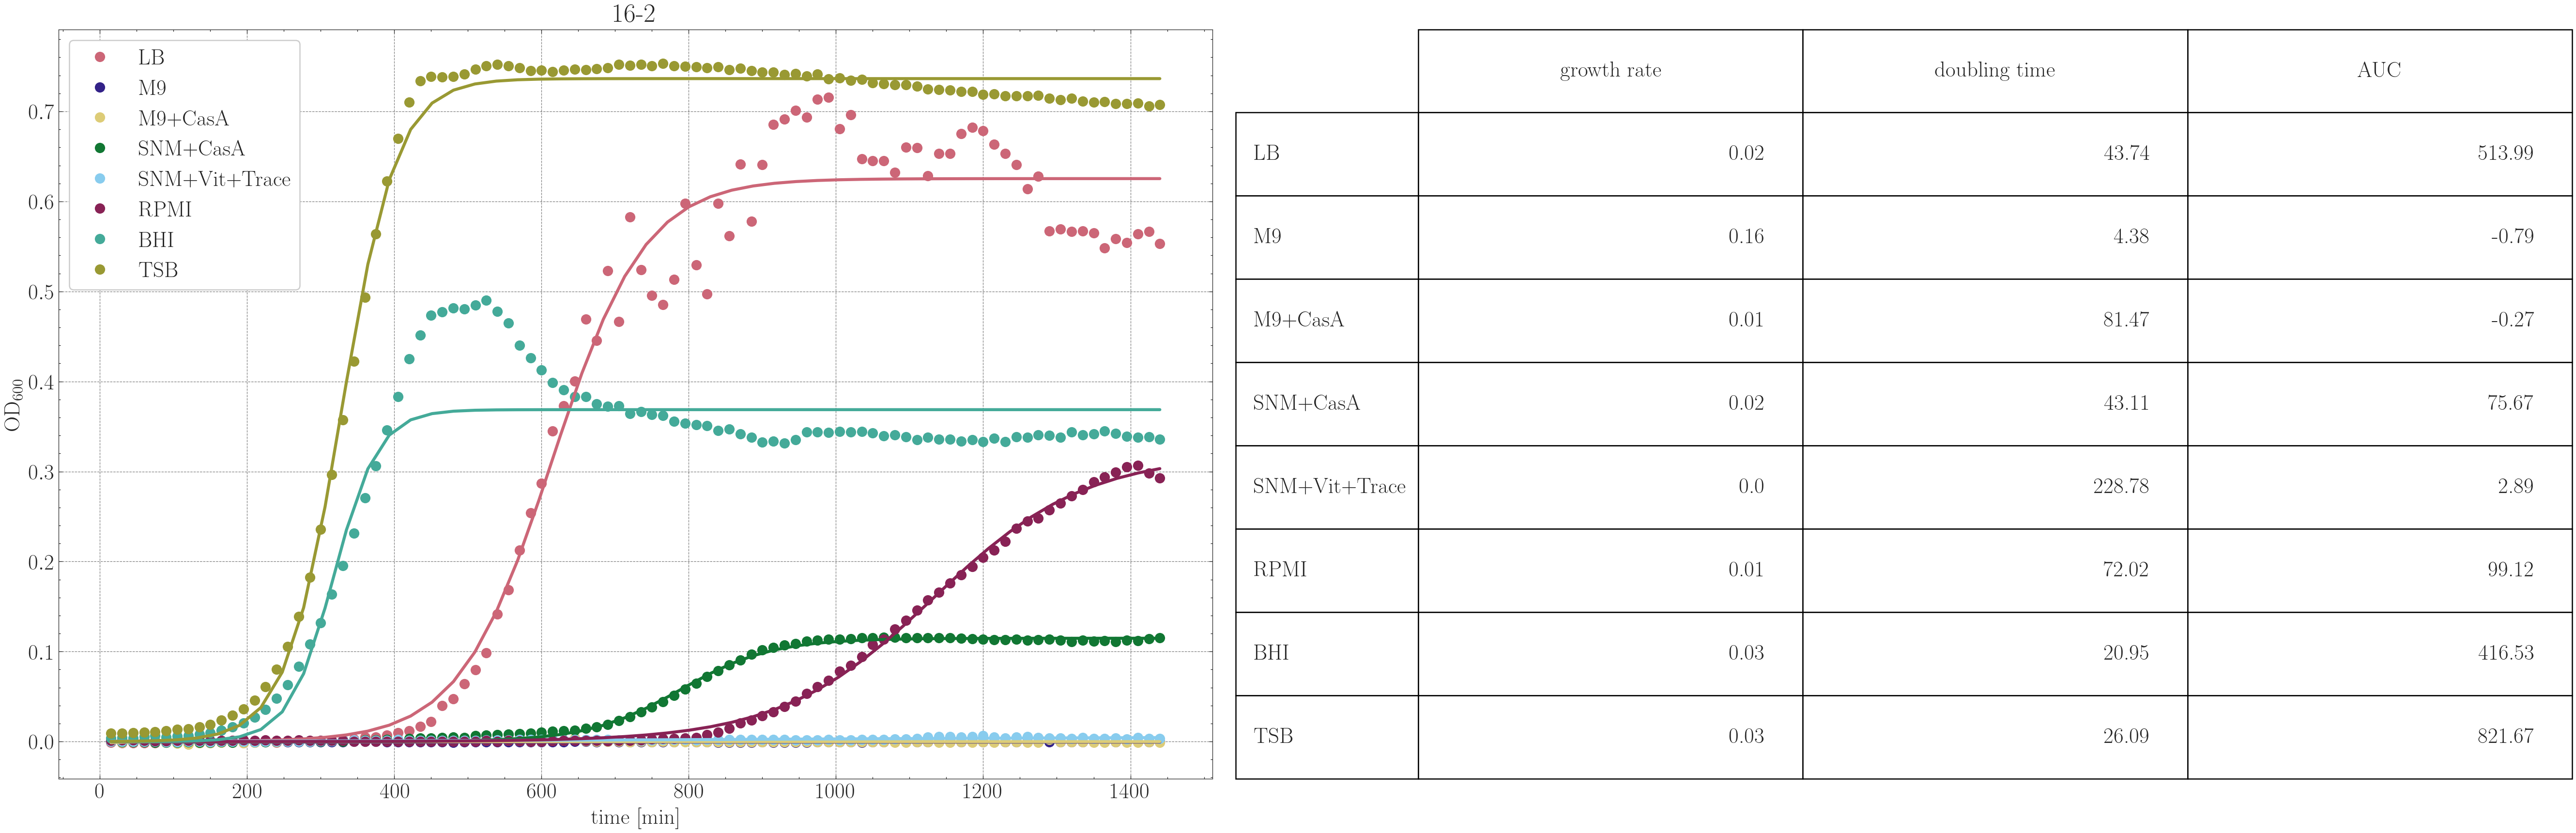

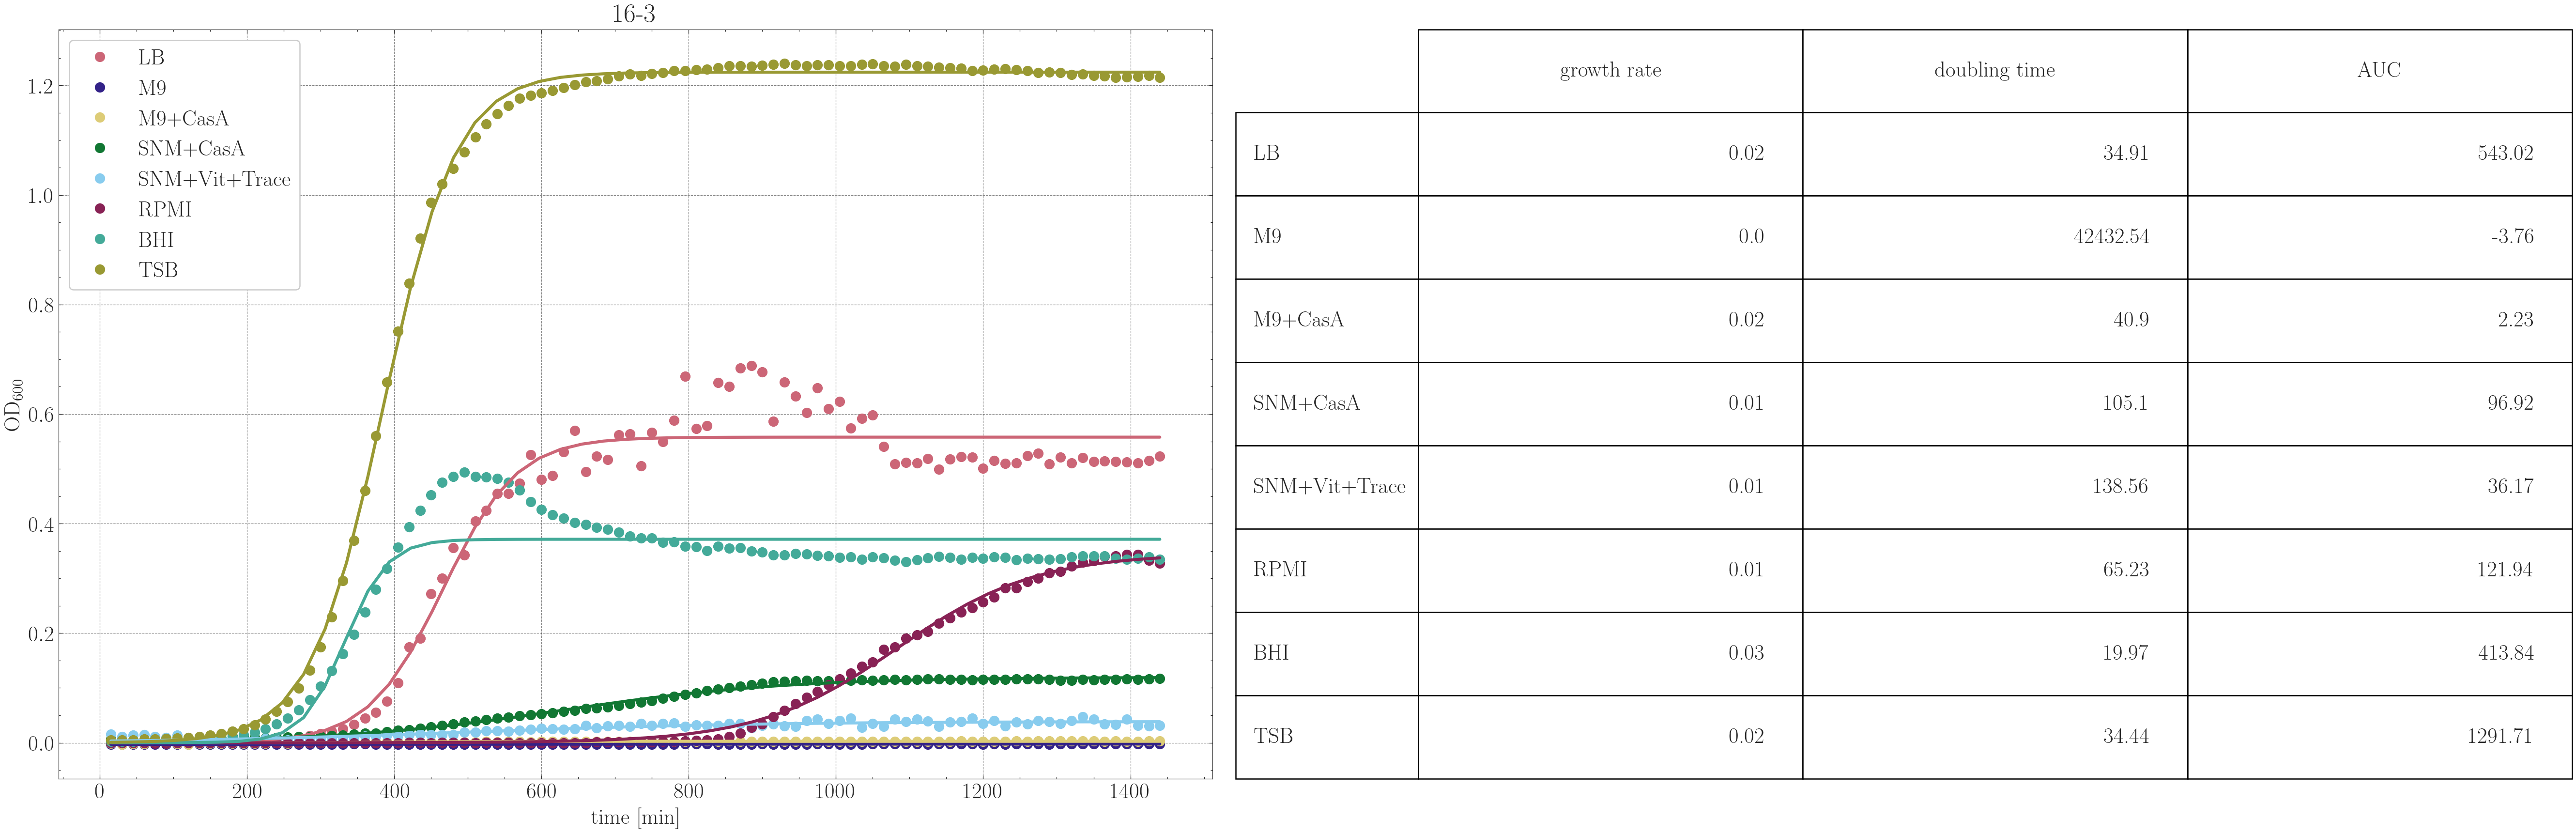

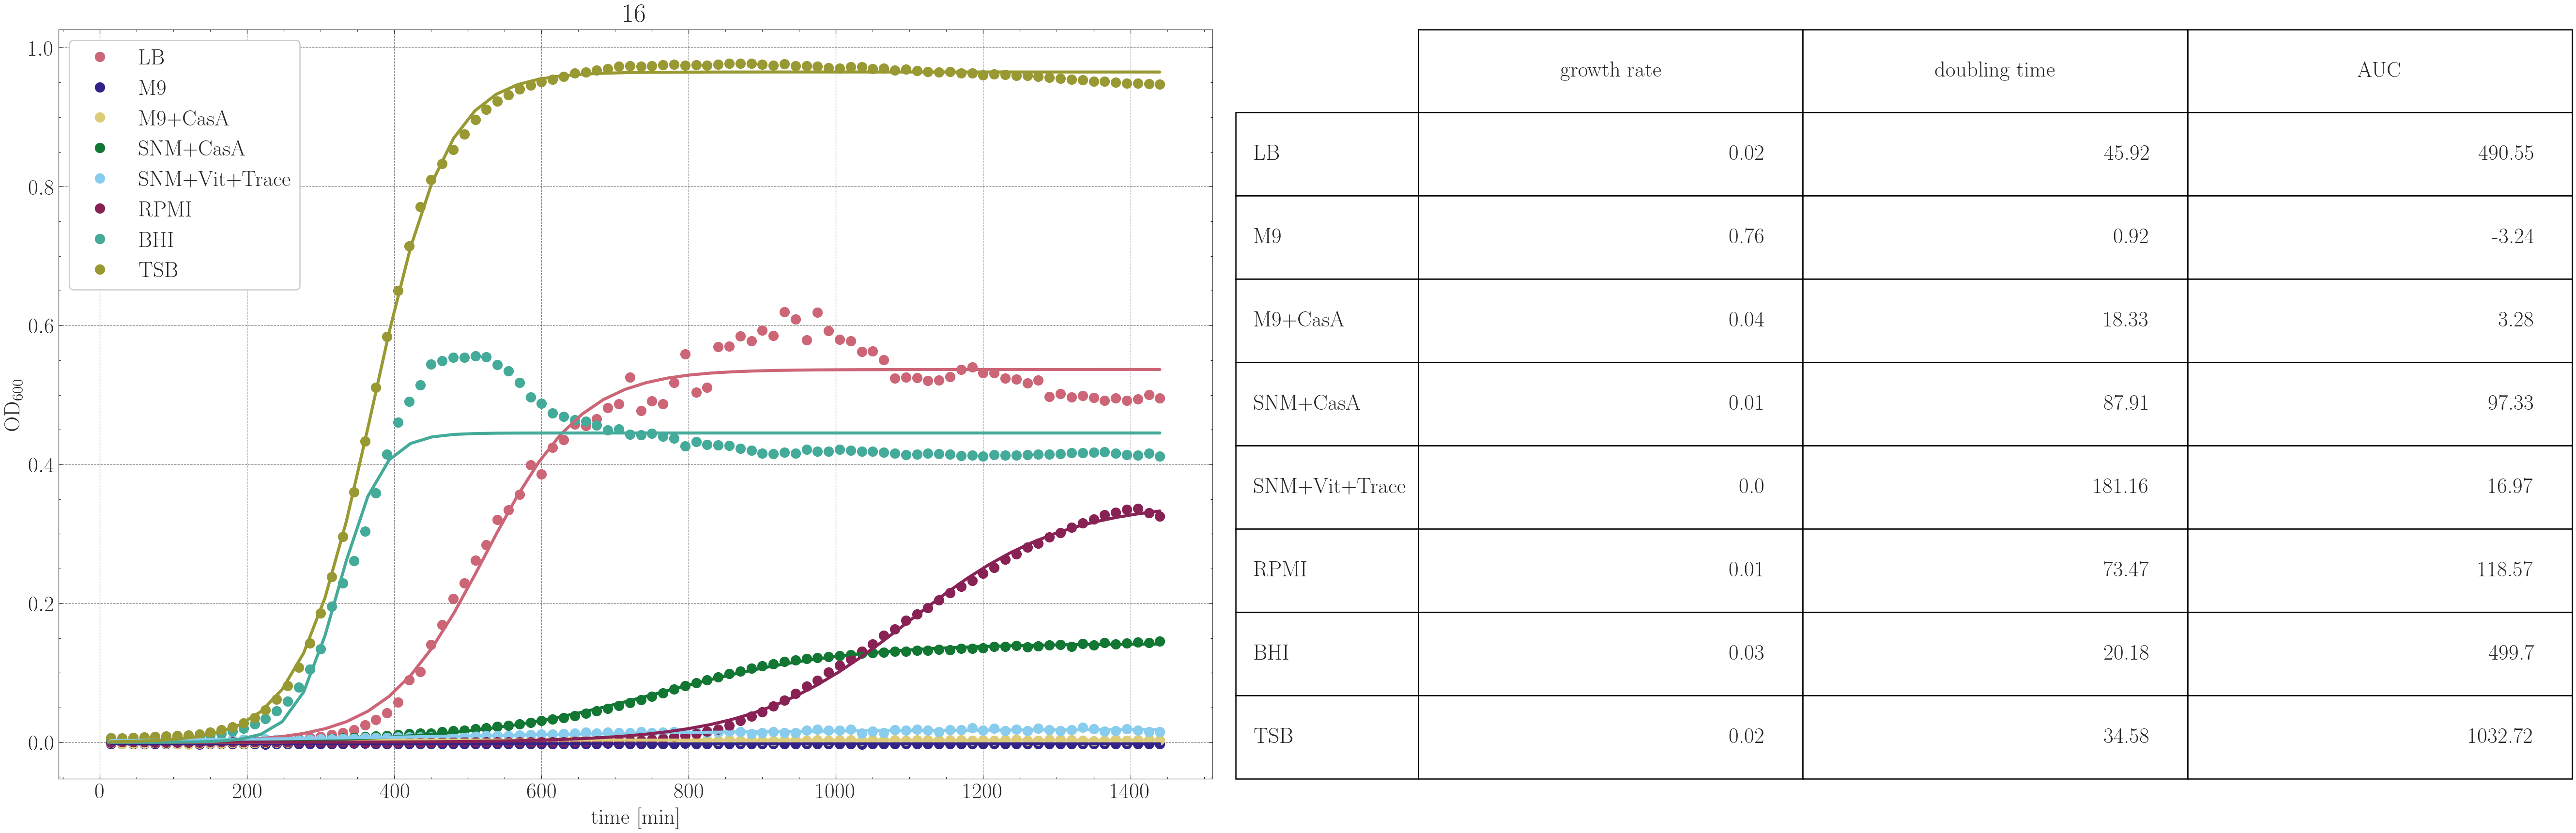

In [107]:
plt.close('all')
fit_func = logistic_mod
for strain, dataframe in growth.items():
    df_growth, fit_params = extract_growthrate(dataframe, fit_func)
    plot_fitted_curves(dataframe, fit_func, fit_params, strain, df_growth)

### Plotting biological replicates with errorbars

This only works with results from plates with biological replicates of the same strain. For other plates `errors` will be empty.

From averaging the biological replicates we also return a dataframe containing those errors (see `extract_columns`). This returns the mean, the standard deviation and the standard error and looks as shown below.

In [108]:
errors[['Time', 'LB']].head()

Time                        LB                     
   mean double_std  sem      mean double_std       sem
0  15.0        0.0  0.0  0.000444   0.002200  0.000778
1  30.0        0.0  0.0  0.000222   0.002266  0.000801
2  45.0        0.0  0.0 -0.000111   0.002266  0.000801
3  60.0        0.0  0.0  0.000111   0.002740  0.000969
4  75.0        0.0  0.0 -0.000556   0.001750  0.000619

We can plot those errors using the `plt.errorbar` function.

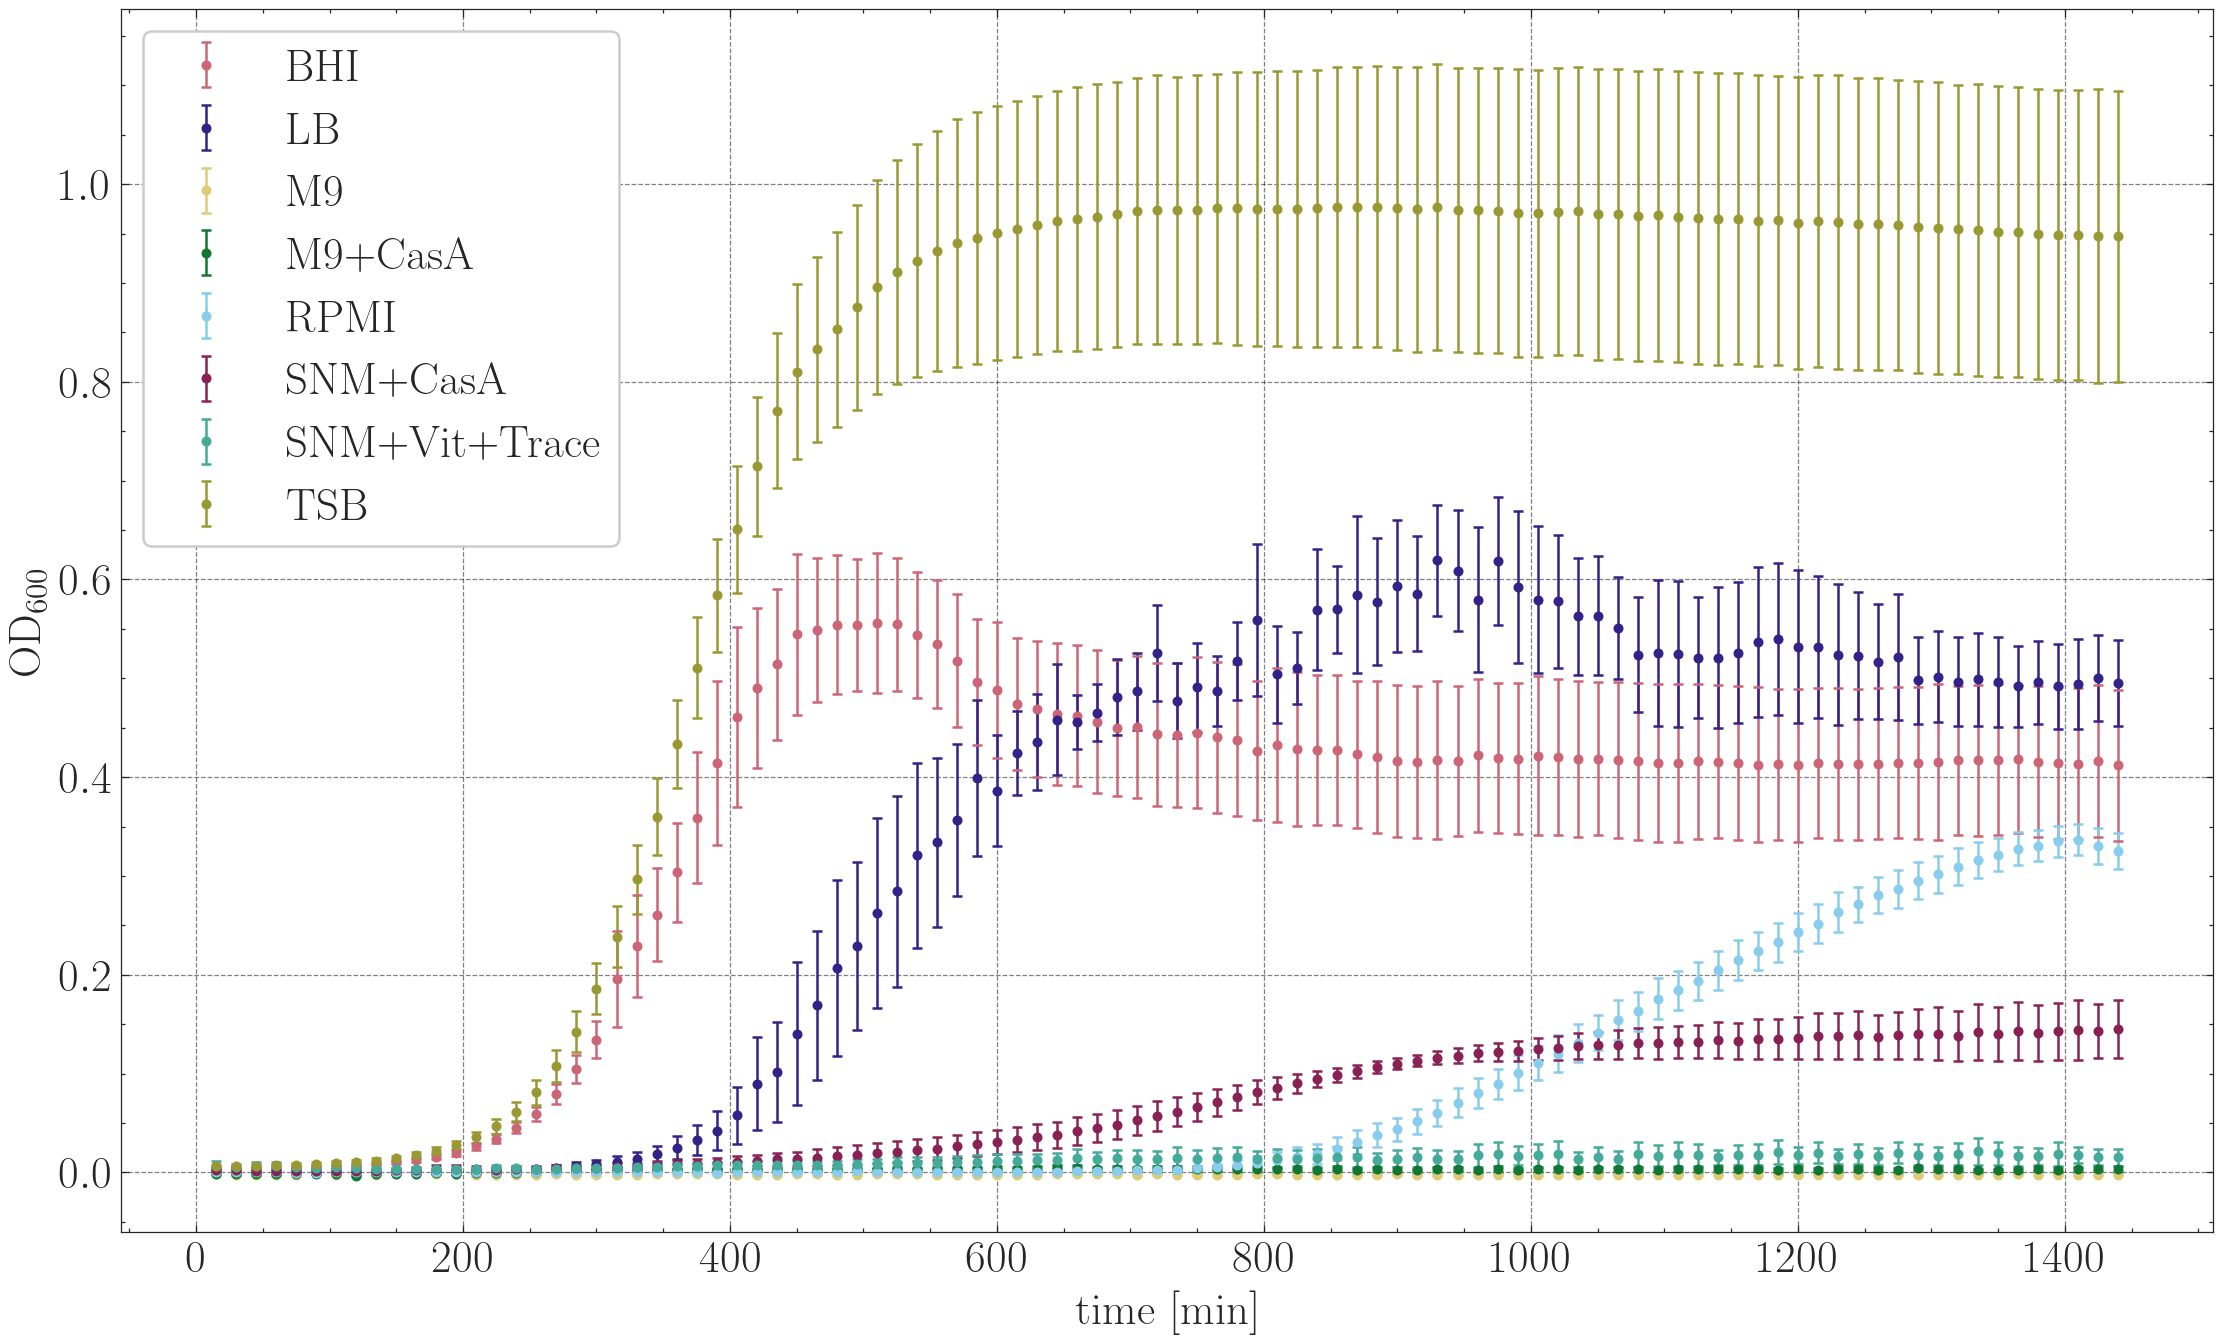

In [109]:
plt.close('all')
fig = plt.figure(figsize=(15, 9))
for medium, values in errors.groupby(level = 0, axis=1):
    if medium == 'Time':
        pass
    else:
        plt.errorbar(x = errors['Time']['mean'],
                    y = values[medium]['mean'],
                    yerr = values[medium]['sem'],
                    capsize=2, 
                    elinewidth=1,
                    fmt='.',
                    label=medium,
                    markeredgewidth=1,
                    )
        #plt.yscale('log', nonpositive='clip')
        plt.xlabel('time [min]')
        plt.ylabel('OD$_{600}$')
        plt.grid(True)
        plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

One step further is to also display the fit.

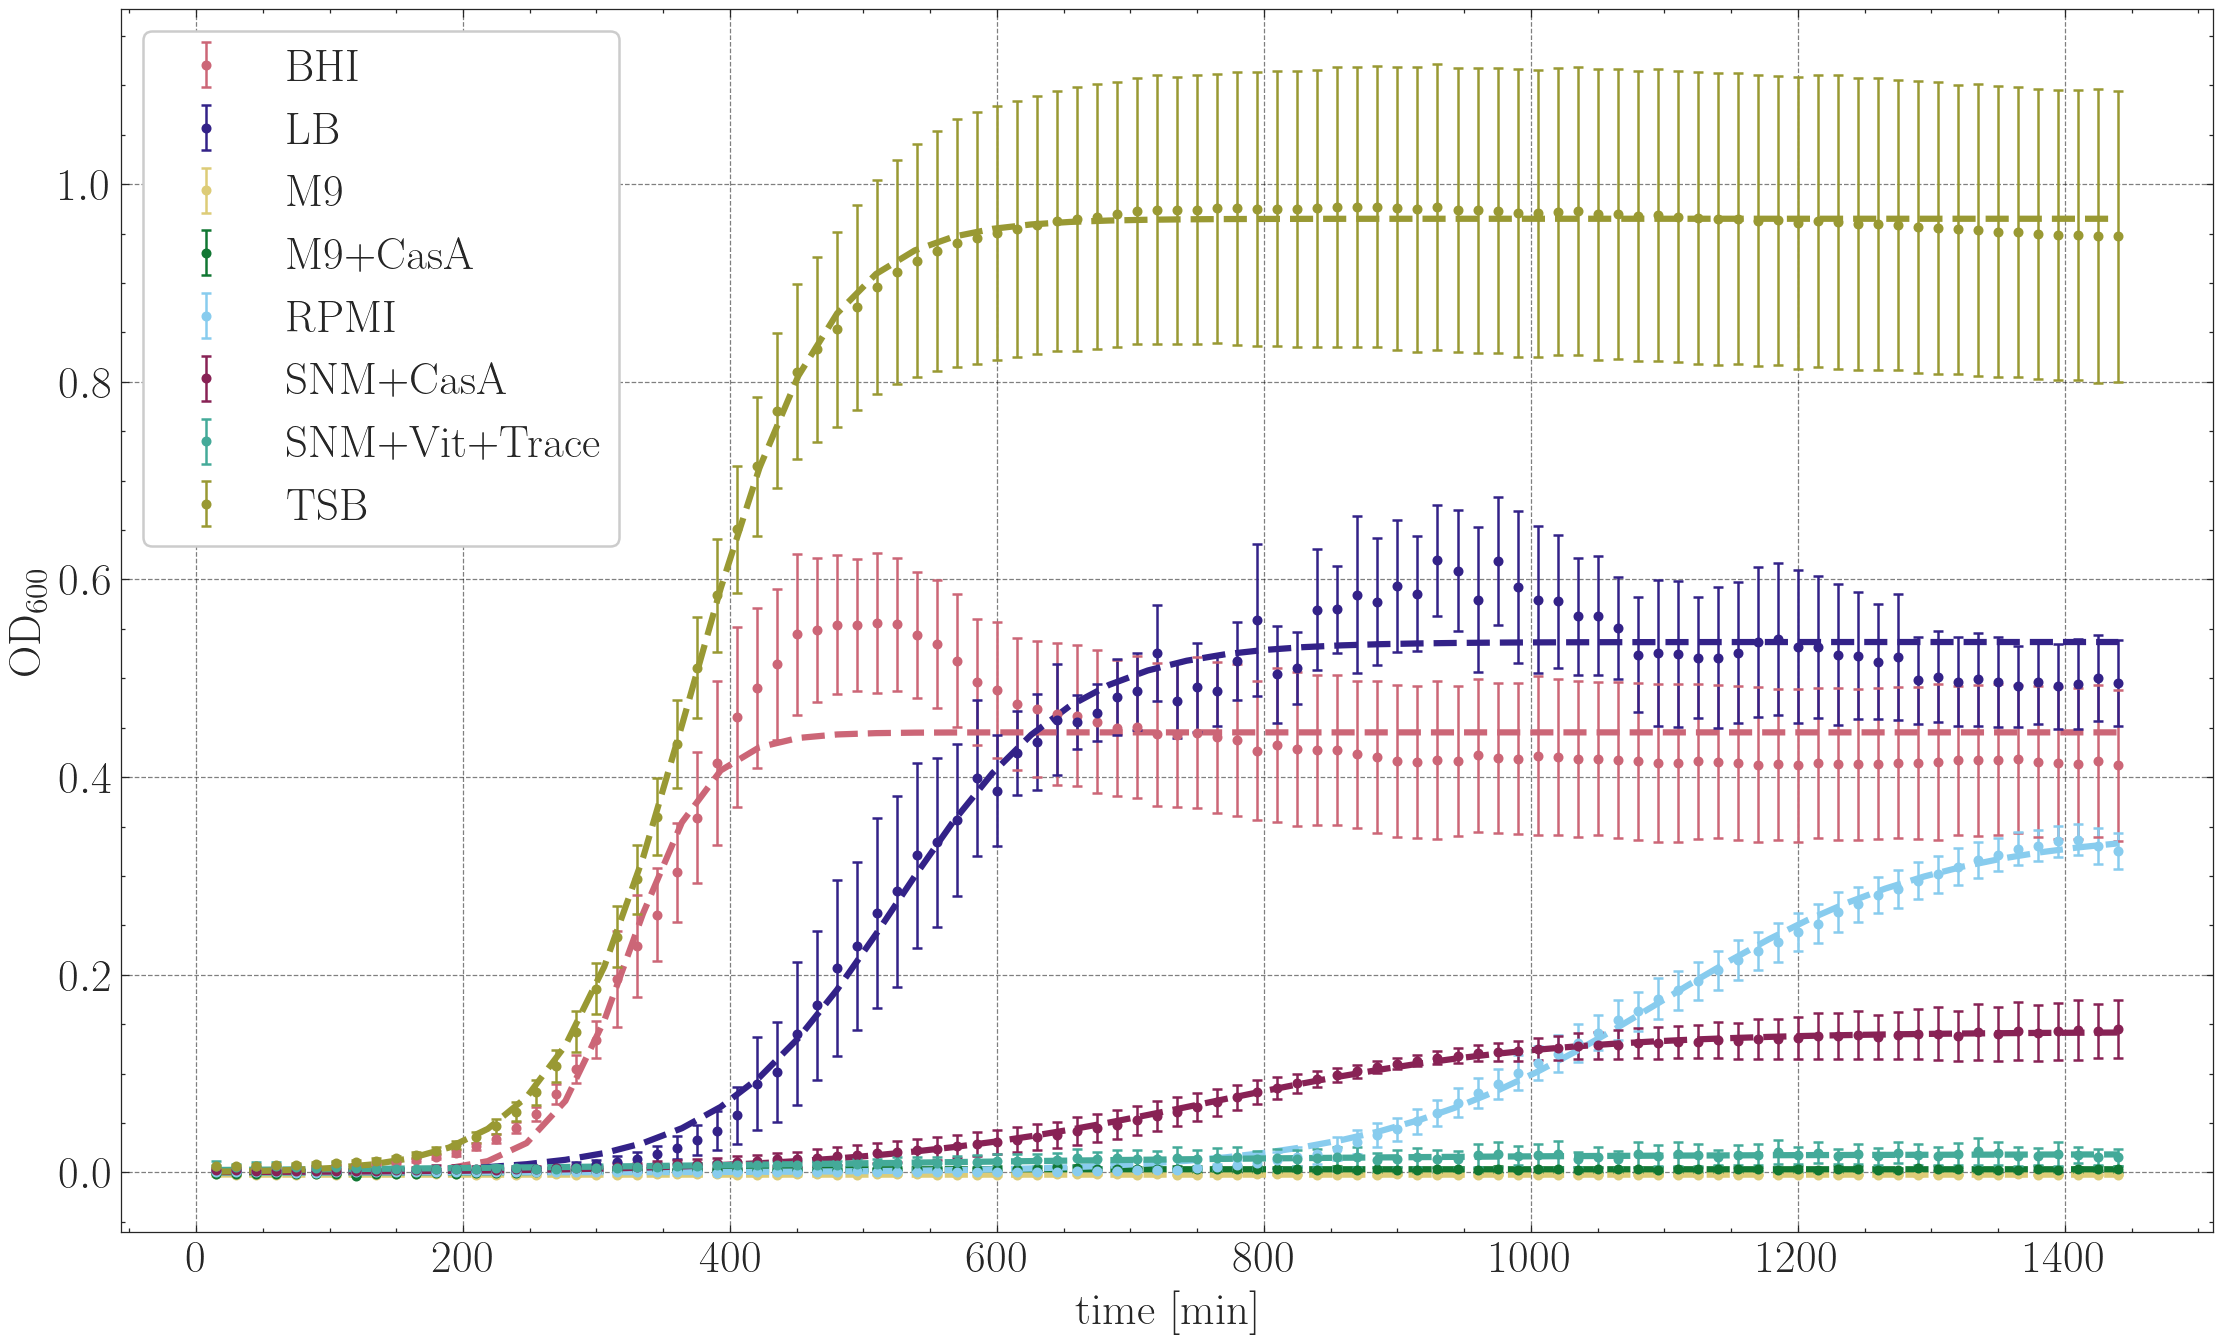

In [110]:
plt.close('all')
fit_func = logistic_mod
fig = plt.figure(figsize=(15, 9))
for medium, values in errors.groupby(level = 0, axis=1):
    if medium == 'Time':
        pass
    else:
        df_growth, fit_params = extract_growthrate(values[medium].assign(Time=pd.Series(errors['Time']['mean'])), fit_func)
        t = np.linspace(errors['Time']['mean'].min(), errors['Time']['mean'].max())
        lines = plt.plot(t,fit_func(t, *fit_params.loc['mean']), '--')
        plt.errorbar(x = errors['Time']['mean'],
                   y = values[medium]['mean'],
                   yerr = values[medium]['sem'],
                   capsize=2, 
                   elinewidth=1,
                   fmt='.',
                   label=medium,
                   markeredgewidth=1,
                   color = lines[0].get_color(), # use same color for fit as for data
                   )
        #plt.yscale('log', nonpositive='clip')
        plt.xlabel('time [min]')
        plt.ylabel('OD$_{600}$')
        plt.grid(True)
        plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))

## Focus: One medium for different strains

### Average all measurements per strain

Multiple measurements were made at different time points using the same medium. To get a general overview on how the strains behave these measurements can be averaged using a list of media of interest. As done below the averaged biological replicates from one plate are taken into account as one measurement. The first part collects all data into the dictionary `all_exp_by_medium`.

In [111]:
path_to_excel = 'plate_reader_results/'
media = ['M9', 'TSB', 'BHI', 'LB', 'RPMI', 'SNM(+Vit)', 'SNM+Vit+Trace', 'M9+CasA', 'SNM+CasA']

all_exp_by_medium = {}
for medium in media:
    strains = {}
    for date, layout in convert_layout().items():
        excel_file = str(date) + '_Cstr.xlsx'
        nrows, plate_layout, bio_rep_name, nice_date = get_info(excel_file)
        df = pd.read_excel(path_to_excel+excel_file, usecols="B:CU", skiprows=57, nrows=nrows)
        growth, df_errors = extract_columns(df, plate_layout, plate_layout['biological replicates'], bio_rep_name)

        for strain, curves in growth.items():
            if len(strain) > 2:
                pass
            else:
                if strain not in strains:
                    strains[strain] = pd.DataFrame(curves['Time'])
                    try:
                        strains[strain][medium + ' ' + str(date)] = curves[medium]
                    except (KeyError):
                        #print(medium + ' not there')
                        pass
                elif strain in strains:
                    try:
                        strains[strain][medium + ' ' + str(date)] = curves[medium]
                    except (KeyError):
                        #print(medium + ' not there')
                        pass
    all_exp_by_medium[medium] = strains

Afterwards the data of one strain on one medium can be averaged and then plotted into a plot with the averages of the other media.

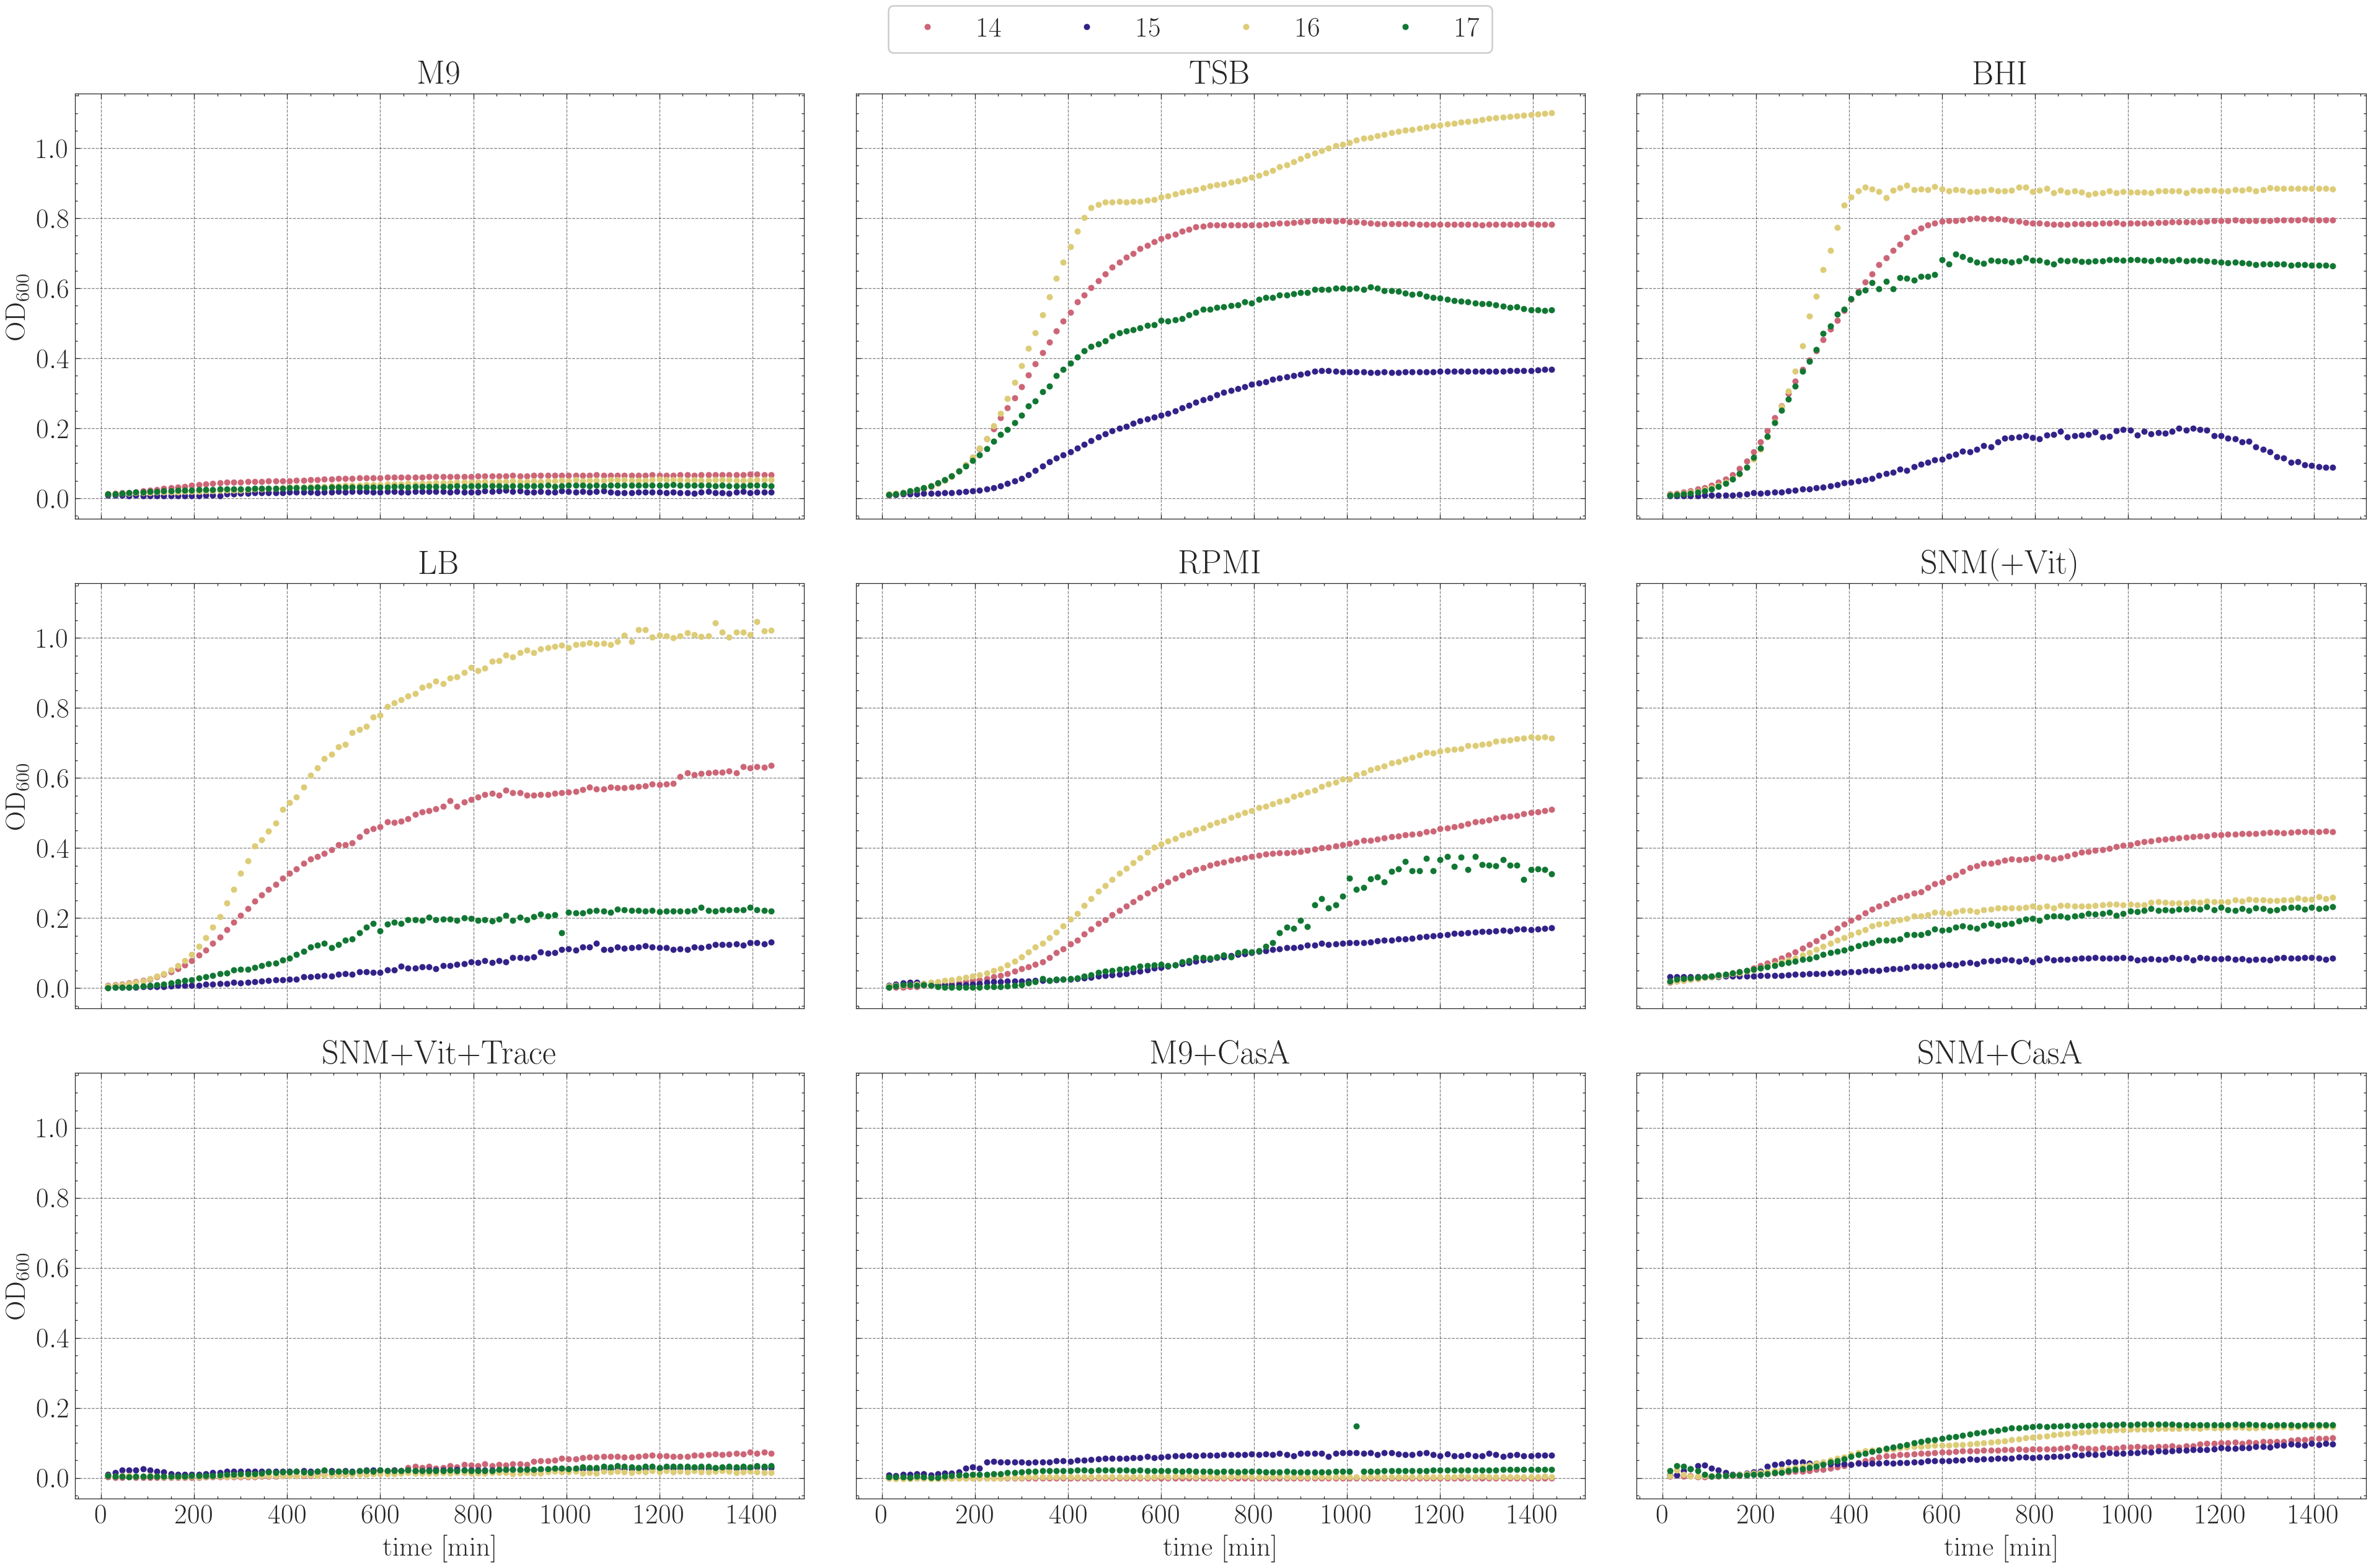

In [112]:
plt.close('all')
plot_number = 0
fig, axs = plt.subplots(3,3, figsize=(22, 14), facecolor='w', edgecolor='k', sharex=True, sharey=True)
axs = axs.ravel()
media_avg = {}

for medium, strains in  all_exp_by_medium.items():
    medium_avg = pd.DataFrame()
    for strain, data in strains.items():
        medium_avg['Time'] = data['Time']
        data['mean'] = data.drop('Time', axis=1).mean(axis=1)
        medium_avg[strain] = data['mean']
    media_avg[medium] = medium_avg   
        
    medium_avg.plot(grid=True, 
                x="Time",
                style = '.',
                xlabel='time [min]',
                ylabel='OD$_{600}$',
                title = medium,
                ax=axs[plot_number],
                legend=False,
                #color=colorstandards,
                #logy=True,
                #logx=True
                )
    handles, labels = axs[plot_number].get_legend_handles_labels()
    plot_number += 1
    
plt.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(0, 0.95, 1, .102), loc='center', ncol=4)

### Fitting the averaged strain data

We can use this averaged data to fit again our function of interest and display the fit results.

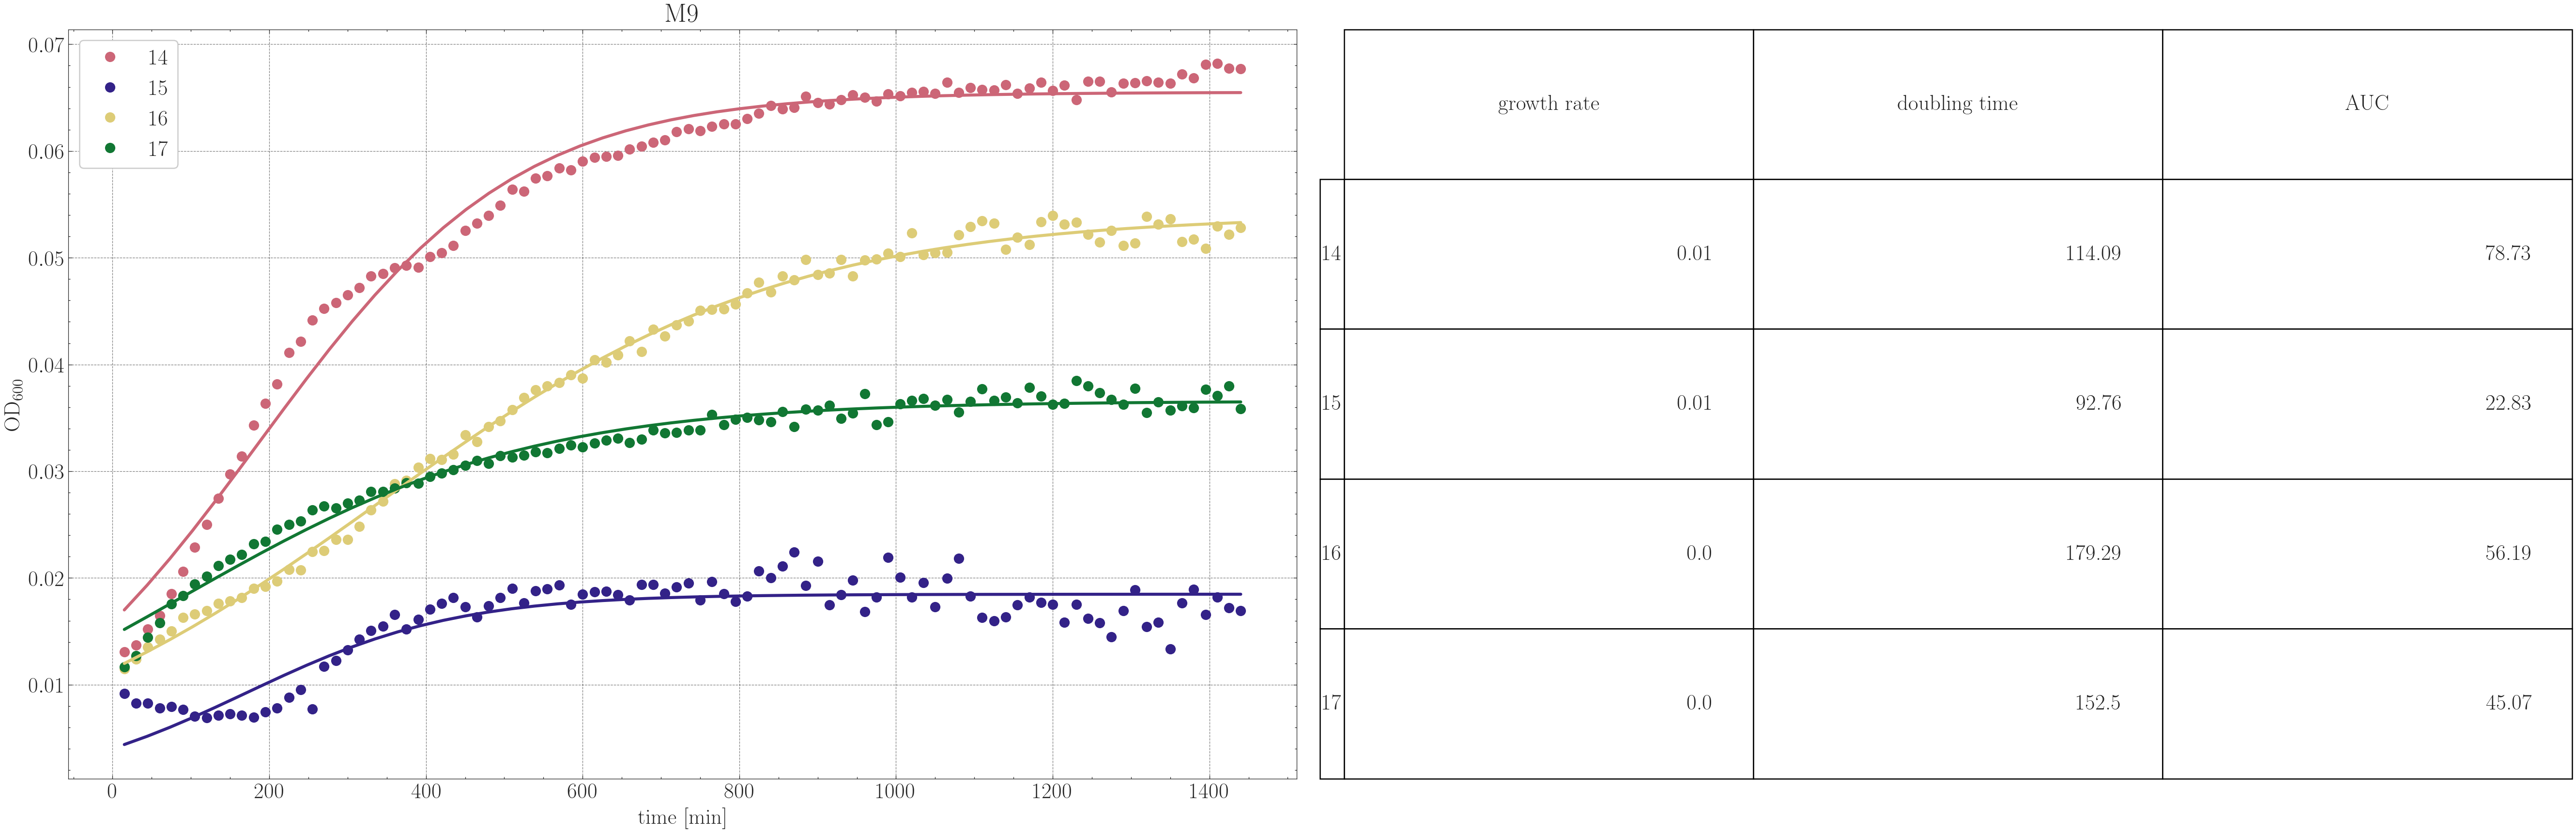

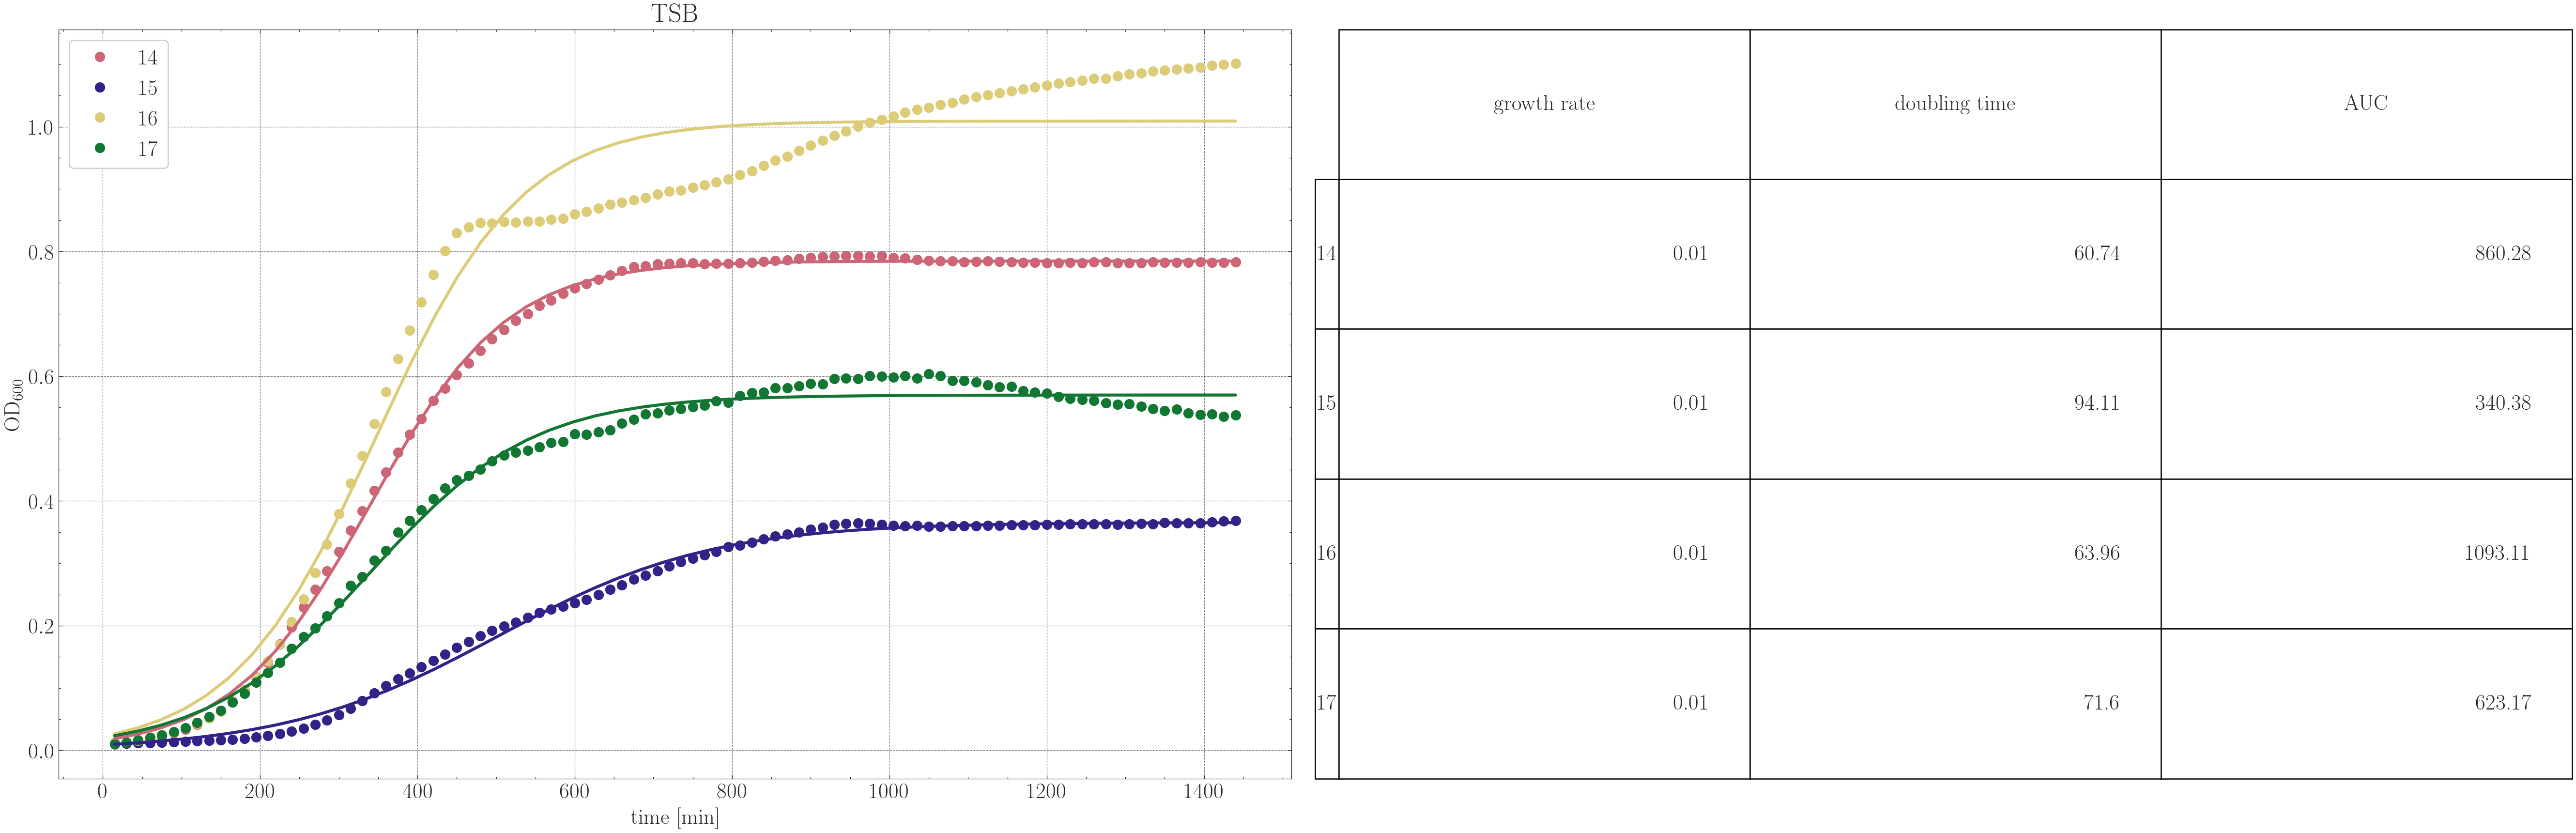

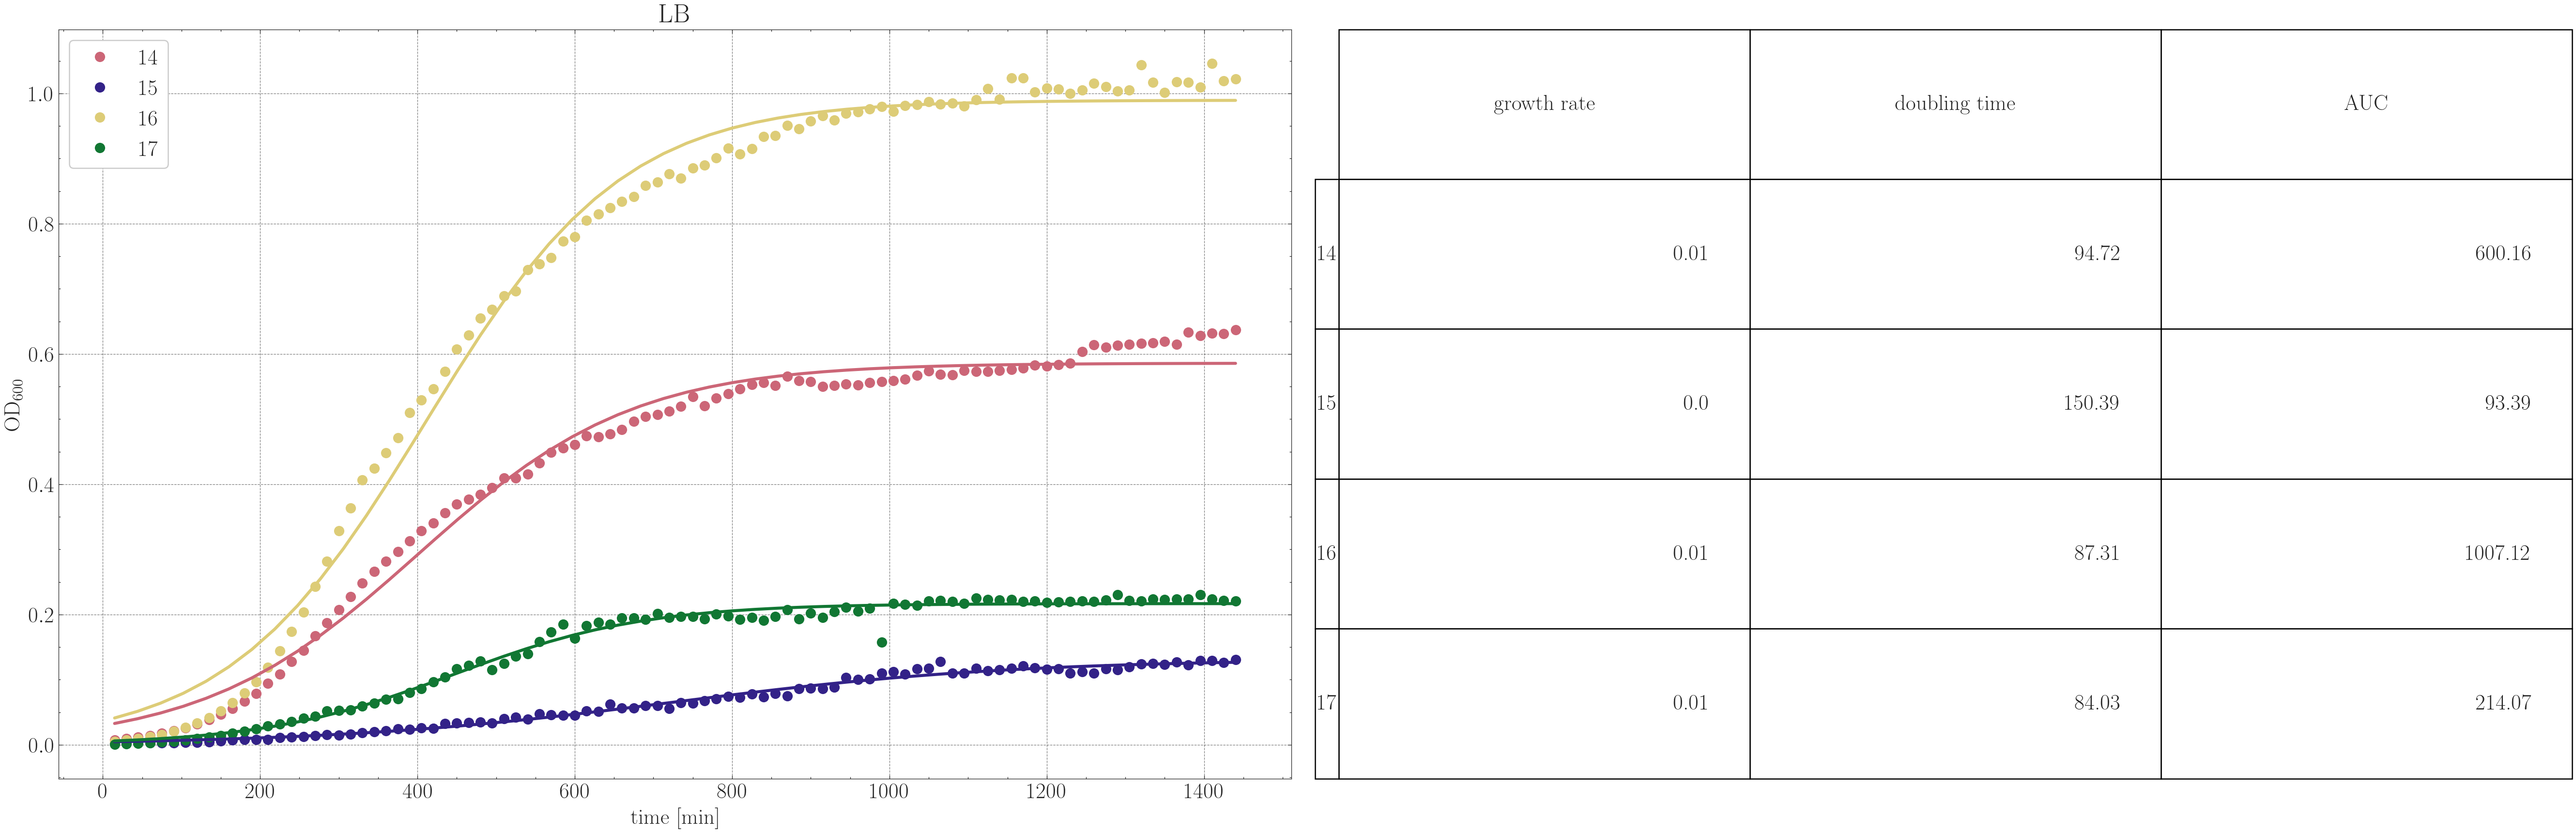

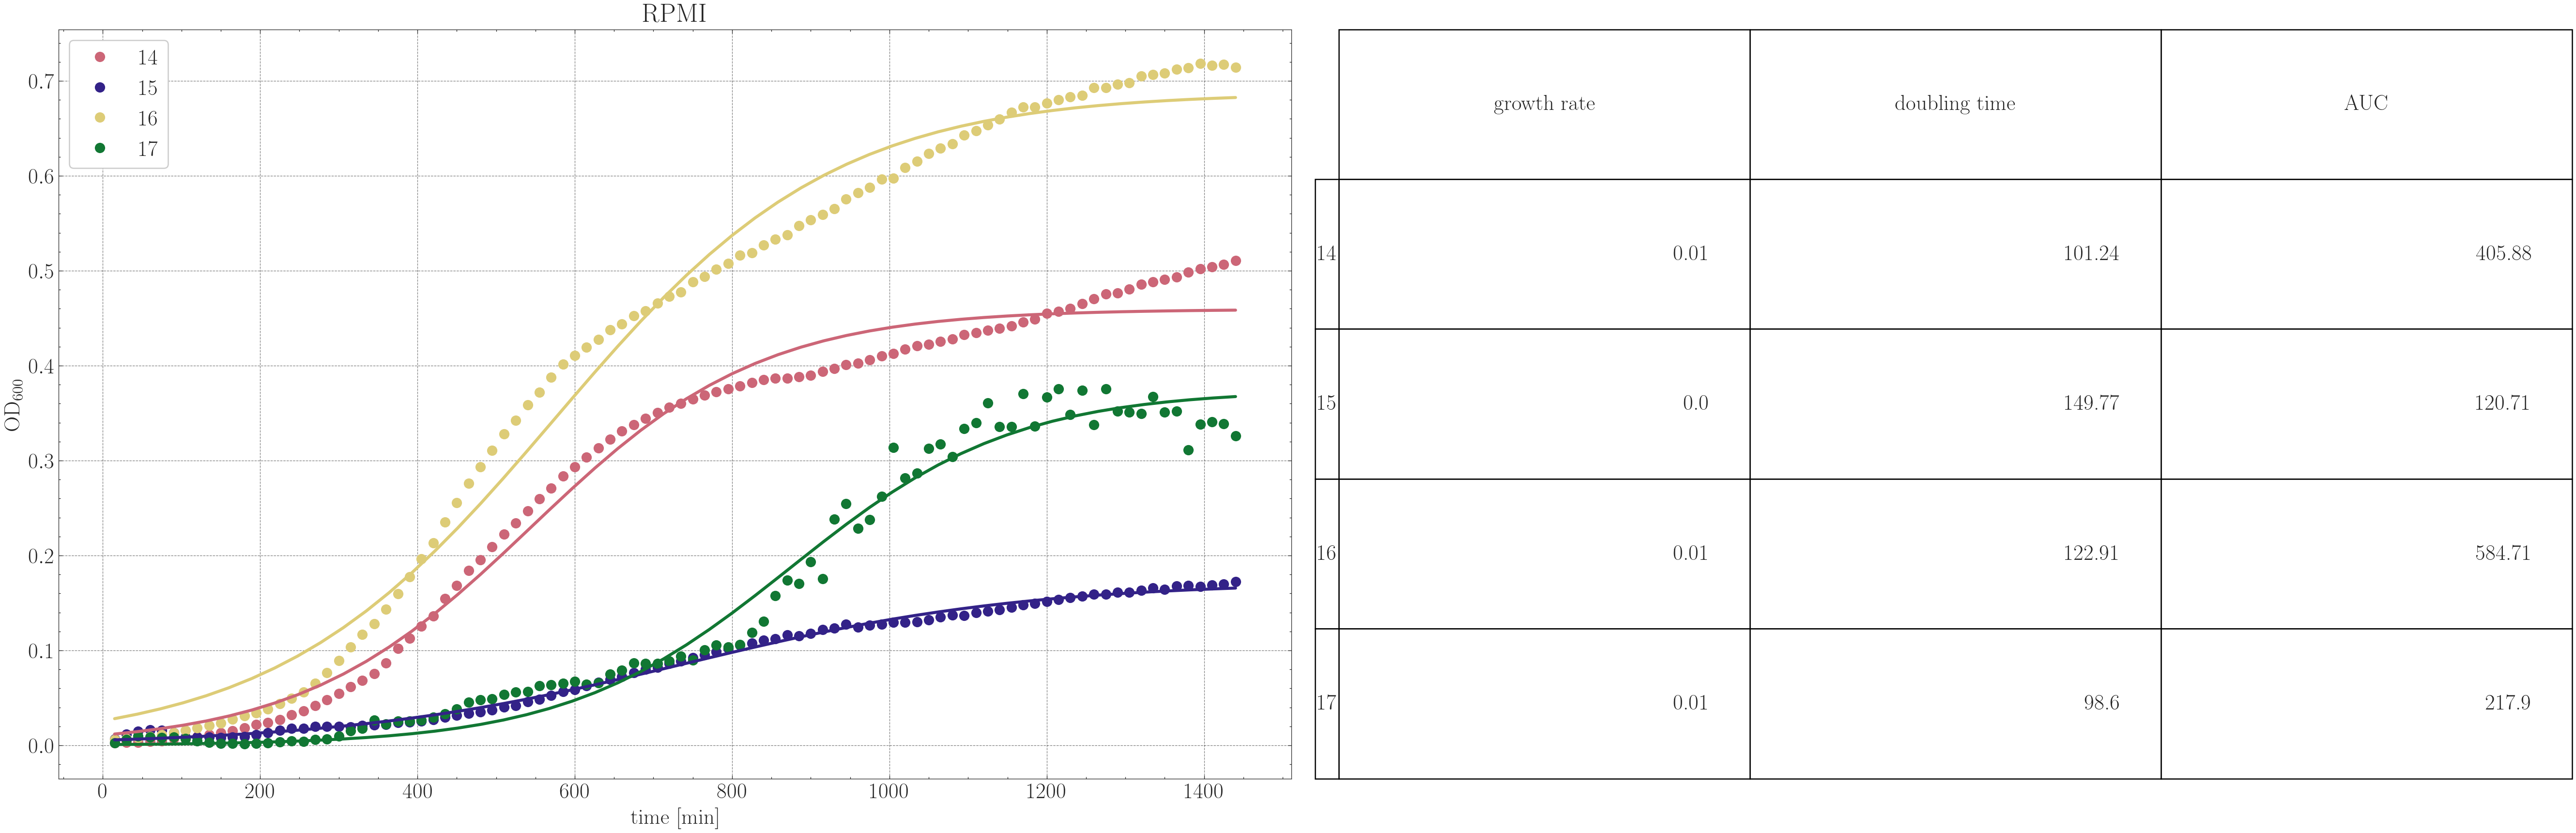

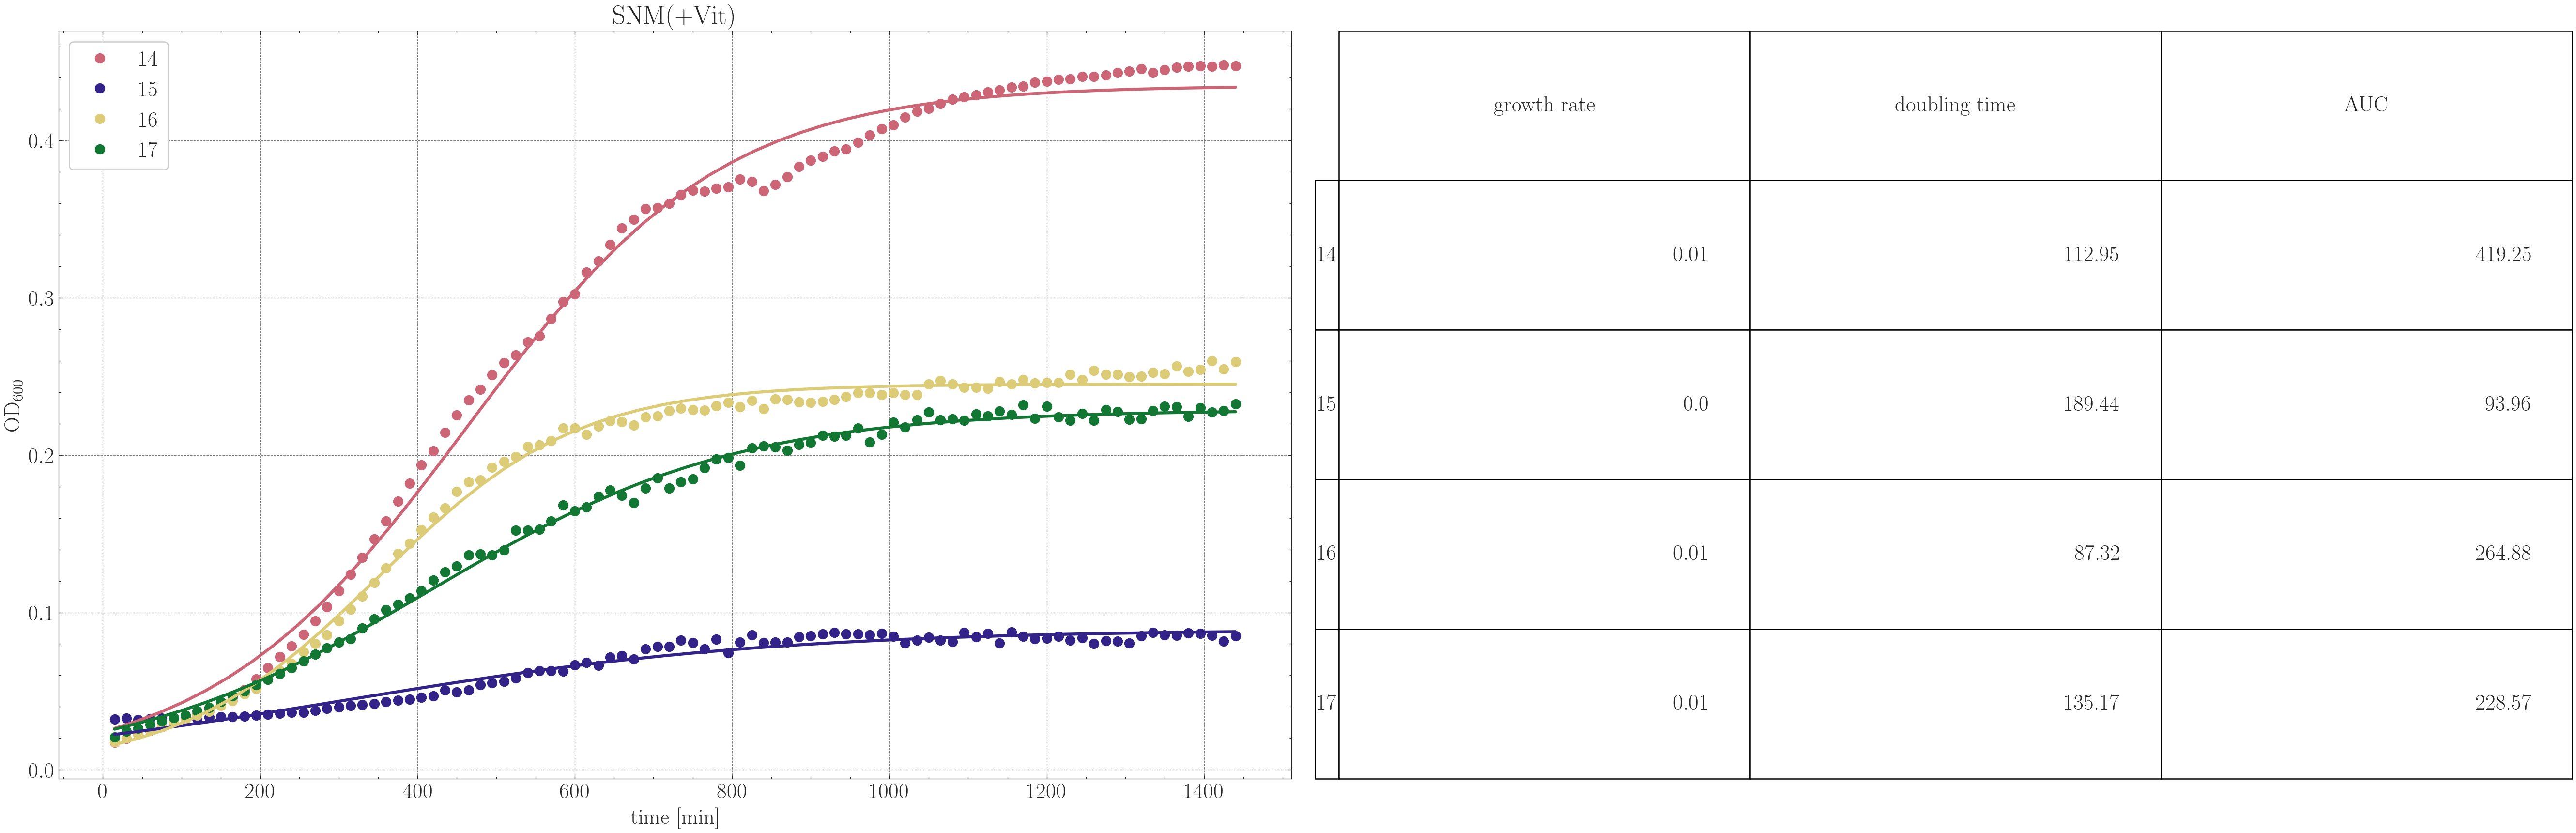

In [113]:
plt.close('all')
chosen_media = ['M9', 'TSB', 'LB', 'RPMI', 'SNM(+Vit)']
fit_func = logistic_mod
for medium, data in media_avg.items():
    if medium in chosen_media:
        growth_params, fit_params = extract_growthrate(data, fit_func)
        plot_fitted_curves(data, fit_func, fit_params, medium, growth_params)

## Focus: Comparing growth rate extraction methods

Extracting doubling times from growth curves is usually done by taking two points within the exponential phase, fitting a line through and using the gradient as growth rate in $\tfrac{OD}{time}$. Growth rates from simulations with COBRApy are given in $\tfrac{mmol}{gDW \cdot h}$. The easiest way to bring those into comparable units is by calculating the doubling time. This approach was taken for all comparisons.

Selecting two points within the exponential phase will always be biased by the researchers expertise and imagination how the exponential phase has to look like. Fitting with similar starting values will lead to the same growth rates, while the conventional method might differ between researchers. 


Lets use one sample dataset to compare different ways of fitting growth curves. First we extract and save so we can load it later again.

In [114]:
#growth['16'][['Time', 'LB']].to_csv('plate_reader_results/220615_Cstr16_LB_avg.csv', index=False)
growth_sample = pd.read_csv('plate_reader_results/220615_Cstr16_LB_avg.csv')
growth_sample.head()

Time        LB
0  15.0  0.000444
1  30.0  0.000222
2  45.0 -0.000111
3  60.0  0.000111
4  75.0 -0.000556

Now we define different models / functions of interest.

In [115]:
def gompertz(t,K,lag,r): #based on Franses94 and Korkmaz2020
    return K*np.exp(-lag*np.exp(-r*t))

def logistic(t, K, N0, r): #asadi2020
    return K/(1+((K-N0)/N0)*np.exp(-r*t))

def richards(t, K, beta, y0, r): #richards1959
    return K*(1-np.exp(-beta * r * t)*(1-(y0/K)**(-beta)))**(-1/beta)

def baranyi(t, K, h0, y0, r): #Baranyi, J. and Roberts, T. A. (1994)
    A = t + 1/r * np.log(np.exp(-r * t) + np.exp(-h0) - np.exp(-r * t - h0))
    return np.exp(np.log(y0) + r * A - np.log(1 + (np.exp(r * A) - 1) / np.exp(np.log(K) - np.log(y0))))

def huang(t, K, alpha, lam, y0, r): #Huang, Lihan (2008)
    B = t + 1/alpha * np.log((1+np.exp(-alpha * (t - lam)))/(1 + np.exp(alpha * lam)))
    return np.exp(np.log(y0) + np.log(K) - np.log(y0 + (K - y0) * np.exp(-r * B)))

Only the logistic and the gompertz equation are easiliy fitted using curve_fit. The richards equation works sometimes. The baranyi and huang equation are hard to fit with curve_fit.

In [116]:
def plot_different_fits(growth_sample, yscale, t1, t2, colname, newname):
    t = np.linspace(growth_sample['Time'].min(), growth_sample['Time'].max())
    models = [logistic, gompertz, richards]#, baranyi, huang]

    growth_sample.rename({colname:newname}, axis=1).plot(grid=True, 
                        x="Time",
                        style = '.',
                        xlabel='time [min]',
                        ylabel='OD$_{600}$',
                        legend=True,
                        figsize=(10, 7)
                        )
    for model in models:
        if model == richards:
            growth_params, fit_params = extract_growthrate(growth_sample, model, 
                                                           rename=['a', 'b', 'c', 'growth rate'],
                                                           p0=np.asarray([0.5,0.5,0.002,0.02]))
        elif model == baranyi:
            growth_params, fit_params = extract_growthrate(growth_sample, model, 
                                                           rename=['a', 'b', 'c', 'growth rate'],
                                                           p0=np.asarray([0.5,0.1,0.0001,0.05]))
        elif model == huang:
            growth_params, fit_params = extract_growthrate(growth_sample, model, 
                                                           rename=['a', 'b', 'c', 'd' , 'growth rate'],
                                                           p0=np.asarray([0.5,-0.002,1,0.005,0.05]))
        else:
            growth_params, fit_params = extract_growthrate(growth_sample, model)
        plt.plot(t, model(t, *fit_params.iloc[0]), '--', label=str(model.__name__ )
                 + ' fit: ' + str(growth_params.iloc[0]['doubling time'].round(2)) + ' min')

    od1 = float(growth_sample[growth_sample['Time'] == t1][colname])
    od2 = float(growth_sample[growth_sample['Time'] == t2][colname])
    
    td_conv = (np.log(2)/((np.log(od2)-np.log(od1))/(t2-t1))).round(2)
    plt.axline((t1, od1), (t2, od2), linestyle='--' , color='grey', label='conventional fit: ' + str(td_conv) + ' min')
    plt.ylim(10**-4, 1)
    if yscale == 'linear':
        plt.ylim(-0.05,0.9)
    plt.yscale(yscale)
    plt.legend()
    plt.show()

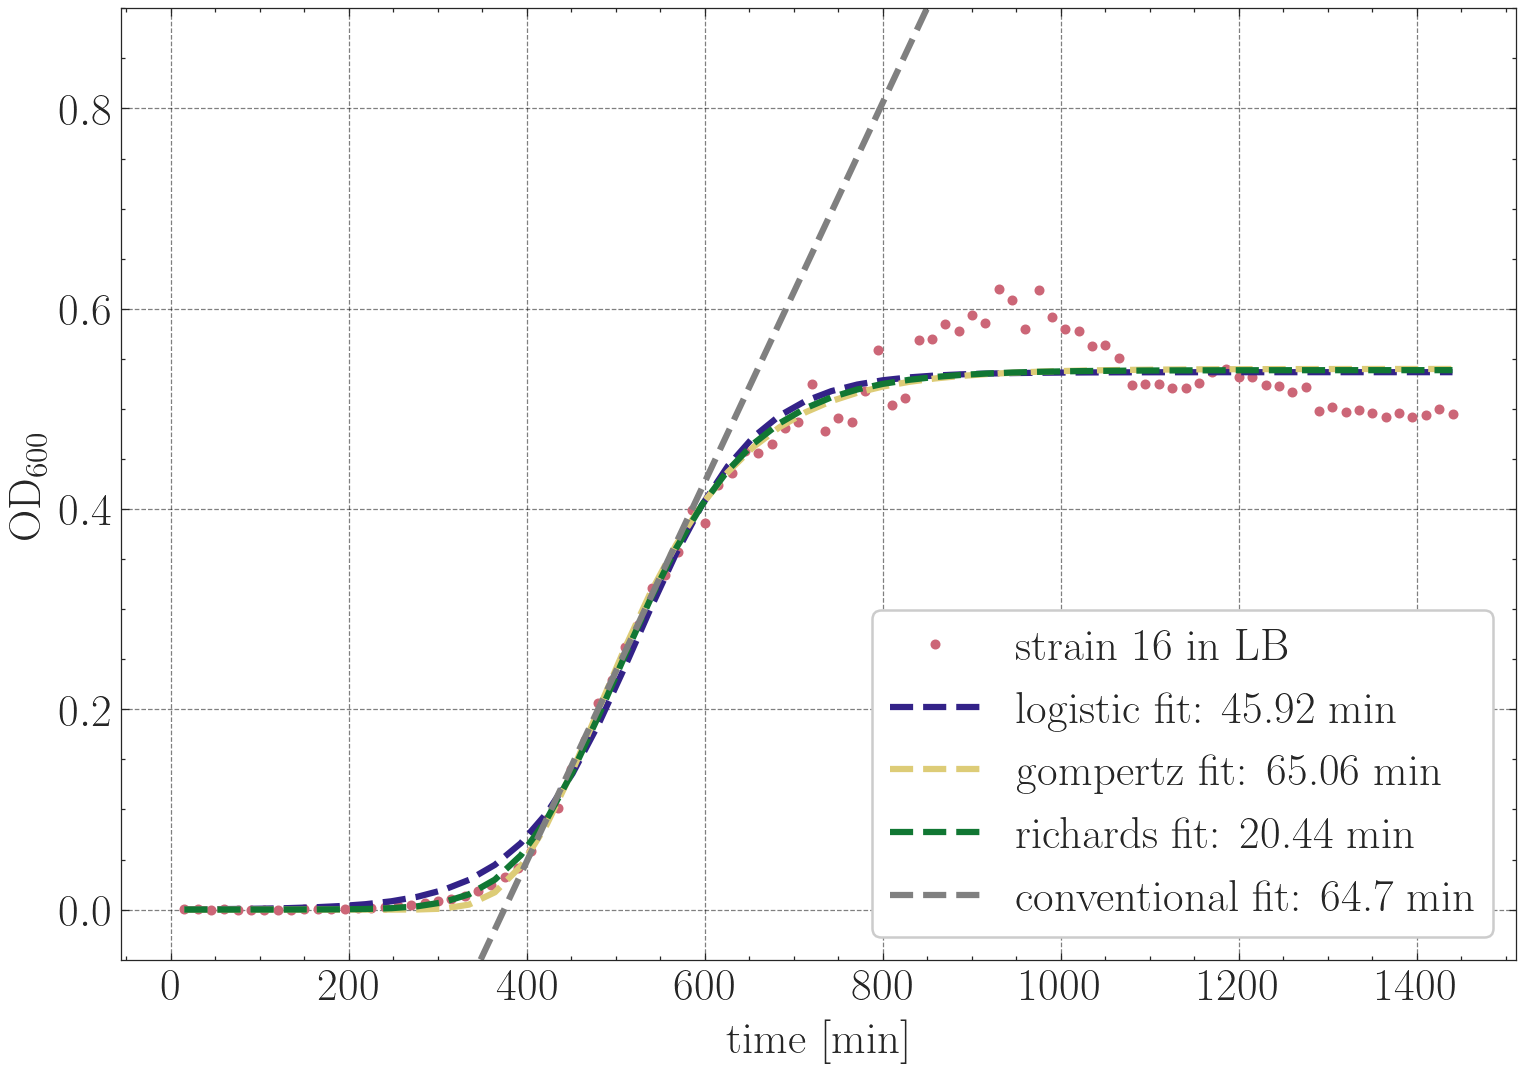

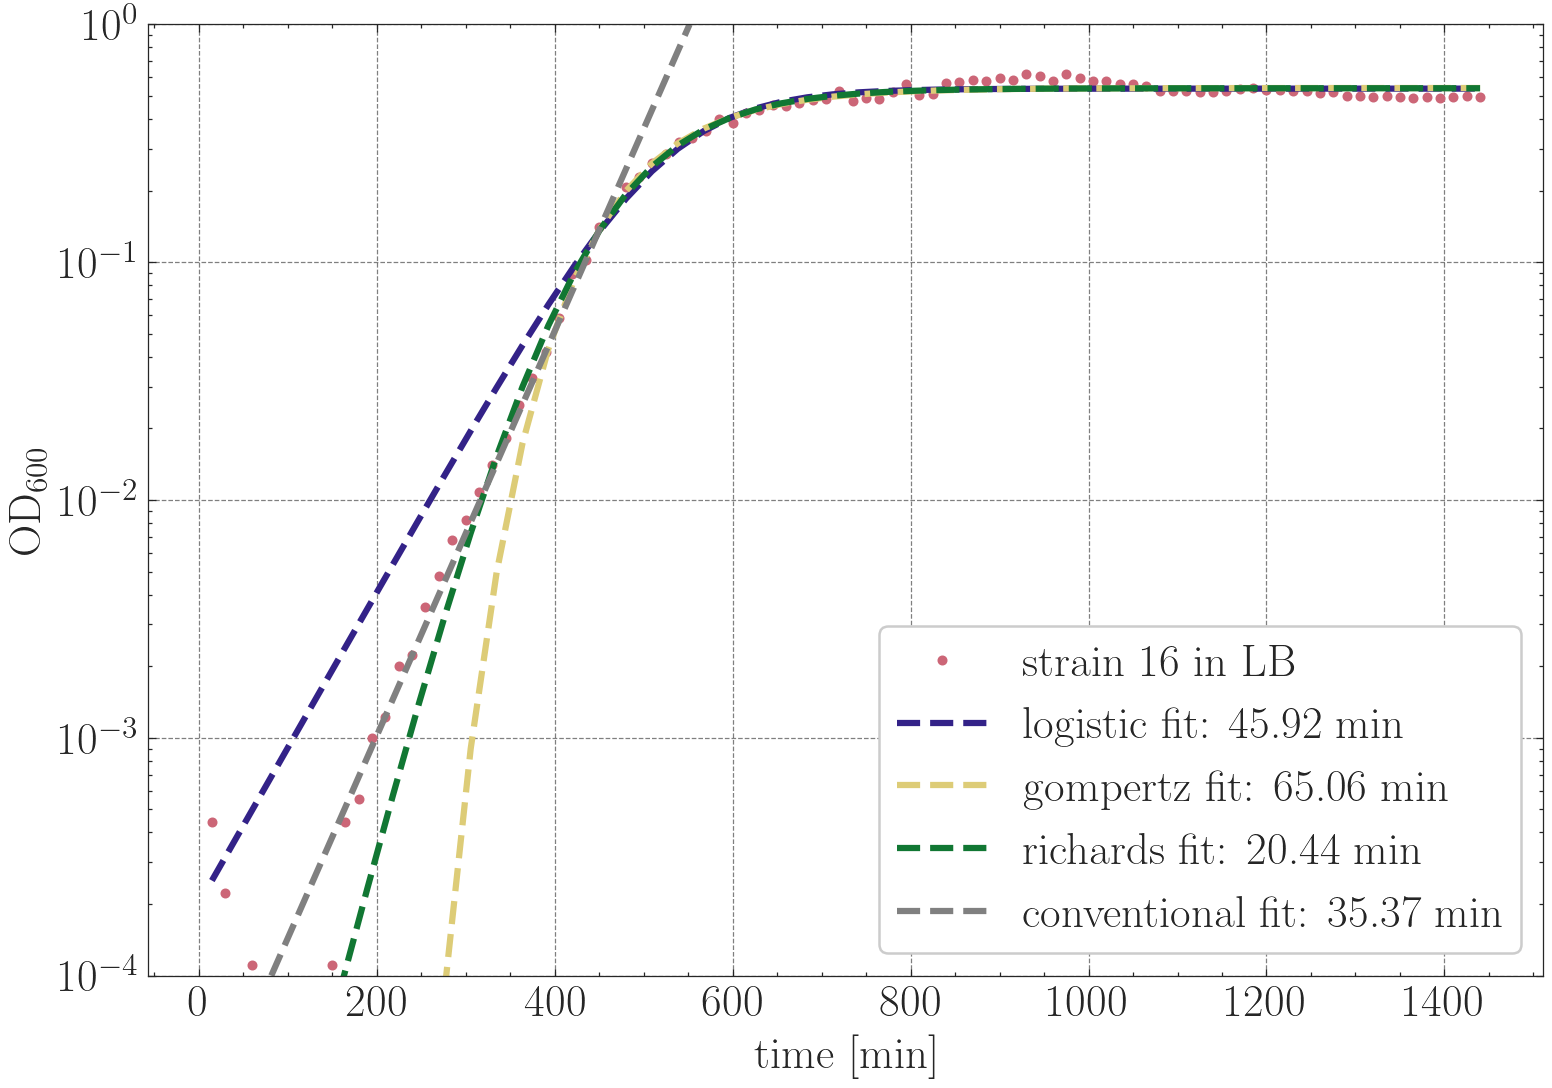

In [134]:
plt.close('all')
growth_sample = pd.read_csv('plate_reader_results/220615_Cstr16_LB_avg.csv')
plot_different_fits(growth_sample, 'linear', 405.0, 585.0, 'LB', 'strain 16 in LB')
plot_different_fits(growth_sample, 'log', 240.0, 390.0, 'LB', 'strain 16 in LB')

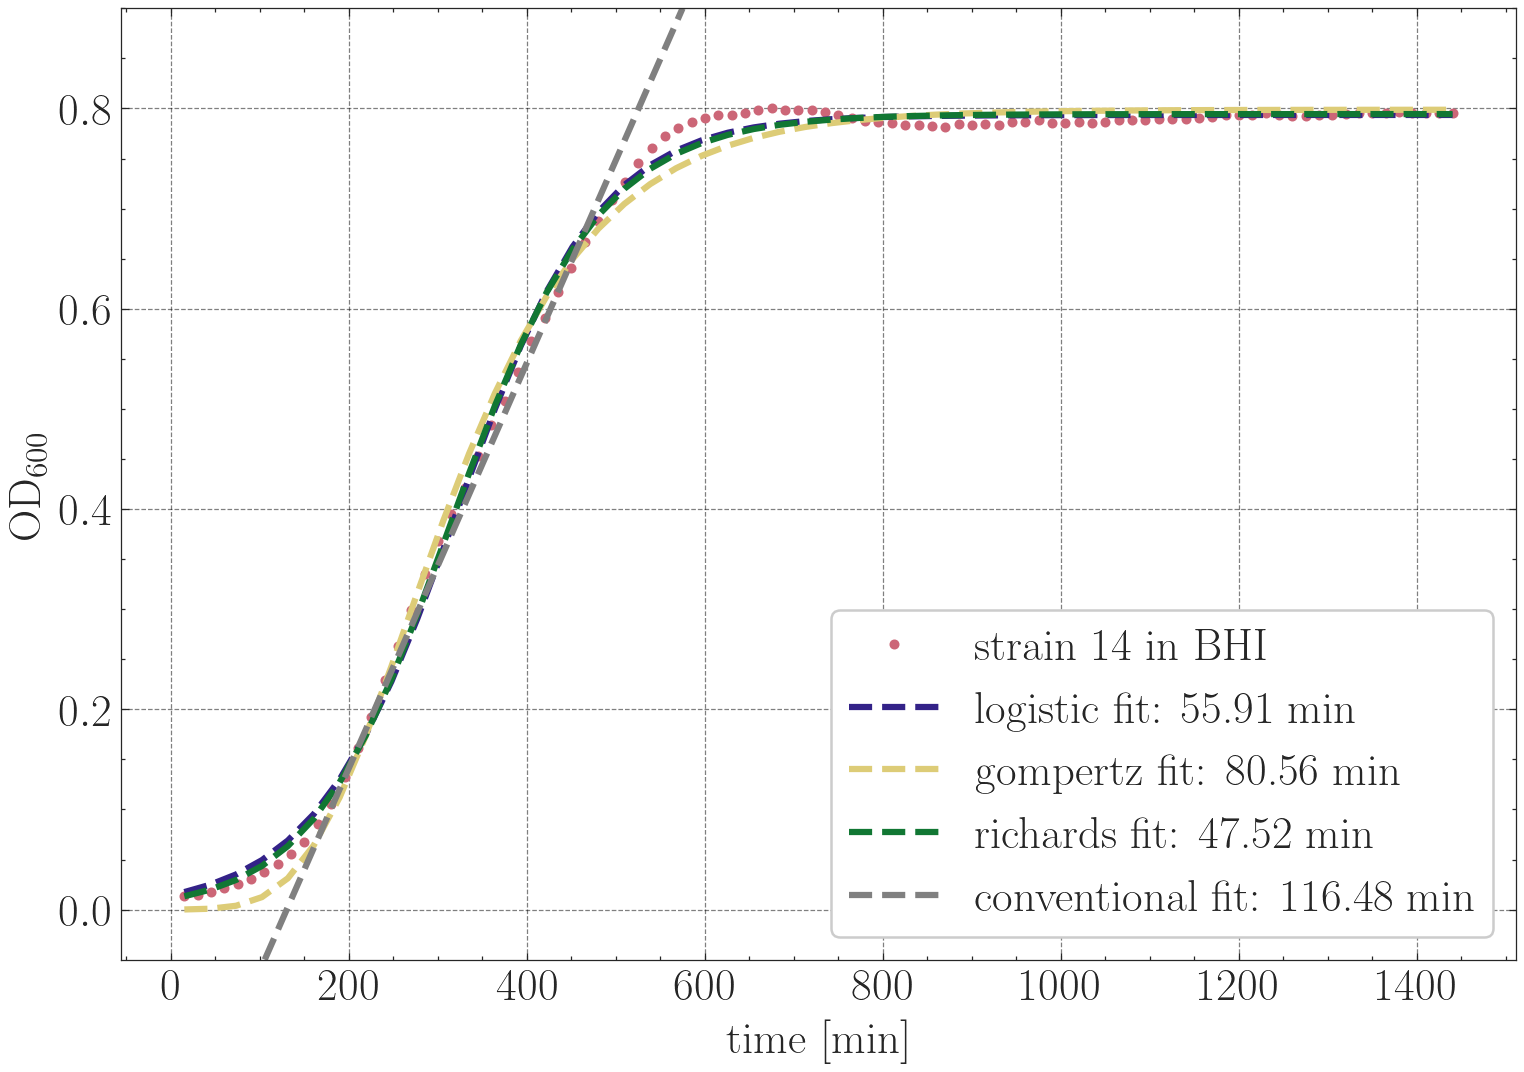

In [118]:
growth_sample = media_avg['BHI'][['Time', '14']]
plt.close('all')
plot_different_fits(growth_sample, 'linear', 210.0, 435.0, '14', 'strain 14 in BHI')
#plot_different_fits(growth_sample, 'log', 30.0, 210.0, '14', 'strain 14 in BHI')

RuntimeError for 14 set popts to 1


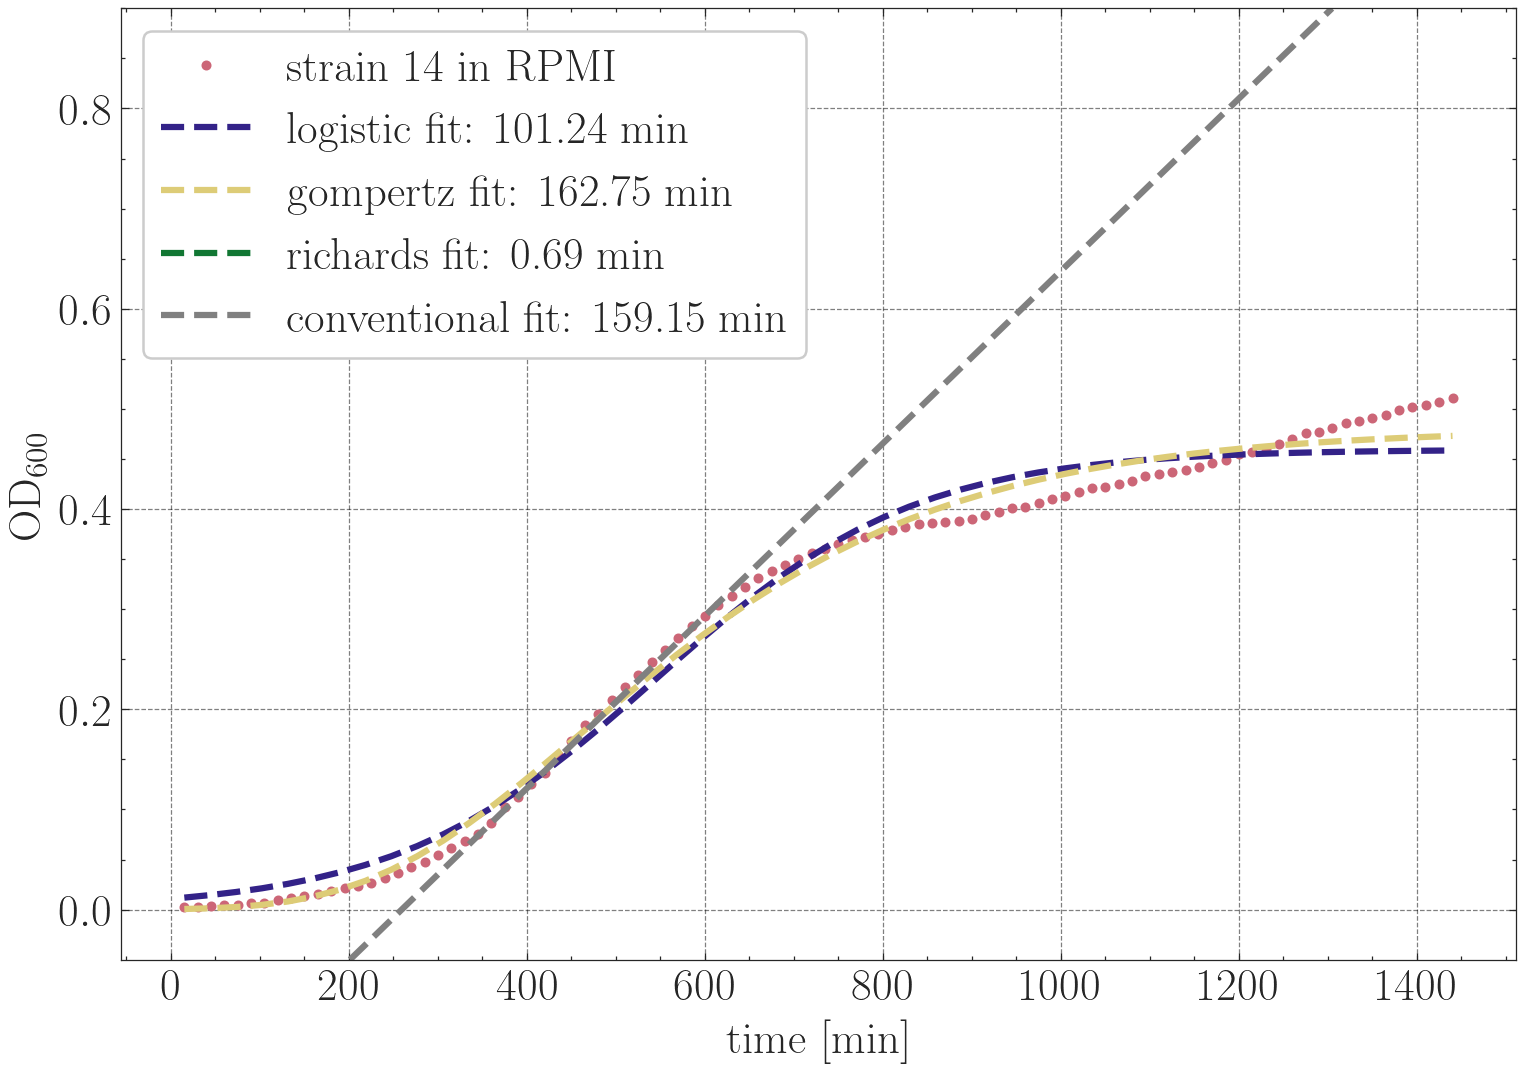

In [119]:
growth_sample = media_avg['RPMI'][['Time', '14']]
plt.close('all')
plot_different_fits(growth_sample, 'linear', 405.0, 600.0, '14', 'strain 14 in RPMI')
#plot_different_fits(growth_sample, 'log', 30.0, 390.0, '14', 'strain 14 in RPMI')

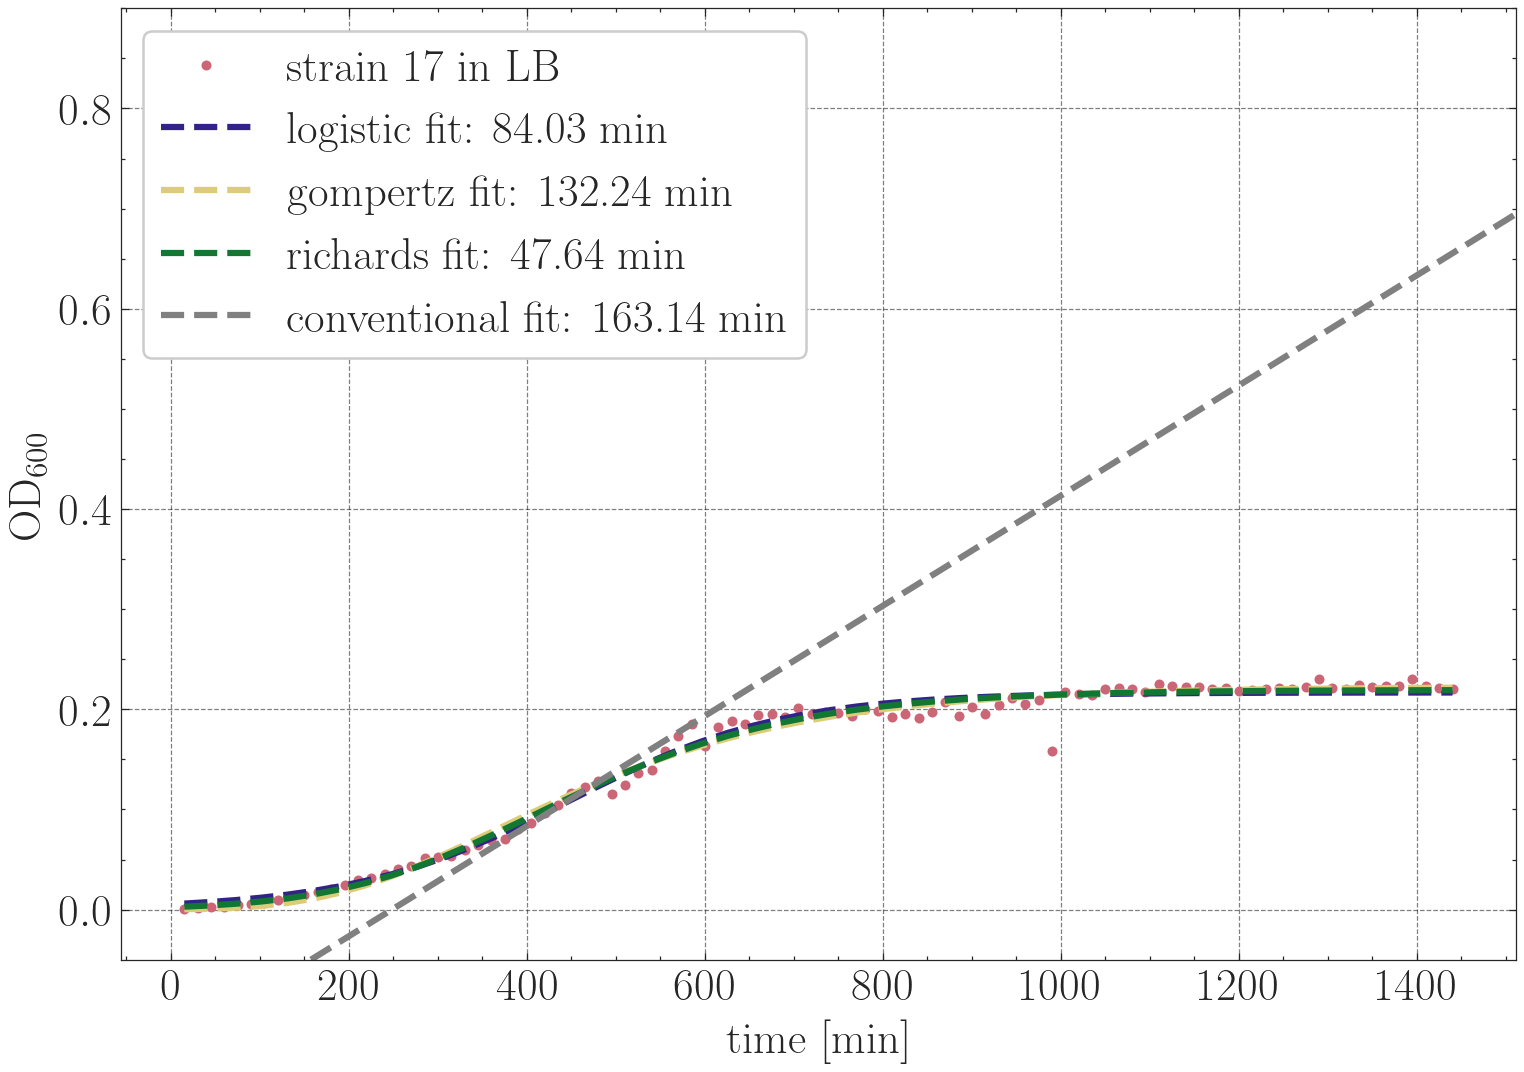

In [120]:
growth_sample = media_avg['LB'][['Time', '17']]
plt.close('all')
plot_different_fits(growth_sample, 'linear', 405.0, 585.0, '17', 'strain 17 in LB')
#plot_different_fits(growth_sample, 'log', 210.0, 390.0, '17', 'strain 17 in LB')

_Answers from Laura_

* __About growth rate:__ I don't think there's a real standard method in wet lab experiment. We usually use a way that highlights the best our results of interest. CFU concentrations is expressed in powers of ten and then usually showed on log-lin plots. However it's still possible to represent it on lin-lin plots if you expect small variations rather that log variations. OD measurements (like what you did) are rather plotted on lin-lin scales since OD is not expression in powers of ten. Since you estimate your growth rates from OD measurements, I guess you should rather use lin-lin scales. But in theory, the log transformation should not impact too much the conclusions you draw from your curves, no? (Value will be different but not your trends between your conditions ?).

* __About errors bars:__ Growth rate is indeed often used in articles without any real quantification; people tend to use this word to qualify the overall grow or aspect of a growth curve. I've not seen your results yet but I think you should keep these growth rates with error bars. It's more accurate and the variability of your results should not be neglected.


## Fitting with lmfit instead of curve_fit

`lmfit` also uses a least-squares approach to fit the data, it includes automatic error calculation.

In [121]:
from lmfit import Model, Parameter, fit_report
import lmfit

We define functions to fit the data that use the `Model` object from lmfit.

In [122]:
def fit_logistic(growth_sample, column):
    model = Model(logistic, independent_vars=['t'])
    return model.fit(growth_sample[column], t=growth_sample['Time'],
          K=Parameter('K', value=0.2),
          N0=Parameter('N0', value=0.005),
          r=Parameter('r', value=0.05),
          )
    
def fit_gompertz(growth_sample, column):
    model = Model(gompertz, independent_vars=['t'])
    return model.fit(growth_sample[column], t=growth_sample['Time'],
          K=Parameter('K', value=0.8),
          lag=Parameter('lag', value=1),
          r=Parameter('r', value=0.01),
          )

In [123]:
def plot_result(growth_sample, fit_result, title=growth_sample.columns[1]):
    dely = fit_result.eval_uncertainty(sigma=3)
    growth_sample.rename({growth_sample.columns[1]:'data'}, 
                         axis=1).plot(x='Time',
                       style='o',
                       grid=True,
                       ylabel='OD$_{600}$',
                       xlabel='time [min]',
                       figsize=(12,9)
                       )
    plt.plot(growth_sample['Time'], fit_result.best_fit, label='best fit')
    plt.fill_between(growth_sample['Time'], fit_result.best_fit-dely, fit_result.best_fit+dely, 
                 color="#ABABAB",
                 label='3-$\sigma$ uncertainty band')
    plt.title(title)
    plt.legend()
    
def determine_td(fit_result):
    fit_res = pd.DataFrame([(p.name, p.value, p.stderr) for p in fit_result.params.values()], 
            columns=('name', 'r_fitted', 'r_stderr'))
    growth = fit_res[fit_res['name'] == 'r'].drop('name', axis=1)
    growth['td'] = np.log(2)/growth['r_fitted']
    growth['td_plus_err'] = np.log(2)/(growth['r_fitted'] + growth['r_stderr'])
    growth['td_min_err'] = np.log(2)/(growth['r_fitted'] - growth['r_stderr'])
    growth['td_err'] = growth['td_min_err'] - growth['td_plus_err']
    return growth

r_fitted  r_stderr        td  td_plus_err  td_min_err    td_err
2  0.008249  0.000308  84.03289    81.005682   87.295136  6.289454

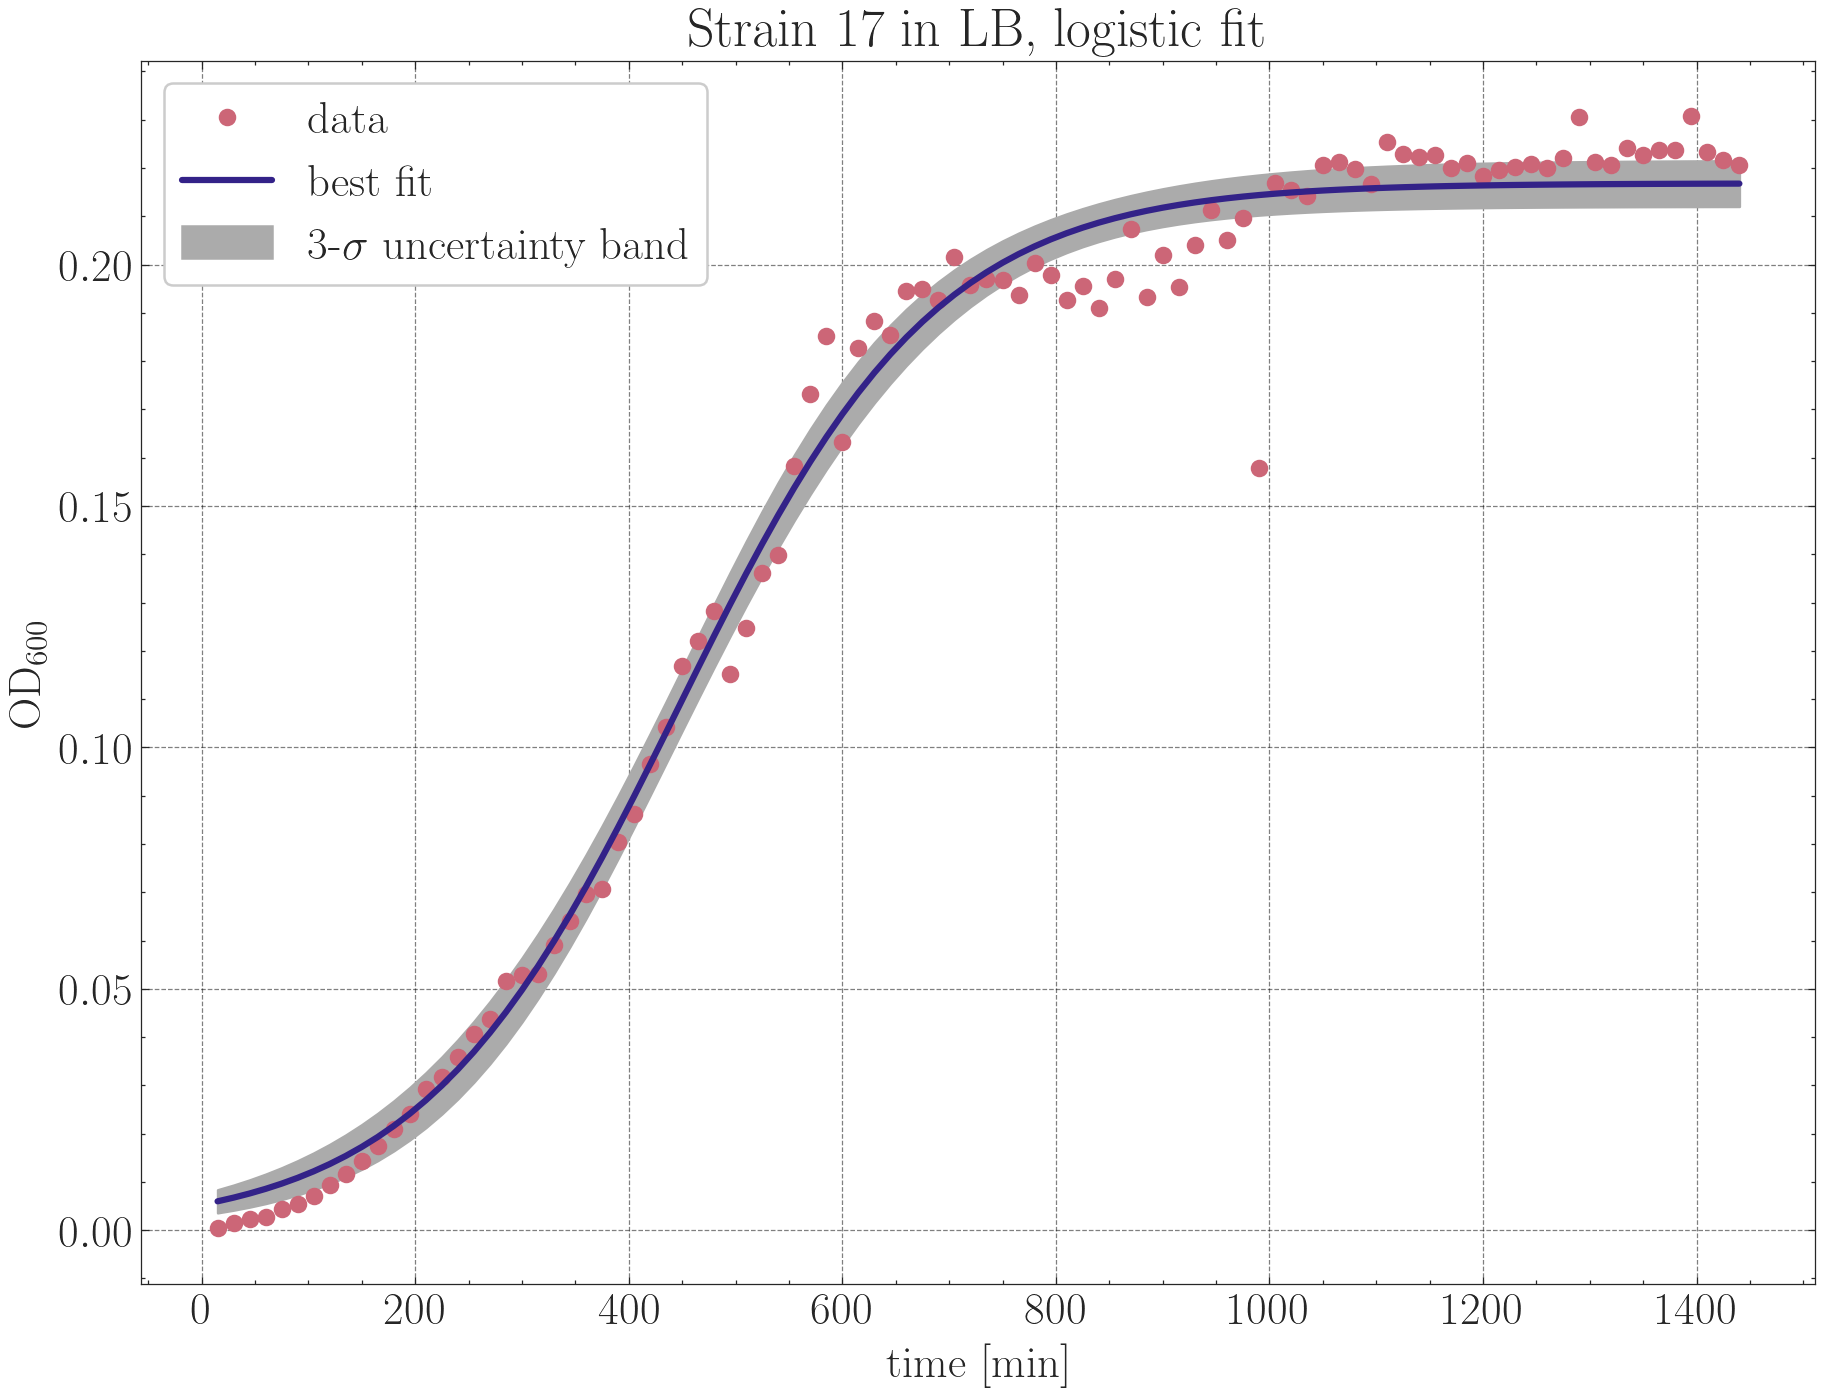

In [124]:
growth_sample =  media_avg['LB'][['Time', '17']]
res = fit_logistic(growth_sample, '17')
plot_result(growth_sample, res, 'Strain 17 in LB, logistic fit')
determine_td(res)

r_fitted  r_stderr          td  td_plus_err  td_min_err     td_err
2  0.005241  0.000204  132.242912   127.297304  137.588336  10.291032

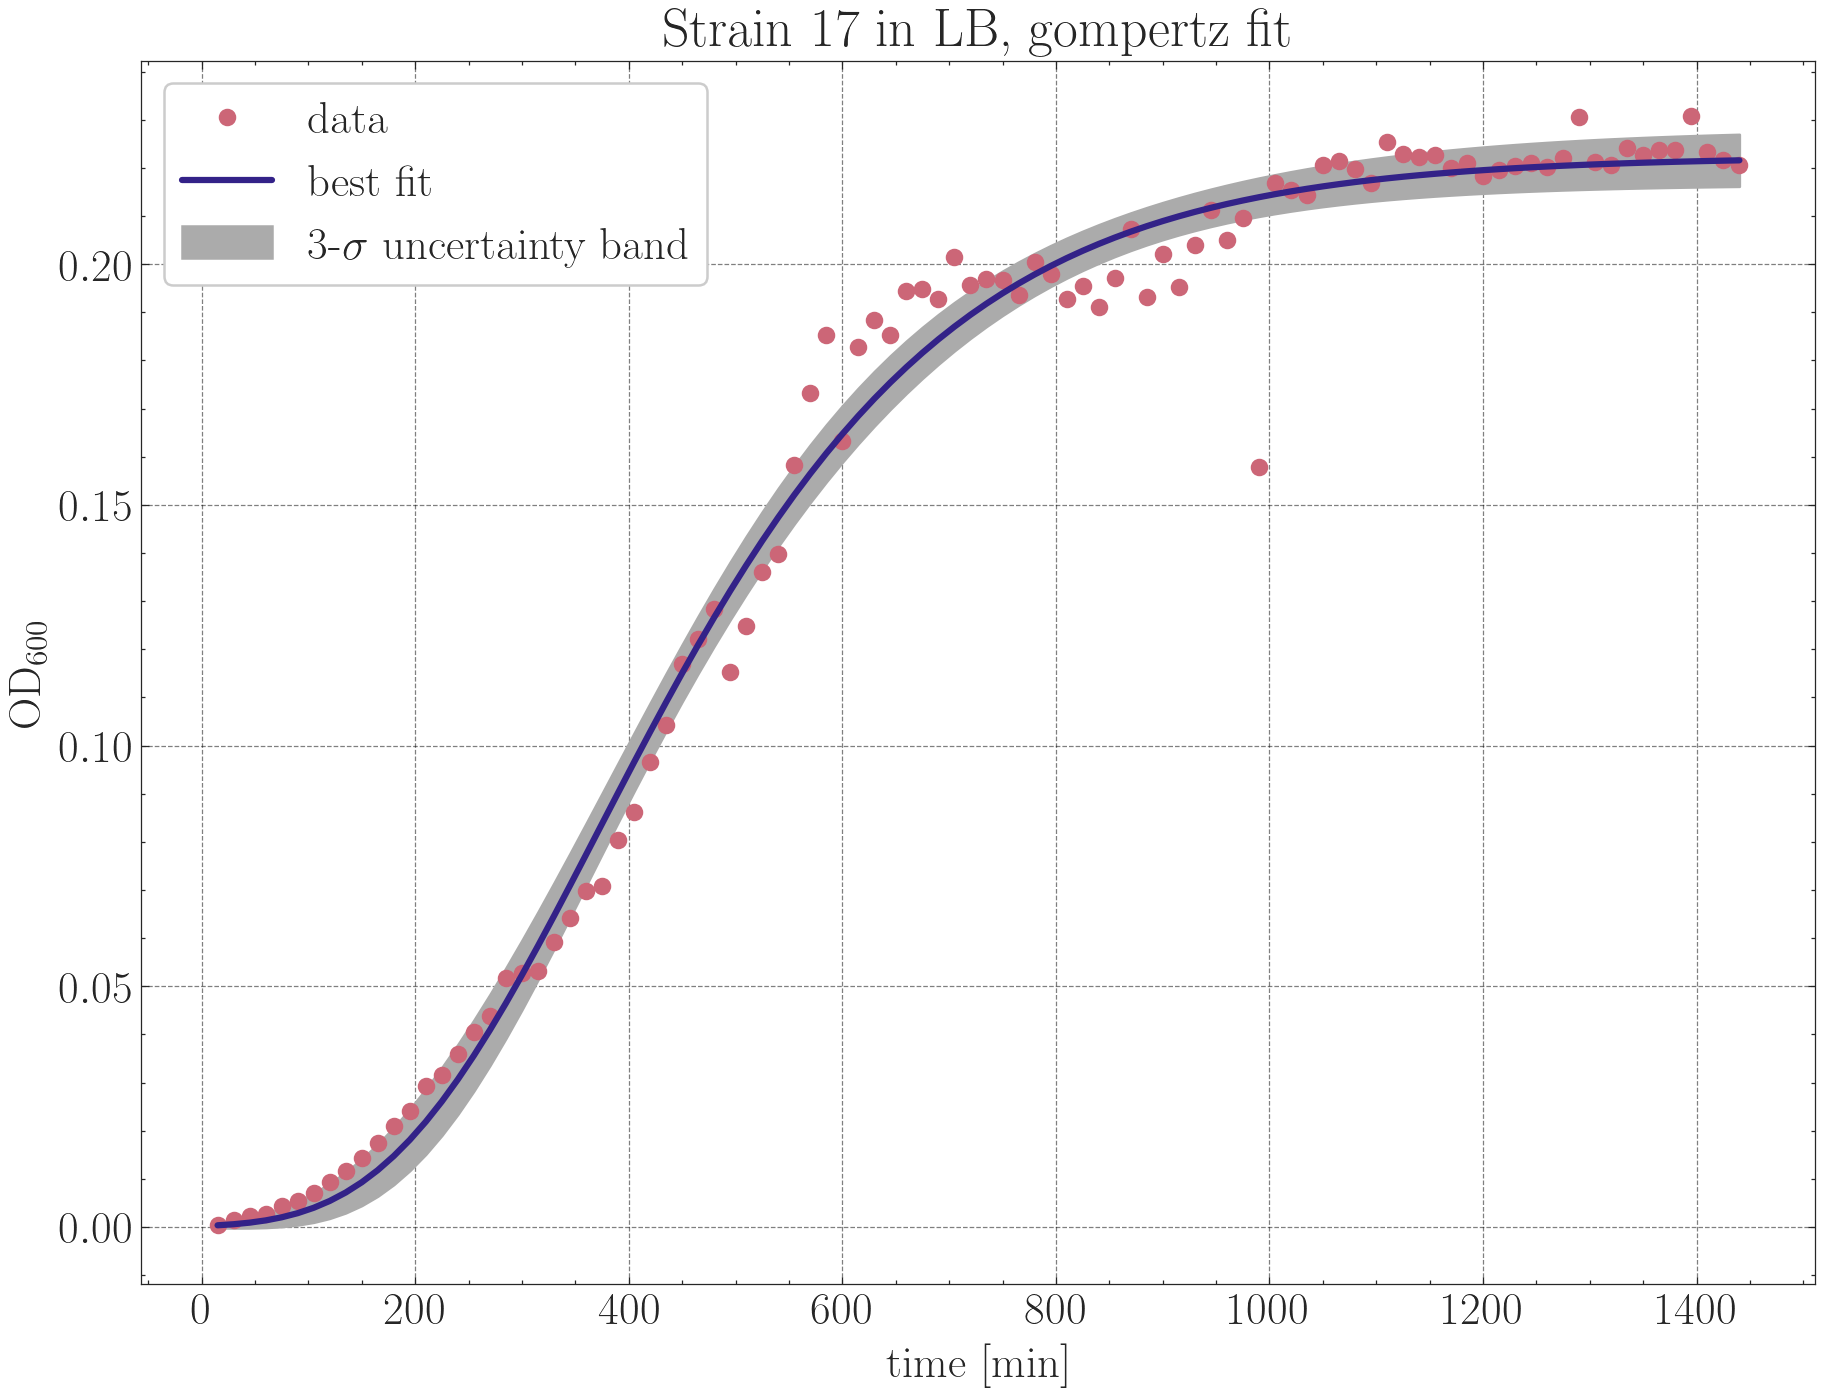

In [125]:
res = fit_gompertz(growth_sample, '17')
plot_result(growth_sample, res, 'Strain 17 in LB, gompertz fit')
determine_td(res)

2
r_fitted      0.012398
r_stderr      0.000181
td           55.905924
td_plus_err  55.101880
td_min_err   56.733780
td_err        1.631900

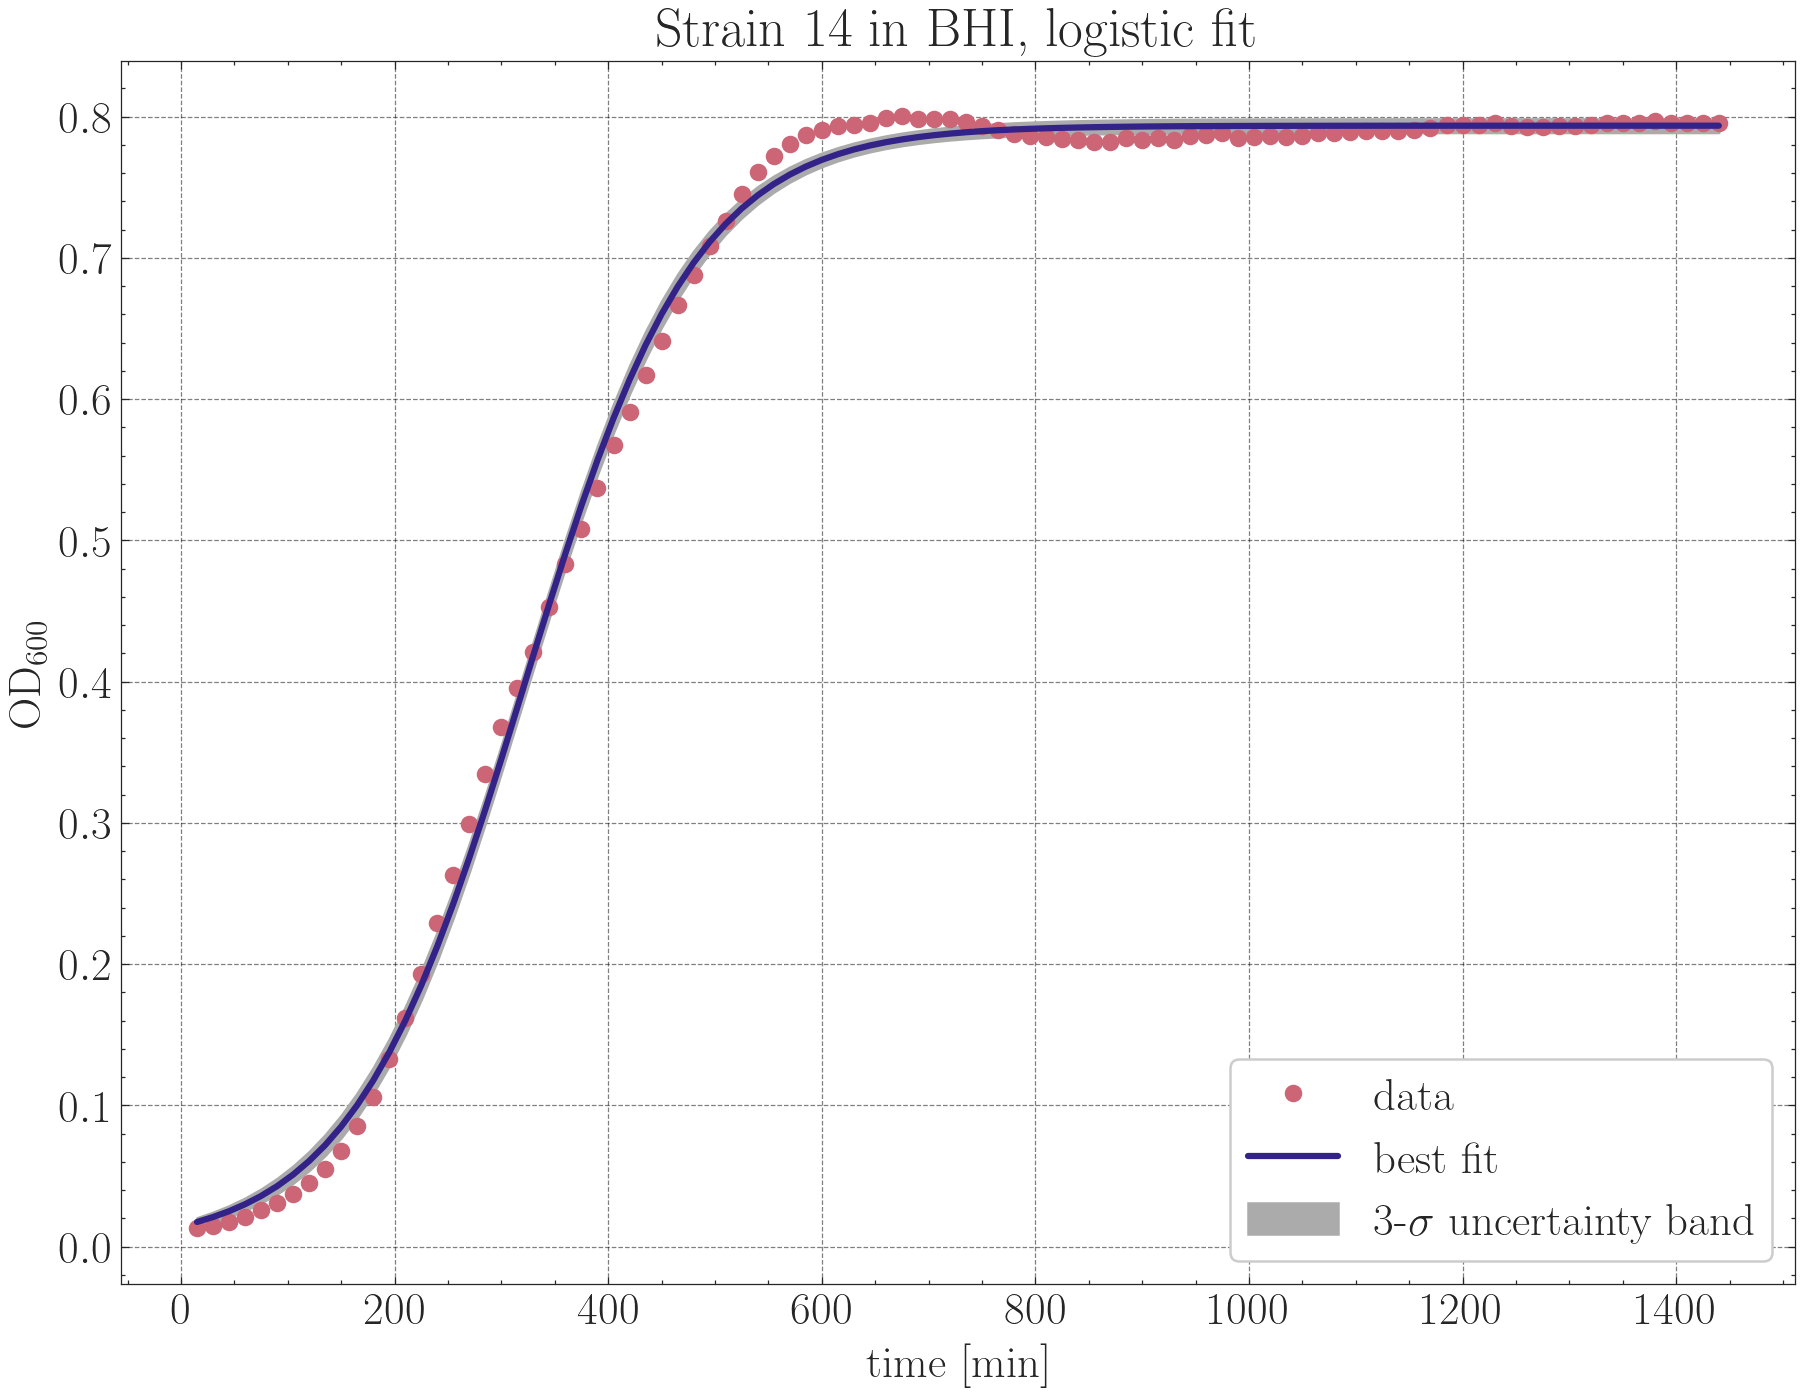

In [140]:
growth_sample =  media_avg['BHI'][['Time', '14']]
res = fit_logistic(growth_sample, '14')
plot_result(growth_sample, res, 'Strain 14 in BHI, logistic fit')
determine_td(res).T

2
r_fitted      0.008604
r_stderr      0.000179
td           80.561569
td_plus_err  78.922244
td_min_err   82.270440
td_err        3.348196

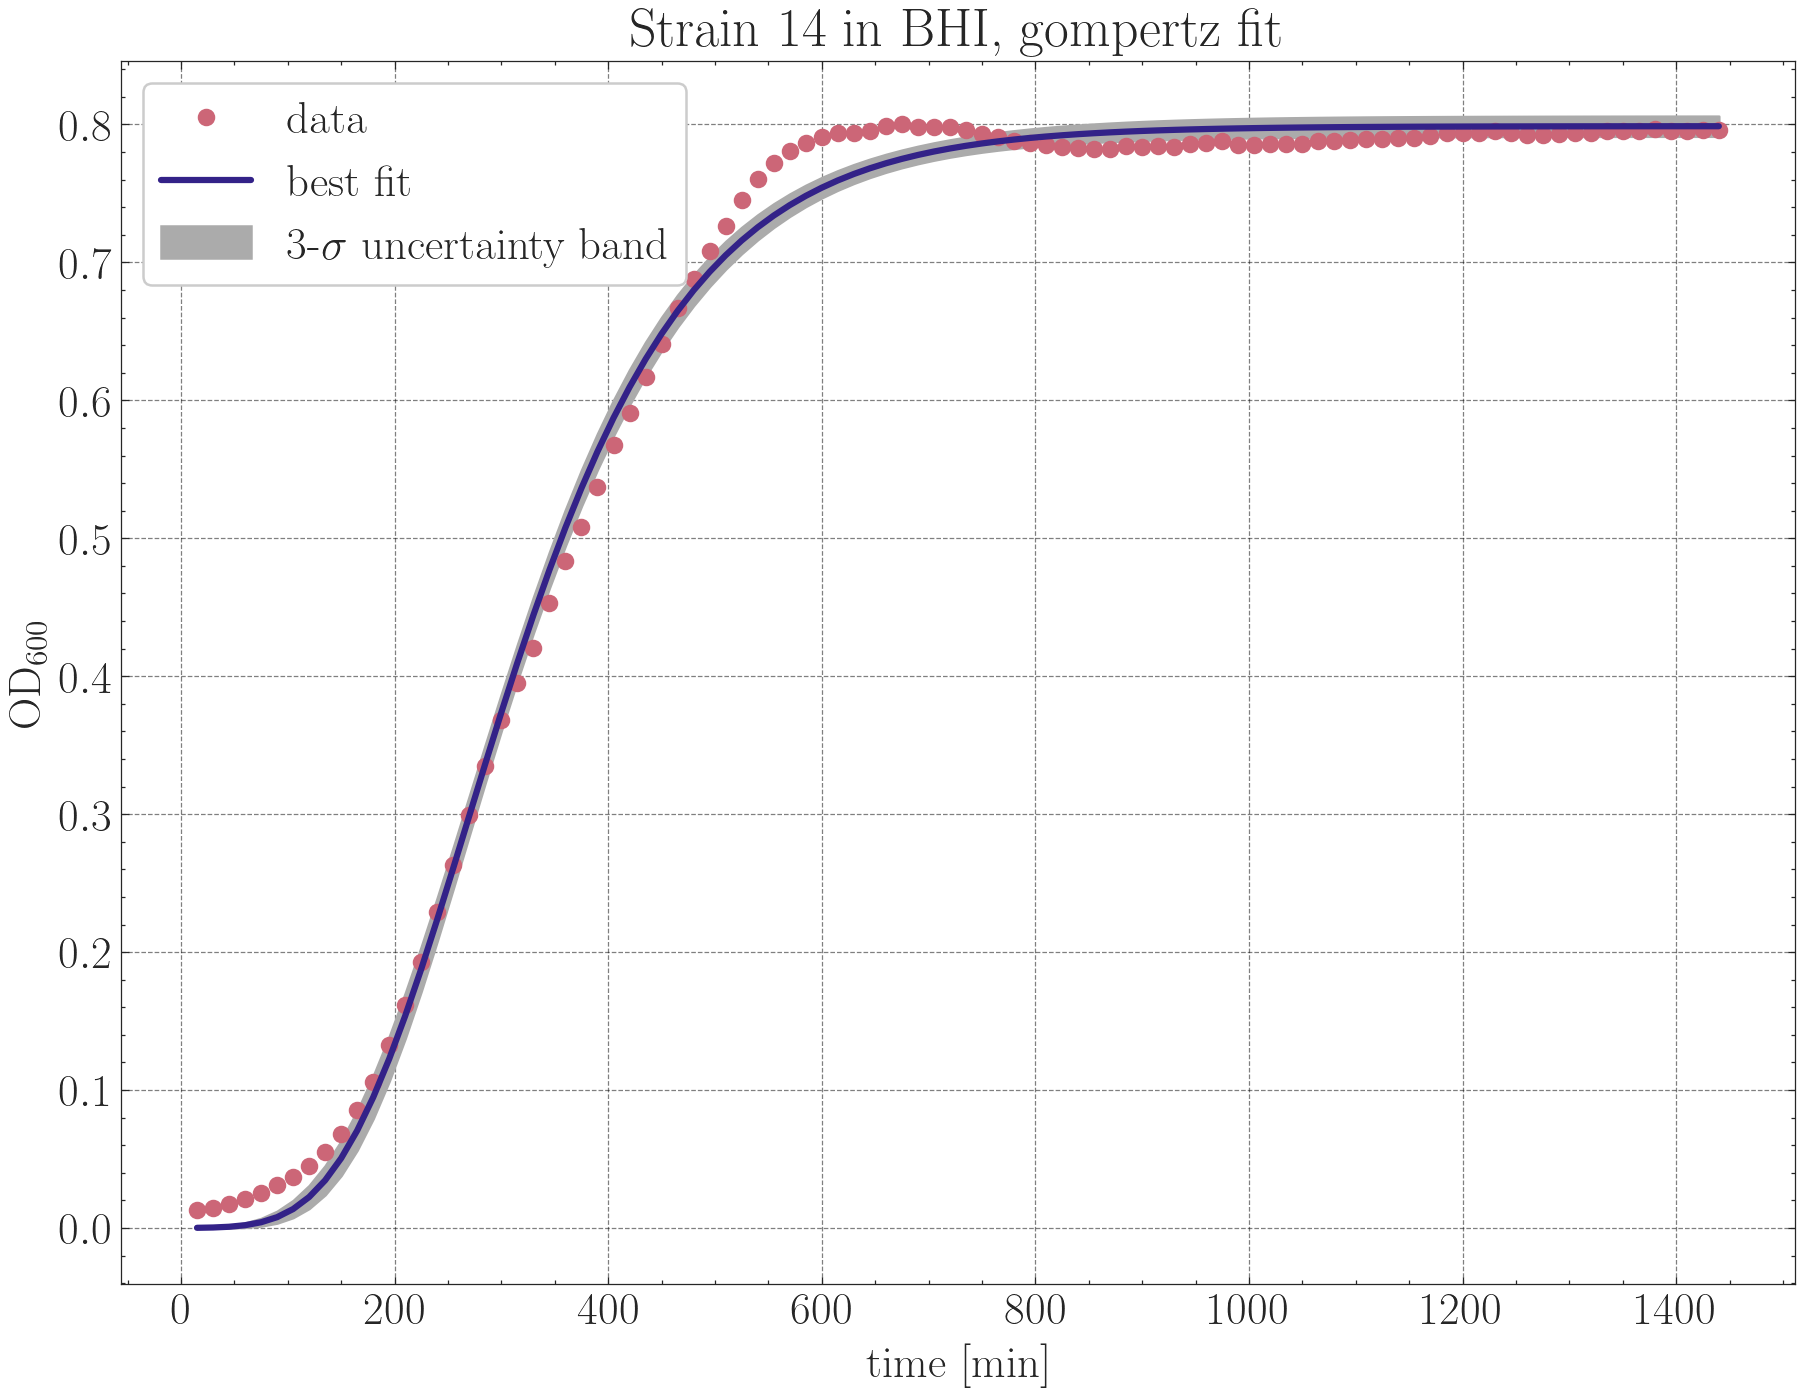

In [141]:
res = fit_gompertz(growth_sample, '14')
plot_result(growth_sample, res, 'Strain 14 in BHI, gompertz fit')
determine_td(res).T

r_fitted  r_stderr          td  td_plus_err  td_min_err   td_err
2  0.006846  0.000268  101.241167    97.420959  105.373209  7.95225

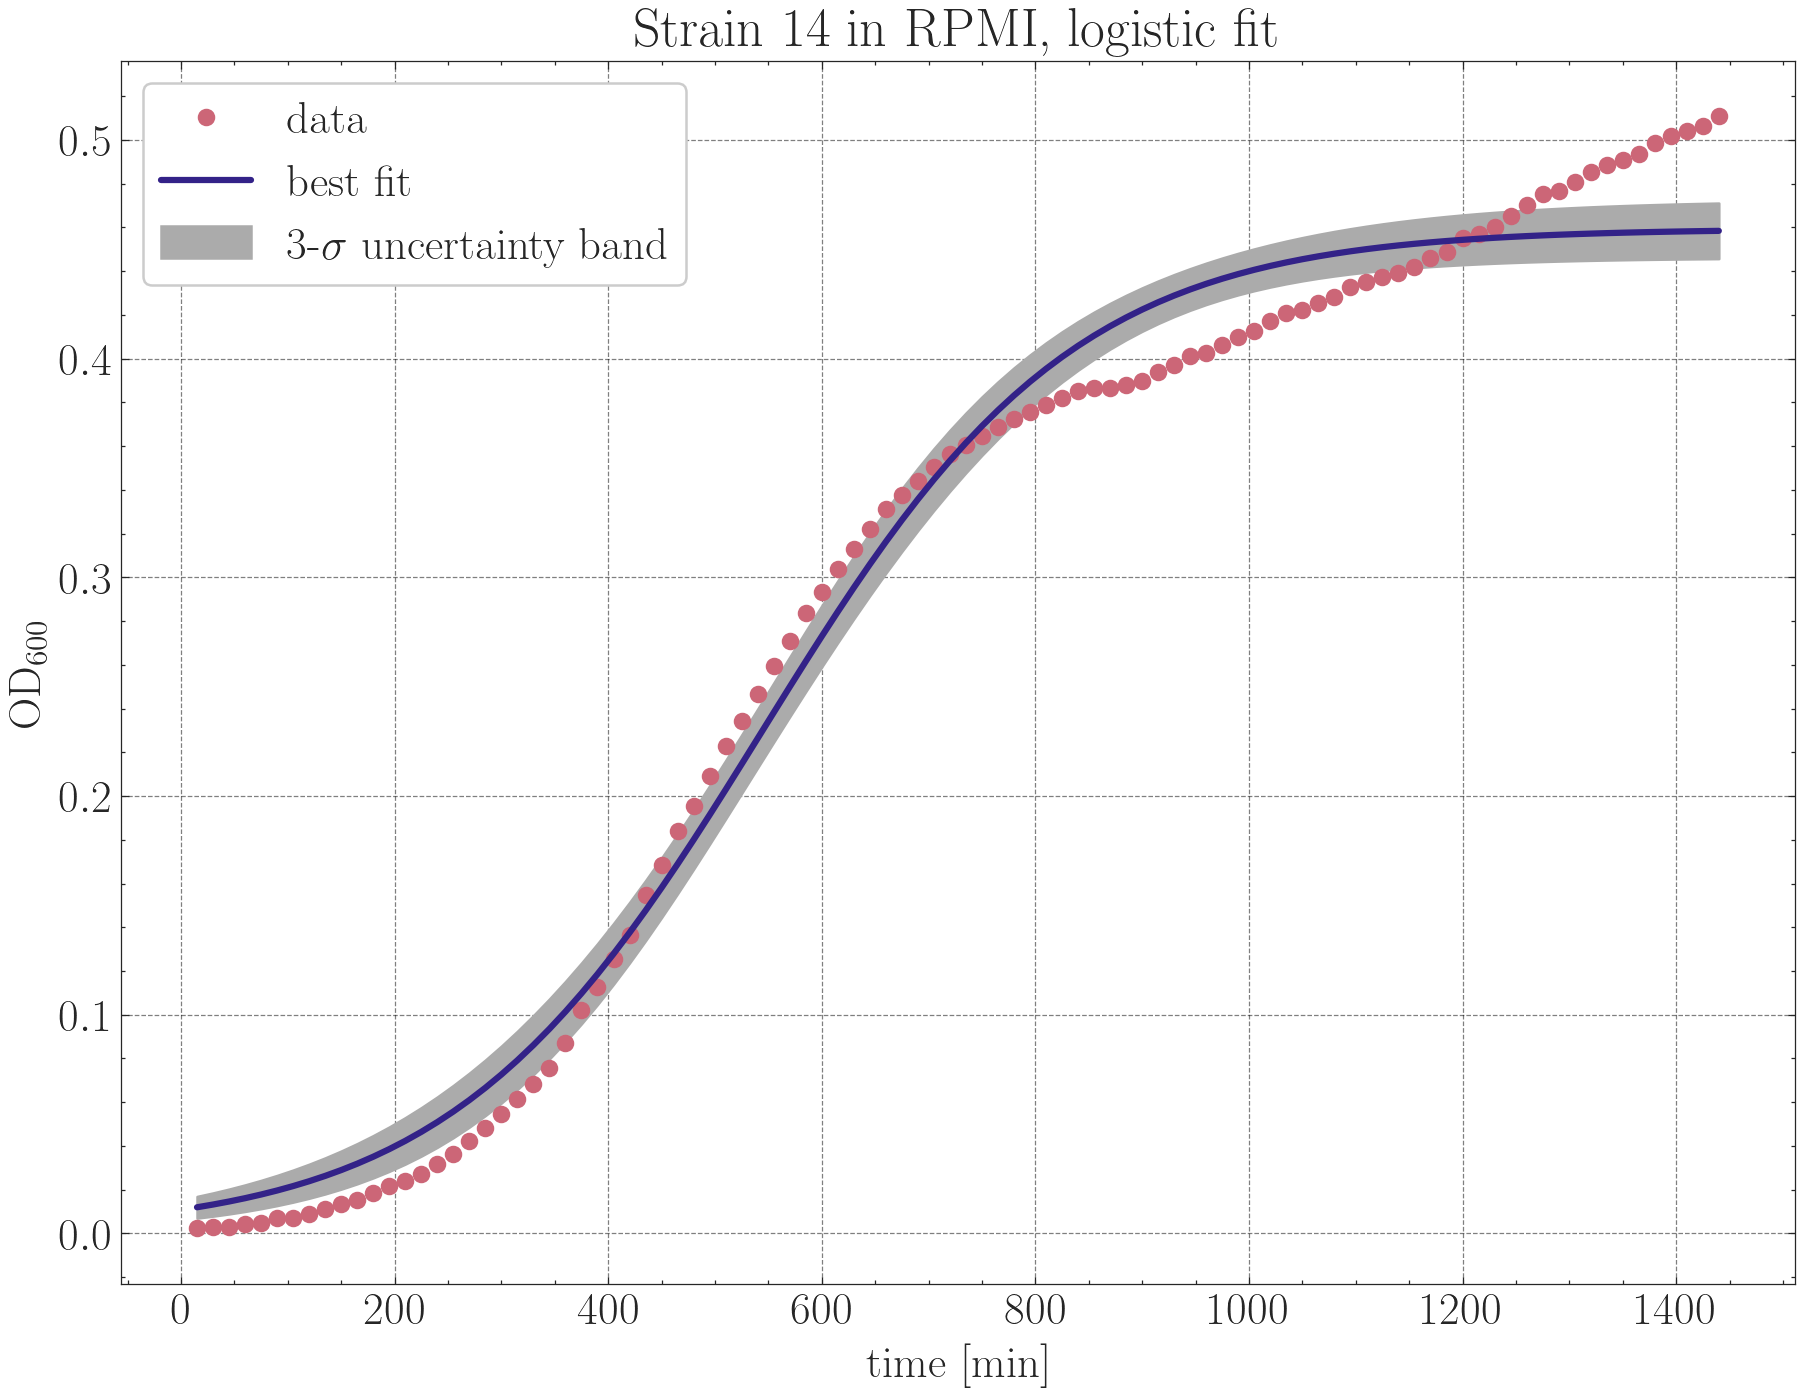

In [128]:
growth_sample =  media_avg['RPMI'][['Time', '14']]
res = fit_logistic(growth_sample, '14')
plot_result(growth_sample, res, 'Strain 14 in RPMI, logistic fit')
determine_td(res)

r_fitted  r_stderr       td  td_plus_err  td_min_err    td_err
2  0.015096  0.000866  45.9154    43.424356   48.709634  5.285278

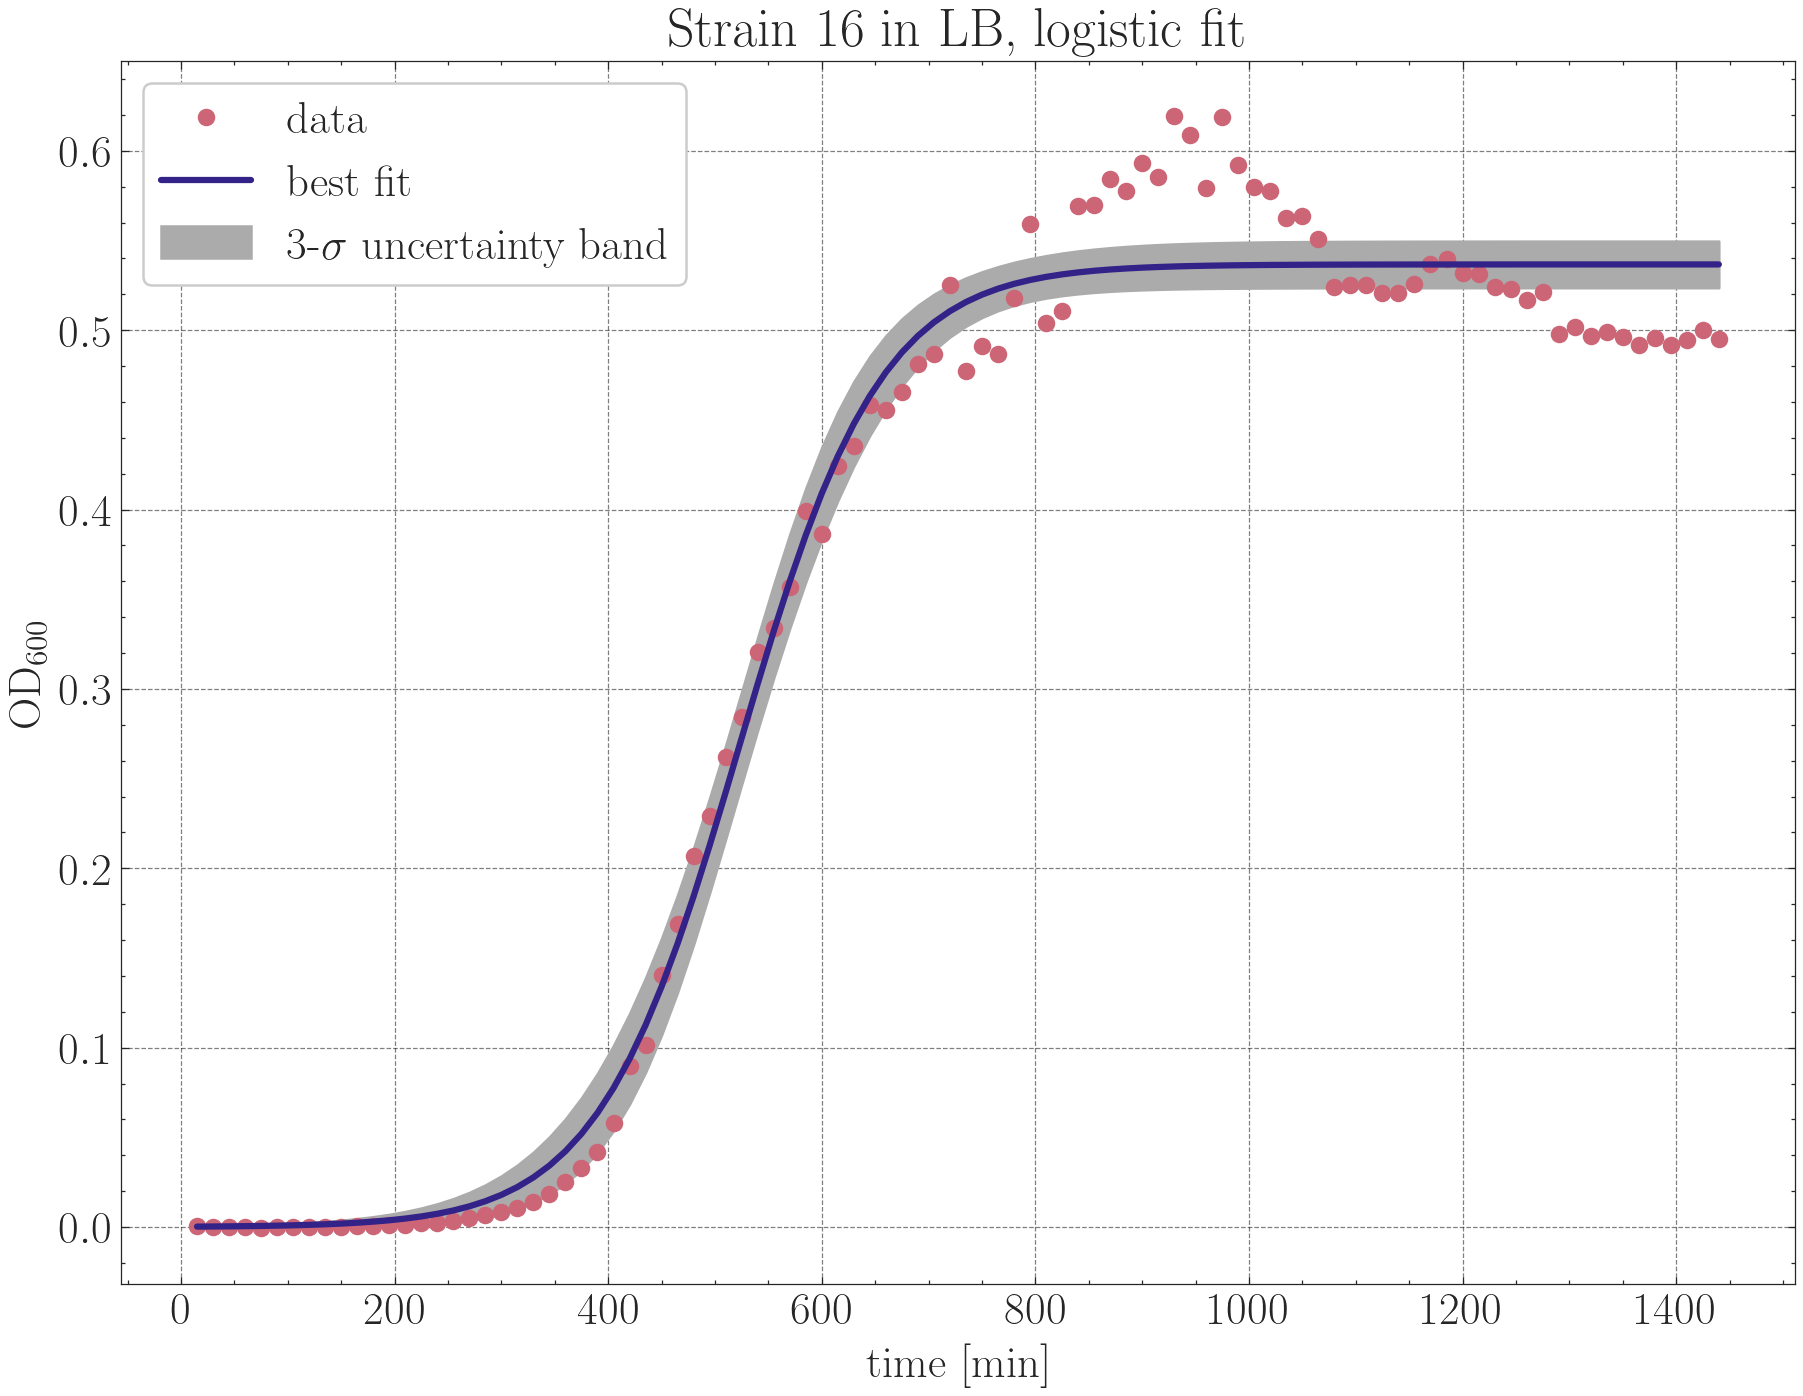

In [129]:
growth_sample = pd.read_csv('plate_reader_results/220615_Cstr16_LB_avg.csv')
res = fit_logistic(growth_sample, 'LB')
plot_result(growth_sample, res, 'Strain 16 in LB, logistic fit')
determine_td(res)

r_fitted  r_stderr         td  td_plus_err  td_min_err    td_err
2  0.010654  0.000613  65.062706    61.520363    69.03791  7.517547

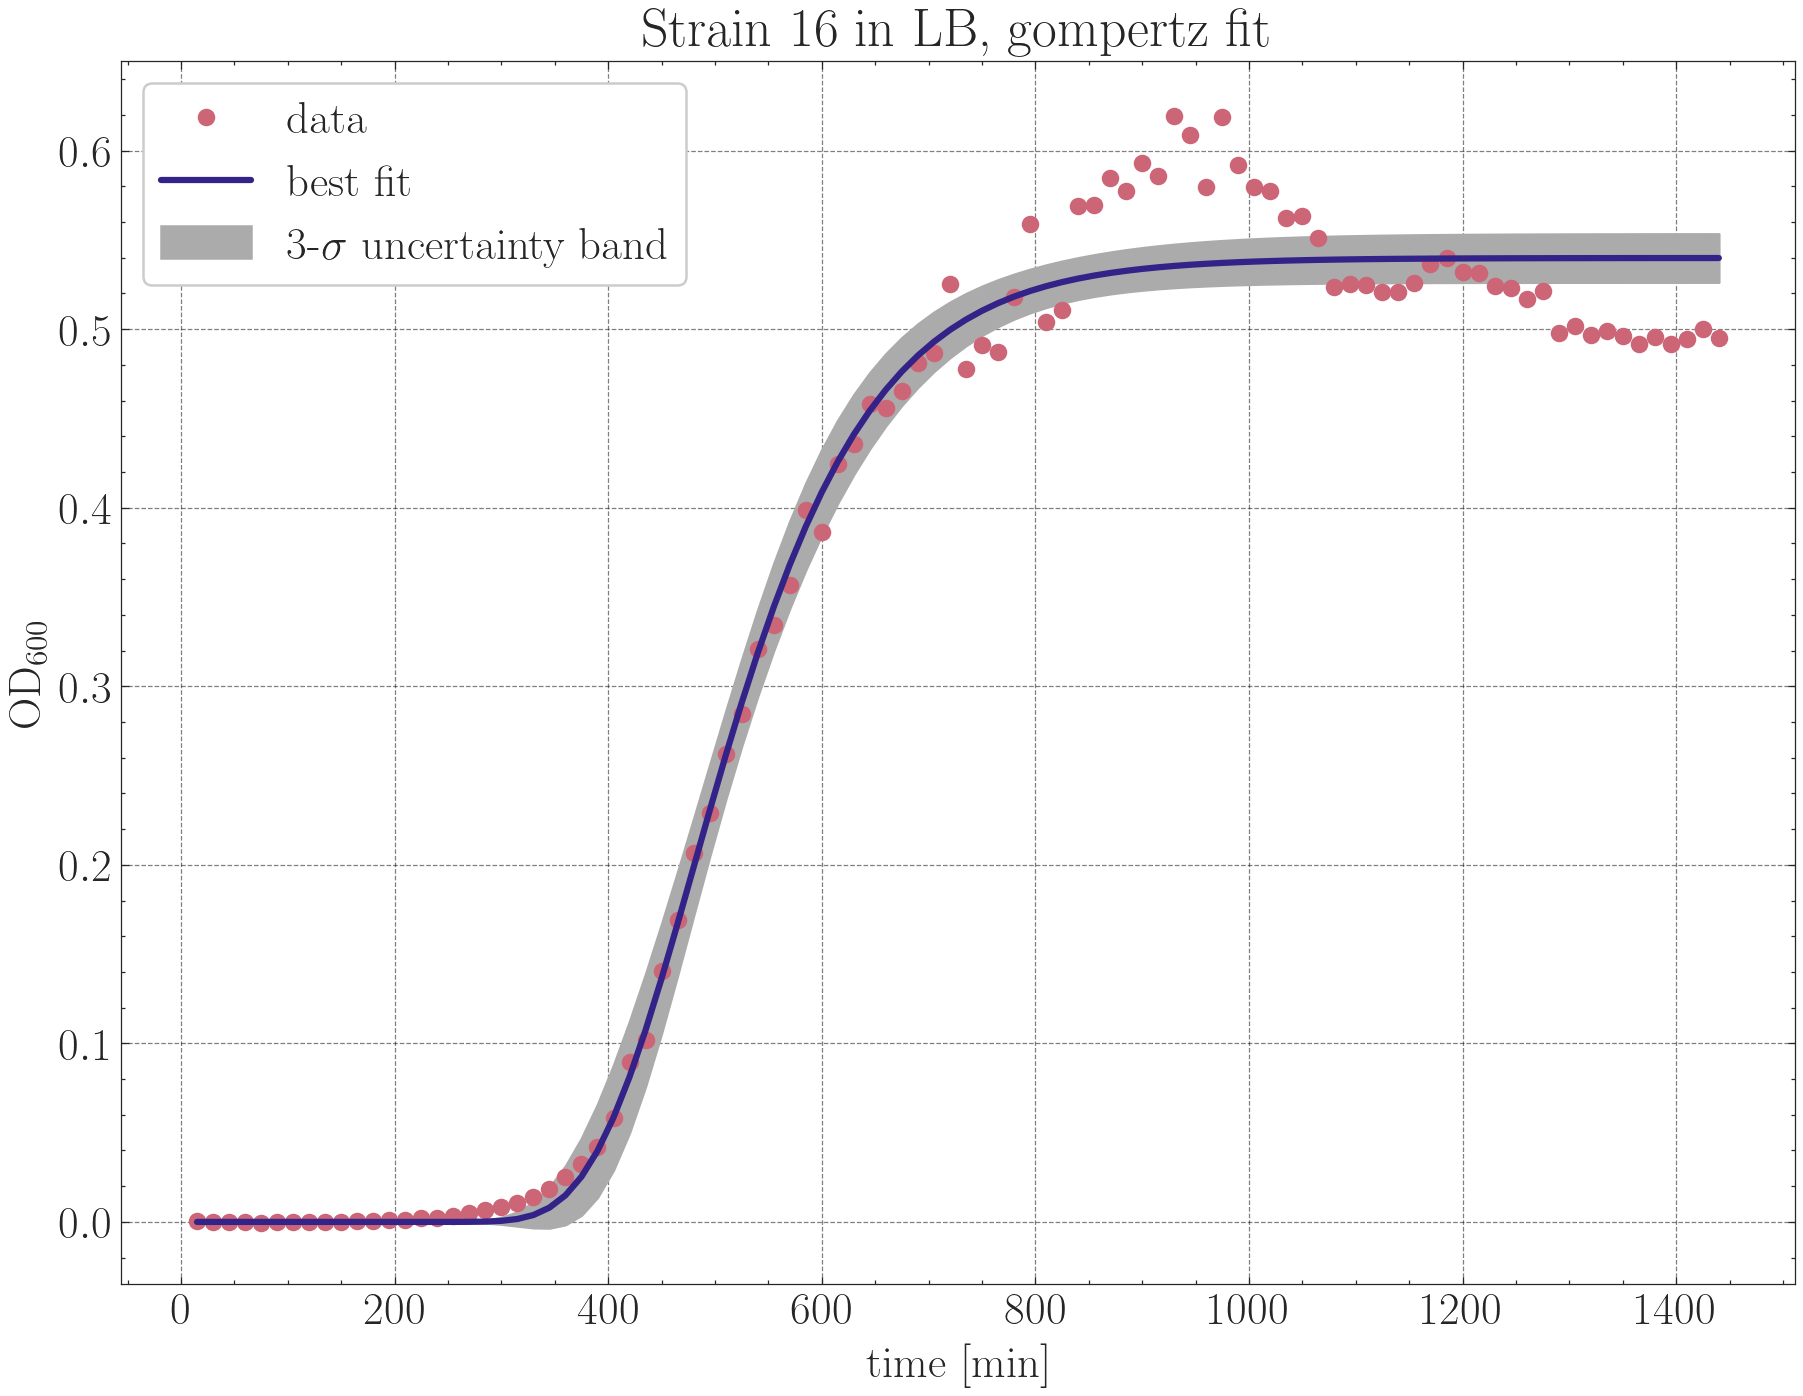

In [130]:
res = fit_gompertz(growth_sample, 'LB')
plot_result(growth_sample, res, 'Strain 16 in LB, gompertz fit')
determine_td(res)

## Fitting with curveball

["Curveball is an open-source software for analysis and visualization of high-throughput growth curve data and prediction of competition experiment results."](https://curveball.yoavram.com/)

In [131]:
import curveball

r_fitted r_stderr         td td_plus_err td_min_err td_err
2  0.017153     None  40.409643         NaN        NaN    NaN

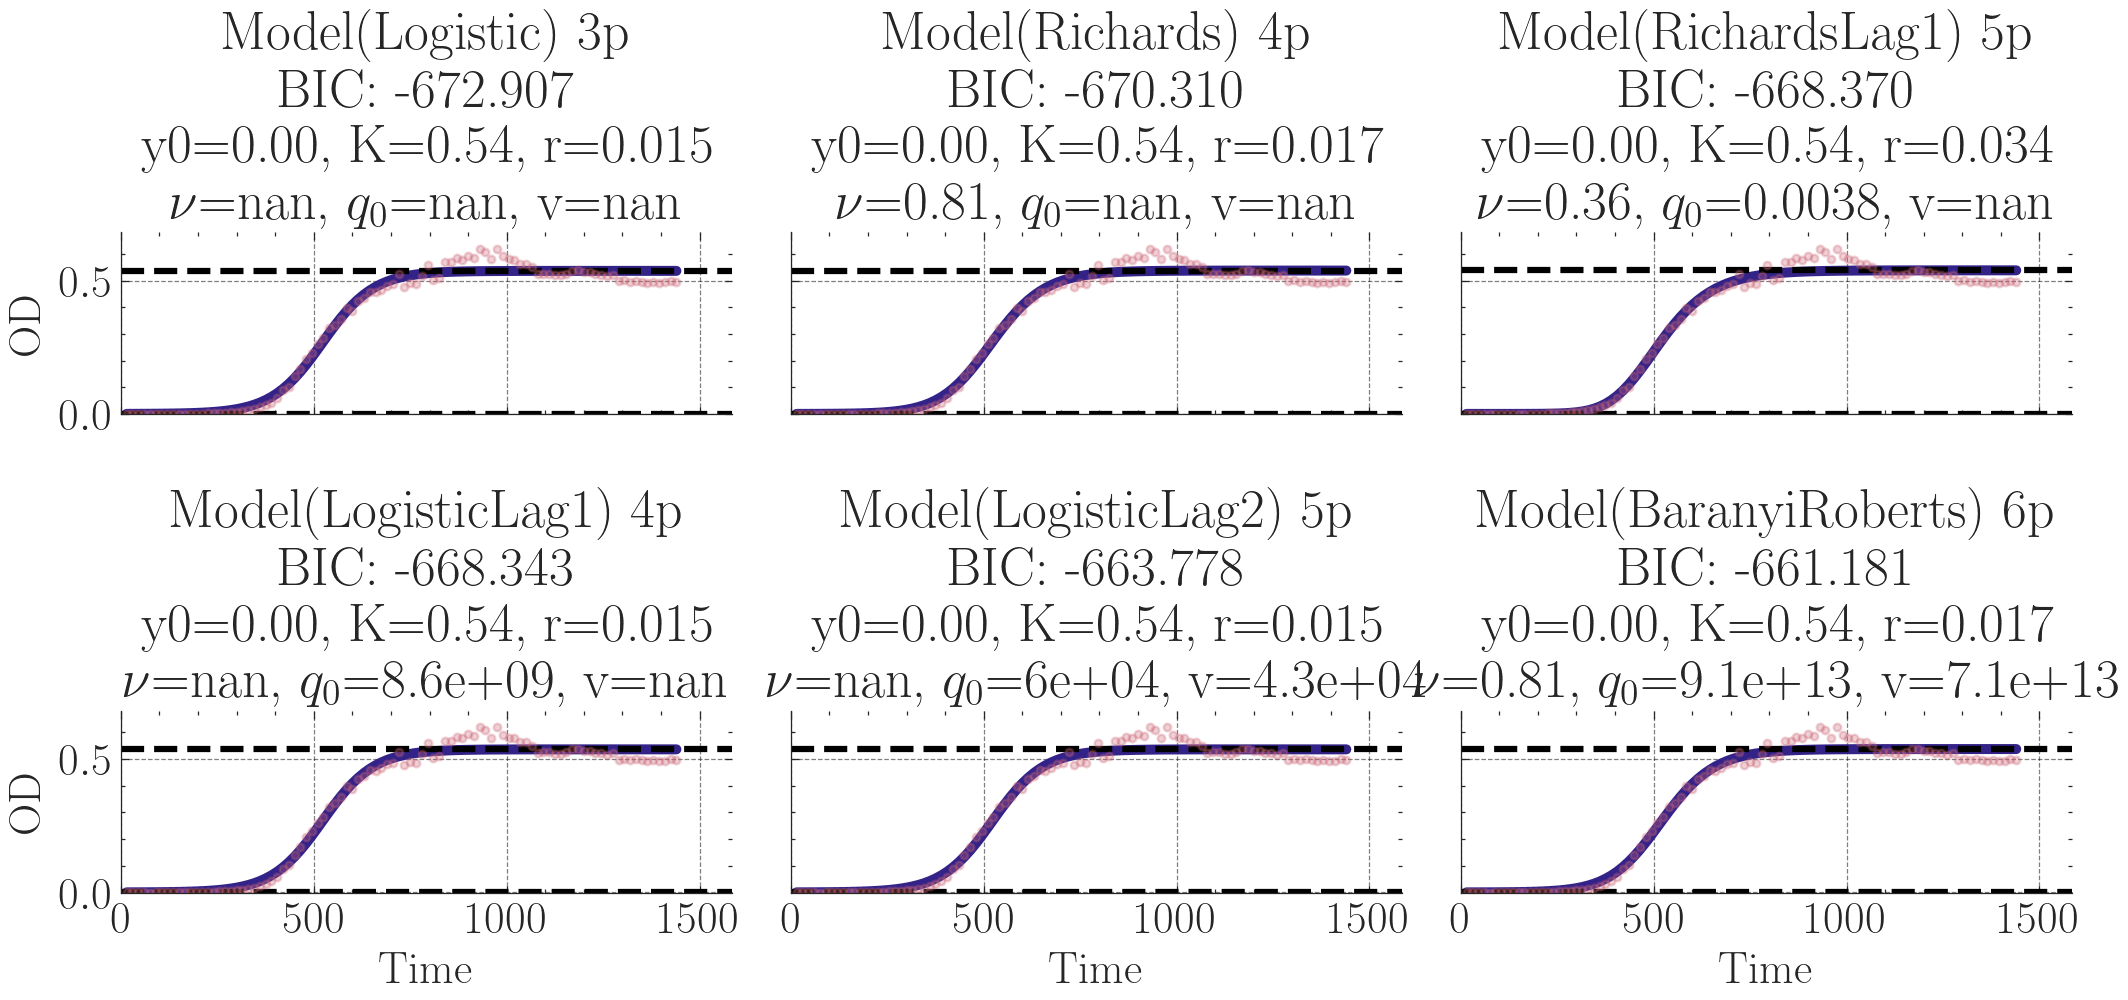

In [132]:
growth_data = pd.read_csv('plate_reader_results/220615_Cstr16_LB_avg.csv')
res, fig, ax = curveball.models.fit_model(growth_data.rename({'LB':'OD'},axis=1),PLOT=True,PRINT=False)
determine_td(res[5])

r_fitted  r_stderr          td  td_plus_err  td_min_err    td_err
2  0.006847  0.000268  101.240401    97.420058  105.372604  7.952546

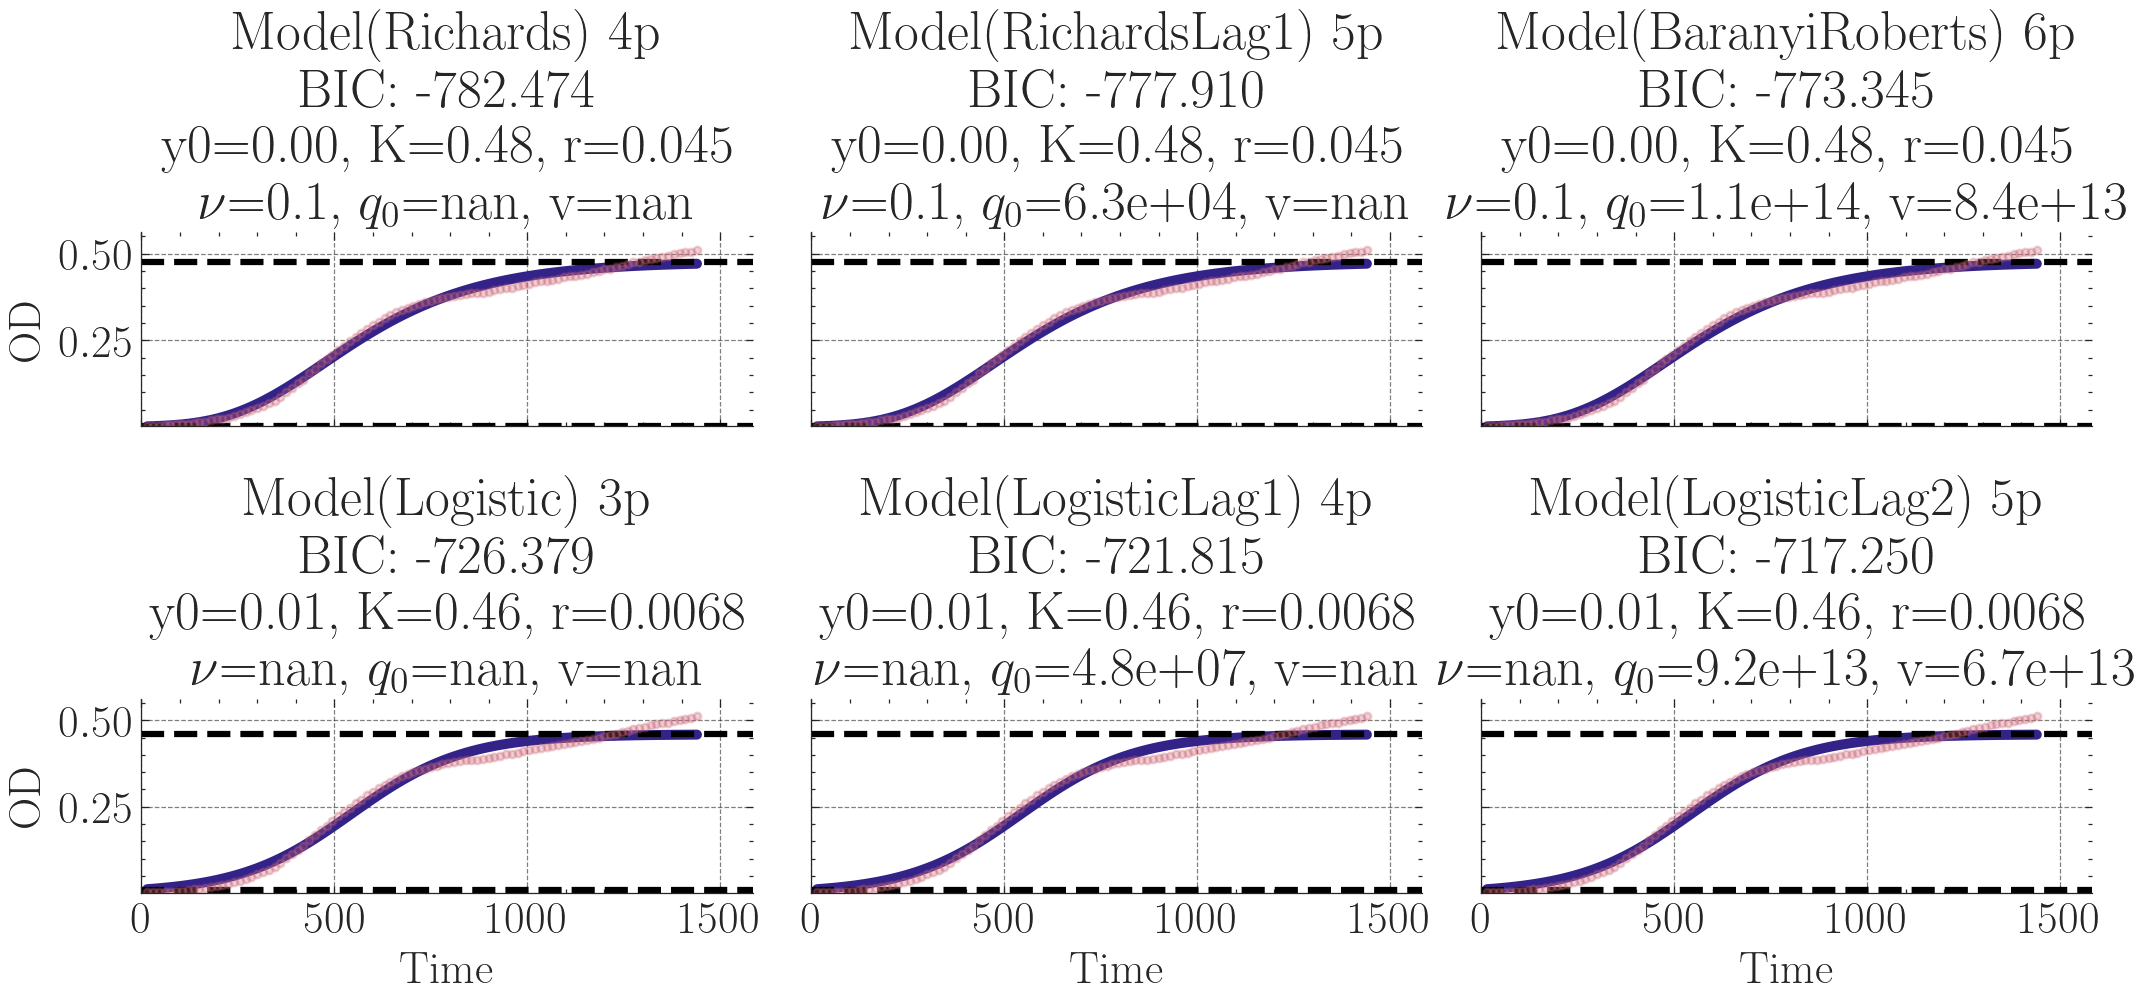

In [133]:
growth_data = media_avg['RPMI'][['Time', '14']]
res, fig, ax = curveball.models.fit_model(growth_data.rename({'14':'OD'},axis=1),PLOT=True,PRINT=False)
determine_td(res[3])